In [ ]:
# @title Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from datetime import datetime, timedelta
import matplotlib.patches as mpatches

In [2]:
# @title Data Preprocessing


data = pd.read_csv('processed_codes.csv')


participants_excluded = ['P1','P15','P18','P31','P34','P39','P40','P45']

data = data[~data['participant_id'].isin(participants_excluded)]
print(f"After exclusion, {data['participant_id'].nunique()} participants remain.")
#print subcodes present
#print(f"Subcodes present: {data['subcode'].unique()}")

#remove "group" == quote
data = data[data['code_group'] != 'quote']
print(f"After removing 'quote' group, {data.shape[0]} rows remain.")    

#remove nan subcodes
data = data[~data['subcode'].isna()]
print(f"After removing NaN subcodes, {data.shape[0]} rows remain.")

#remove all codes, for each participant, that occur before "initialprompt" subcode
new_data = pd.DataFrame()
for pid in data['participant_id'].unique():
    participant_data = data[data['participant_id'] == pid]
    if 'initialprompt' in participant_data['subcode'].values:
        initial_prompt_time = participant_data[participant_data['subcode'] == 'initialprompt']['start'].min()
        print(f"Participant {pid} initialprompt at {initial_prompt_time}")
        new_data = pd.concat([new_data, data[(data['participant_id'] == pid) & (data['start'] >= initial_prompt_time)]])
        print()
    elif "7alldone_callisabel" in participant_data['subcode'].values:
        alldone_time = participant_data[participant_data['subcode'] == '7alldone_callisabel']['start'].min()
        print(f"Participant {pid} has no initialprompt code, but has 7alldone_callisabel at {alldone_time}. Removing all codes.")
        new_data = pd.concat([new_data, data[(data['participant_id'] == pid) & (data['start'] >= alldone_time)]])
        print()
    else:
        print(f"Participant {pid} has no initialprompt code.")

    if "6robotsmoreorless" in participant_data['subcode'].values:
        #remove that row
        robotsmoreorless_time = participant_data[participant_data['subcode'] == '6robotsmoreorless']['start'].min()
        #remove row
        print(f"Participant {pid} has 6robotsmoreorless at {robotsmoreorless_time}. Removing that row.")
        new_data = new_data[~((new_data['participant_id'] == pid) & (new_data['subcode'] == '6robotsmoreorless'))]

    if "5likelessvideo" in participant_data['subcode'].values:
        #remove that row
        likelessvideo_time = participant_data[participant_data['subcode'] == '5likelessvideo']['start'].min()
        #remove row
        print(f"Participant {pid} has 5likelessvideo at {likelessvideo_time}. Removing that row.")
        new_data = new_data[~((new_data['participant_id'] == pid) & (new_data['subcode'] == '5likelessvideo'))]
print(f"After removing codes before 'initialprompt', {new_data.shape[0]} rows remain.")
data = new_data.copy()


#REMOVE INITIAL PROMPT AND CALL ISABEL CODES
data = data[~data['subcode'].isin(['initialprompt','7alldone_callisabel', 'researcher_knows','no_standup'])]
print(f"After removing 'initialprompt' and '7alldone_callisabel' codes, {data.shape[0]} rows remain.")


After exclusion, 50 participants remain.
After removing 'quote' group, 1155 rows remain.
After removing NaN subcodes, 1153 rows remain.
Participant P10 initialprompt at 00:07:08.305

Participant P11 initialprompt at 00:06:19.335

Participant P12 initialprompt at 00:05:43.490

Participant P13 initialprompt at 00:08:54.165

Participant P14 has no initialprompt code, but has 7alldone_callisabel at 00:07:51.640. Removing all codes.

Participant P16 initialprompt at 00:09:17.470

Participant P19 initialprompt at 00:08:13.550

Participant P2 initialprompt at 00:05:50.345

Participant P20 initialprompt at 00:05:09.310

Participant P21 initialprompt at 00:08:23.870

Participant P22 initialprompt at 00:06:26.895

Participant P23 initialprompt at 00:06:35.585

Participant P24 has no initialprompt code, but has 7alldone_callisabel at 00:05:14.390. Removing all codes.

Participant P25 initialprompt at 00:06:04.655

Participant P26 initialprompt at 00:05:03.805

Participant P27 initialprompt at 00:

In [ ]:
# @title Some Prints
#count subcode "pf"
pf_count = data[data['subcode'] == 'pf'].shape[0]
print(f"Number of 'pf' subcode occurrences: {pf_count}")
print(data['code_group'].value_counts())
print(data['subcode'].unique())
print(data['subcode'].value_counts())  


Number of 'pf' subcode occurrences: 7


In [ ]:
# @title Code Definitions
annotation_list = ["slower", "demanding", "interrogative", "filler", "assertive", "initialprompt", "longerprompt", 
                   "swappingterms", "simplerprompt", "noprompt", "prompt2researcher", "repeatprompt", "newprompt",
                     "lookingatPC", "humor", "frustration", "confusion", "quitting", "moves", "standups", "leaveroom",
                     "try2look2researcher", "look2researcher", "look2robot", "movecloser2robot","pf","researcher_knows",
                     "closer","lookingrobot","closerrobot","closer2robot","no_standup"
                   ]


code_groups = {
    "childprompttone": [
        "slower",
        "demanding", 
        "interrogative",
        "filler",
        "assertive"
    ],
    "childprompt": [
        "initialprompt",
        "longerprompt",
        "swappingterms",
        "simplerprompt",
        "noprompt",
        "prompt2researcher",
        "repeatprompt",
        "newprompt"
    ],
    "childreaction2failure": [
        "lookingatPC",
        "humor",
        "frustration",
        "confusion",
        "quitting",
        "moves",
        "standsup",
        "leaveroom",
        "try2look2researcher",
        "look2researcher",
        "look2robot",
        "movecloser2robot"
    ]
}

#code conversion dictionary
conversion_dict = {
    "repeatprompt": "repeats prompt",
    "longerprompt": "more specific/longer prompt",
    "swappingterms": "swaps terms",
    "simplerprompt": "simpler prompt",
    "demanding": "demanding tone",
    "interrogative": "interrogative tone",
    "filler": "filler words",
    "humor": "amusement/humor",
    "slower": "slower speech",
    "assertive": "assertive tone",
    "noprompt": "no prompt",
    "prompt2researcher": "looks for researcher",
    "newprompt": "makes new prompt",
    "lookingatPC": "looks at PC",
    "moves": "changes position",
    "standups": "stands up",
    "standsup": "stands up",
    "leaveroom": "leaves room",
    "try2look2researcher": "looks for researcher",
    "look2researcher": "looks for researcher",
    "look2robot": "looks at robot",
    "movecloser2robot": "moves closer to robot",
    "pf": "'please'",
    "closer": "moves closer to robot",
    "lookingrobot": "looks at robot",
    "lookingatrobot": "looks at robot",
    "closerrobot": "moves closer to robot",
    "closer2robot": "moves closer to robot",
    "fillerprompt": "filler words",
}


categories = {
    "did not engage": ["no prompt"],
    "reprompting strategies": ["longer prompt", "more specific/longer prompt", "swaps terms", "simpler prompt",
                        "repeats prompt","makes new prompt","'please'"],
    "verbal tone or cadence": ["slower speech", "demanding tone", "interrogative tone", "filler words",
                                "assertive tone","moves closer to robot"],
    "emotion": ["amusement/humor", "confusion", "frustration"],
    "disengagement": [ "stands up", "leaves room", "quitting", "speaks to researcher",
                      "looks for researcher"],# removed looks at pc and robot
}

engagement_categories = {
    "engages with robot": ["longer prompt", "more specific/longer prompt", "swaps terms", "simpler prompt",
                        "repeats prompt","makes new prompt","'please'",
                        "slower speech", "demanding tone", "interrogative tone", "filler words",
                                "assertive tone","moves closer to robot"],
   
    "disengages from robot": ["speaks to researcher", "looks for researcher",
                          "stands up", "leaves room", "no prompt","quitting"],
}

category_colors = {
    "reprompting strategies": "blue",
    "verbal tone or cadence": "green",
    "emotion": "red",
    "did not engage": "grey",
    "disengagement": "purple",
    "autonomy": "green",
    "calls for backup": "purple",
}


category_colormaps = {
    "reprompting strategies": cm.Blues,
    "verbal tone or cadence": cm.Greens,
    "emotion": cm.Reds,
    "disengagement": cm.Purples,
    "did not engage": cm.Greys,
    "autonomy": cm.Greens,
    "calls for backup": cm.Purples,
}

In [5]:
# @title Analyze Reactions Between Errors
def time_to_seconds(time_str):
    """Convert HH:MM:SS.fff to total seconds"""
    try:
        # Handle the format "HH:MM:SS.fff"
        parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds_parts = parts[2].split('.')
        seconds = int(seconds_parts[0])
        milliseconds = int(seconds_parts[1]) if len(seconds_parts) > 1 else 0
        
        total_seconds = hours * 3600 + minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    except:
        return np.nan

def extract_error_intervals(df):
    """Extract the time intervals between successive errors for each participant"""
    participants = df['participant_id'].unique()
    intervals = []
    
    for participant in participants:
        print(f"Processing participant: {participant}")
        
        # Filter data for current participant and sort by start time
        p_data = df[df['participant_id'] == participant].copy()
        p_data['start_seconds'] = p_data['start'].apply(time_to_seconds)
        p_data['end_seconds'] = p_data['end'].apply(time_to_seconds)
        p_data = p_data.sort_values('start_seconds')
        
        # Find error prompts and callisabel
        nounderstanding = p_data[p_data['subcode'] == '8nounderstanding3x']
        callisabel = p_data[p_data['subcode'] == '9callisabel']
        
        print(f"  Found {len(nounderstanding)} nounderstanding prompts")
        print(f"  Found {len(callisabel)} callisabel events")
        
        # Define error intervals
        error_intervals = []
        
        # Error 1: between end of 1st nounderstanding and start of 2nd nounderstanding
        if len(nounderstanding) >= 2:
            start_time = nounderstanding.iloc[0]['end_seconds']
            end_time = nounderstanding.iloc[1]['start_seconds']
            error_intervals.append((1, start_time, end_time))
            print(f"  Error 1 interval: {start_time:.3f} - {end_time:.3f}")
        
        # Error 2: between end of 2nd nounderstanding and start of 3rd nounderstanding  
        if len(nounderstanding) >= 3:
            start_time = nounderstanding.iloc[1]['end_seconds']
            end_time = nounderstanding.iloc[2]['start_seconds']
            error_intervals.append((2, start_time, end_time))
            print(f"  Error 2 interval: {start_time:.3f} - {end_time:.3f}")
        
        # Error 3: between end of 3rd nounderstanding and start of callisabel
        if len(nounderstanding) >= 3 and len(callisabel) >= 1:
            start_time = nounderstanding.iloc[2]['end_seconds']
            end_time = callisabel.iloc[0]['start_seconds']
            error_intervals.append((3, start_time, end_time))
            print(f"  Error 3 interval: {start_time:.3f} - {end_time:.3f}")
        
        intervals.append((participant, error_intervals))
        print()
    
    return intervals

def filter_reactions_between_errors(df, error_intervals):
    """Filter dataframe to only include reactions between errors"""
    filtered_rows = []
    
    for participant, intervals in error_intervals:
        print(f"Filtering reactions for participant: {participant}")
        
        # Get participant data
        p_data = df[df['participant_id'] == participant].copy()
        p_data['start_seconds'] = p_data['start'].apply(time_to_seconds)
        p_data['end_seconds'] = p_data['end'].apply(time_to_seconds)
        
        for error_num, interval_start, interval_end in intervals:
            # Find rows that overlap with this error interval
            # A row overlaps if its start is before interval_end and its end is after interval_start
            overlapping = p_data[
                (p_data['start_seconds'] < interval_end) & 
                (p_data['end_seconds'] > interval_start) &
                (~p_data['subcode'].isin(['8nounderstanding3x', '9callisabel']))  # Exclude the error prompts themselves
            ].copy()
            
            if len(overlapping) > 0:
                overlapping['error'] = error_num
                filtered_rows.append(overlapping)
                print(f"  Error {error_num}: Found {len(overlapping)} reaction(s)")
                for _, row in overlapping.iterrows():
                    print(f"    {row['subcode']} ({row['start']} - {row['end']})")
            else:
                print(f"  Error {error_num}: No reactions found")
    
    if filtered_rows:
        result_df = pd.concat(filtered_rows, ignore_index=True)
        # Drop the helper columns
        result_df = result_df.drop(['start_seconds', 'end_seconds'], axis=1)
        return result_df
    else:
        return pd.DataFrame()

# Read the processed codes data
print("Loading processed_codes.csv...")
df = data.copy()
print(df.columns)
print(f"Loaded {len(df)} rows")
print(f"Participants: {df['participant_id'].unique()}")
print(f"Unique subcodes: {df['subcode'].unique()}")
#counts
print("Subcode counts:")
print(df['subcode'].value_counts())
print()

# Extract error intervals for each participant
print("=== EXTRACTING ERROR INTERVALS ===")
error_intervals = extract_error_intervals(df)

# Filter reactions that occur between errors
print("=== FILTERING REACTIONS BETWEEN ERRORS ===")
reactions_df = filter_reactions_between_errors(df, error_intervals)

print(f"\n=== RESULTS ===")
print(f"Found {len(reactions_df)} reaction events between errors")

if len(reactions_df) > 0:
    print("\nReactions by error:")
    print(reactions_df['error'].value_counts().sort_index())
    
    print("\nSubcodes found:")
    print(reactions_df['subcode'].value_counts())
    
    # Apply code conversion dictionary
    print("\n=== APPLYING CODE CONVERSIONS ===")
    reactions_df['subcode_readable'] = reactions_df['subcode'].map(conversion_dict)
    
    # For subcodes not in conversion dict, keep original
    reactions_df['subcode_readable'] = reactions_df['subcode_readable'].fillna(reactions_df['subcode'])
    
    print("Converted subcodes:")
    print(reactions_df['subcode_readable'].value_counts())
    
    # Display sample of results
    print("\n=== SAMPLE RESULTS ===")
    print(reactions_df[['participant_id', 'subcode', 'subcode_readable', 'start', 'end', 'error']].head(10))
    
    # Save results
    reactions_df.to_csv("reactions_between_errors_noncurated.csv", index=False)
    print(f"\nResults saved to 'reactions_between_errors_noncurated.csv'")

else:
    print("No reactions found between errors")



Loading processed_codes.csv...
Index(['participant_id', 'video_name', 'start', 'end', 'duration',
       'code_group', 'subcode'],
      dtype='object')
Loaded 724 rows
Participants: ['P10' 'P11' 'P12' 'P13' 'P14' 'P16' 'P19' 'P2' 'P20' 'P21' 'P22' 'P23'
 'P24' 'P25' 'P26' 'P27' 'P28' 'P29' 'P3' 'P30' 'P32' 'P33' 'P35' 'P36'
 'P37' 'P38' 'P4' 'P41' 'P42' 'P43' 'P44' 'P46' 'P47' 'P48' 'P49' 'P5'
 'P50' 'P51' 'P52' 'P53' 'P54' 'P55' 'P56' 'P57' 'P58' 'P59' 'P6' 'P7'
 'P8' 'P9']
Unique subcodes: ['pf' '8nounderstanding3x' 'interrogative' 'simplerprompt' 'frustration'
 'noprompt' 'quitting' 'slower' 'longerprompt' '9callisabel' 'lookingatPC'
 'confusion' 'moves' 'repeatprompt' 'leaveroom' 'look2researcher'
 'lookingrobot' 'try2look2researcher' 'humor' 'standsup' 'closer'
 'look2robot' 'filler' 'demanding' 'prompt2researcher' 'swappingterms'
 'movecloser2robot' 'newprompt' 'lookingatrobot' 'fillerprompt'
 'closer2robot' 'assertive' 'closerrobot']
Subcode counts:
subcode
8nounderstanding3x  

Classifying engagement by error using specified logic...
Engages with robot subcodes: {'makes new prompt', 'slower speech', 'simpler prompt', 'assertive tone', 'filler words', 'repeats prompt', 'more specific/longer prompt', 'longer prompt', 'interrogative tone', 'swaps terms', 'moves closer to robot', 'demanding tone', "'please'"}
Disengages from robot subcodes: {'no prompt', 'quitting', 'speaks to researcher', 'stands up', 'leaves room', 'looks for researcher'}

Participant P10, Error 1:
  Found ENGAGES: interrogative tone
    eng = 1
  Found ENGAGES: simpler prompt
    eng = 1
  Final classification for Error 1: 1

Participant P10, Error 2:
  Ignored: frustration
  Found DISENGAGES: no prompt
    eng = 2
  Final classification for Error 2: 2

Participant P10, Error 3:
  Found ENGAGES: simpler prompt
    eng = 1
  Ignored: frustration
  Found ENGAGES: slower speech
    eng = 1
  Found ENGAGES: more specific/longer prompt
    eng = 1
  Final classification for Error 3: 1

Participant 

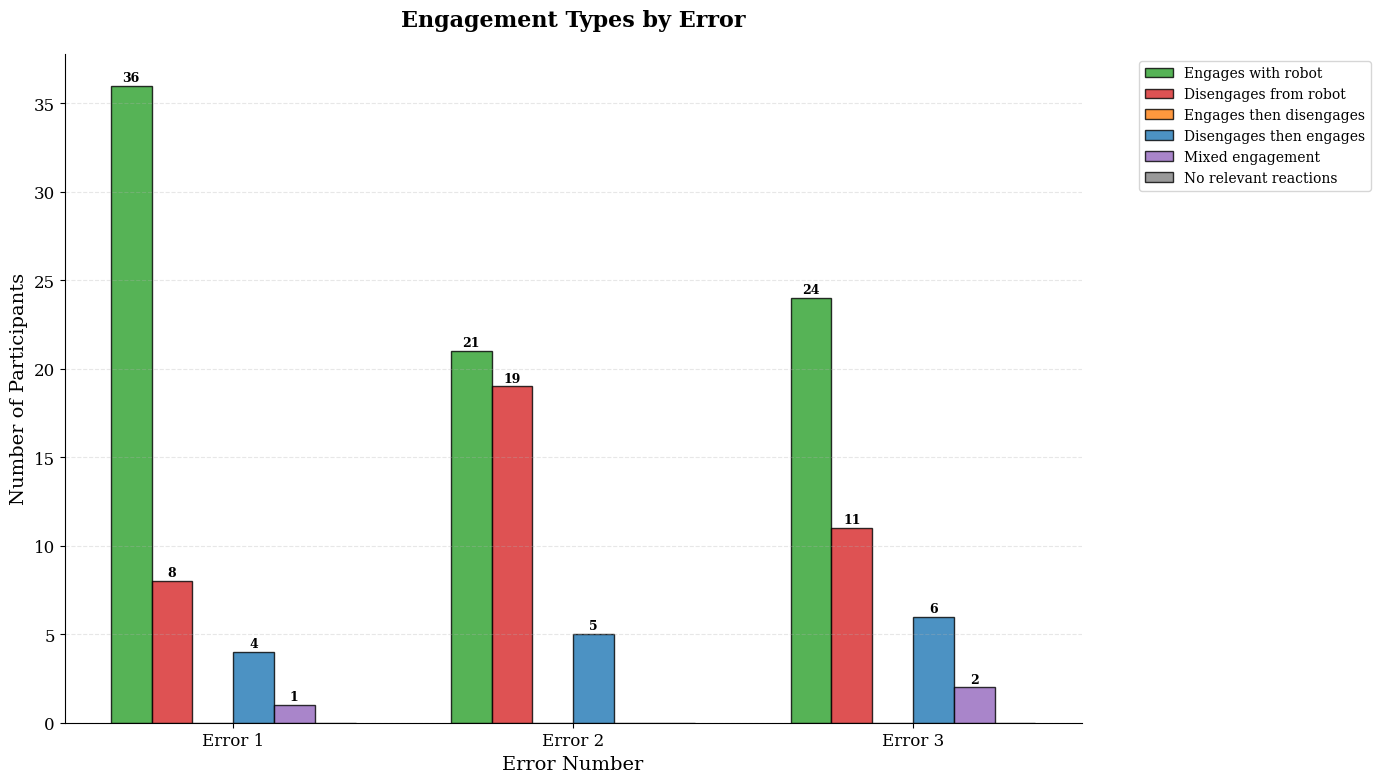

Engagement types by error saved to 'plots/engagement_types_by_error.png'

2. Analyzing engagement consistency...


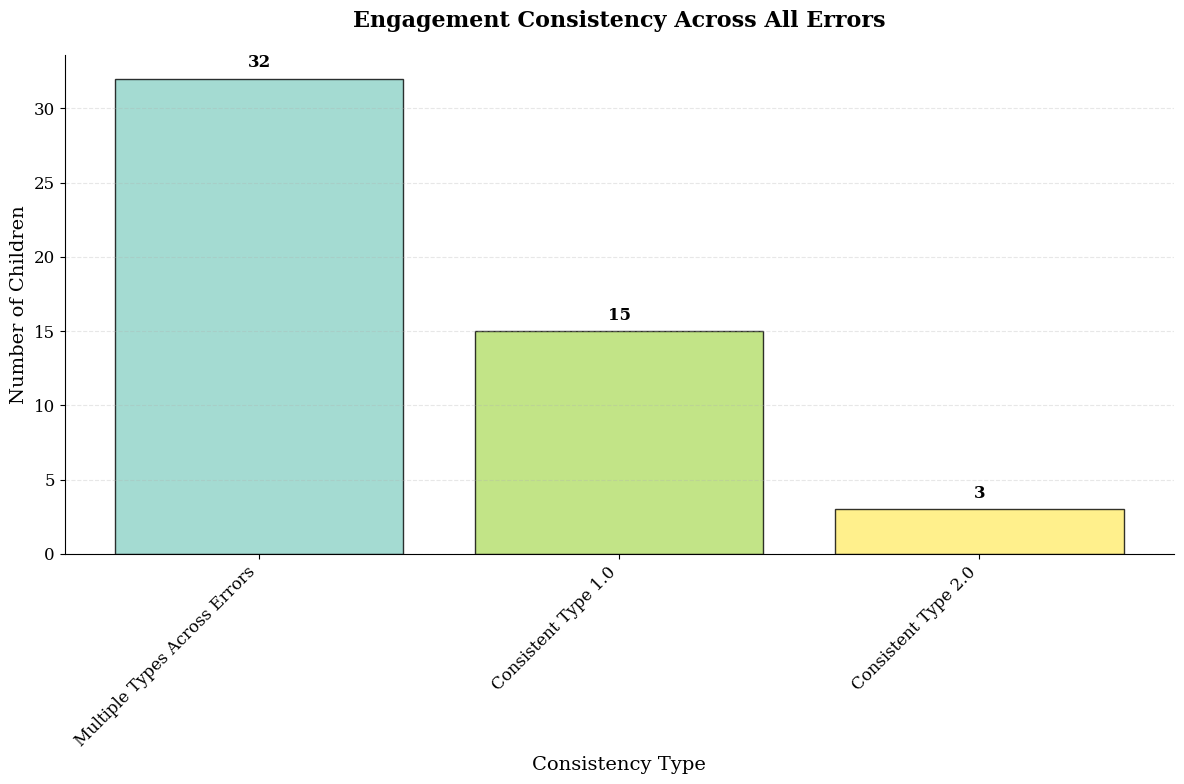

Engagement consistency plot saved to 'plots/engagement_consistency.png'

3. Analyzing engagement paths...

MOST COMMON ENGAGEMENT PATHS
Legend: 1=Engages, 2=Disengages, 3=Eng→Diseng, 4=Diseng→Eng, 5=Mixed, X=No data

 1. 1.0 → 1.0 → 1.0: 15 children (30.0%)
 2. 1.0 → 2.0 → 1.0:  5 children (10.0%)
 3. 1.0 → 2.0 → 2.0:  4 children ( 8.0%)
 4. 1.0 → 4.0 → 4.0:  3 children ( 6.0%)
 5. 1.0 → nan → nan:  3 children ( 6.0%)
 6. 2.0 → 2.0 → 2.0:  3 children ( 6.0%)
 7. 2.0 → 1.0 → 2.0:  2 children ( 4.0%)
 8. 2.0 → 2.0 → nan:  2 children ( 4.0%)
 9. nan → 2.0 → nan:  1 children ( 2.0%)
10. 4.0 → 1.0 → 1.0:  1 children ( 2.0%)


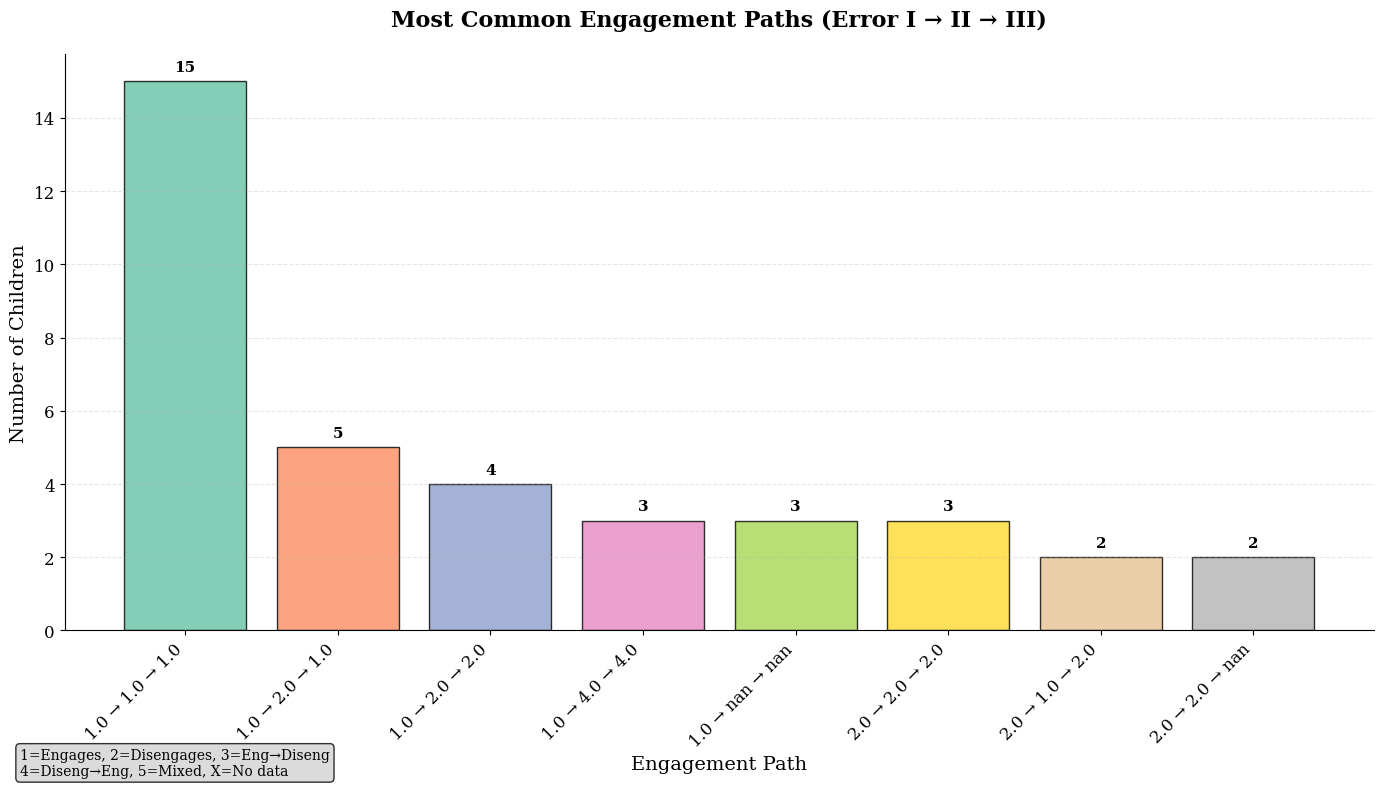

Engagement paths plot saved to 'plots/engagement_paths.png'

Engagement classification results saved to 'engagement_by_error_results.csv'

SUMMARY STATISTICS
Total participants analyzed: 50

Error 1 engagement distribution:
  Engages: 36 children (72.0%)
  Disengages: 8 children (16.0%)
  Diseng→Eng: 4 children (8.0%)
  Mixed: 1 children (2.0%)

Error 2 engagement distribution:
  Engages: 21 children (42.0%)
  Disengages: 19 children (38.0%)
  Diseng→Eng: 5 children (10.0%)

Error 3 engagement distribution:
  Engages: 24 children (48.0%)
  Disengages: 11 children (22.0%)
  Diseng→Eng: 6 children (12.0%)
  Mixed: 2 children (4.0%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def classify_engagement_by_error():
    """Classify each participant's engagement for each error using the specified logic"""
    
    # Define the new engagement categories
    engagement_categories = {
        "engages with robot": ["longer prompt", "more specific/longer prompt", "swaps terms", "simpler prompt",
                              "repeats prompt","makes new prompt","'please'",
                              "slower speech", "demanding tone", "interrogative tone", "filler words",
                              "assertive tone","moves closer to robot"],
        "disengages from robot": ["speaks to researcher", "looks for researcher",
                                 "stands up", "leaves room", "no prompt","quitting"]
    }
    
    engages_subcodes = set(engagement_categories["engages with robot"])
    disengages_subcodes = set(engagement_categories["disengages from robot"])
    
    print("Engages with robot subcodes:", engages_subcodes)
    print("Disengages from robot subcodes:", disengages_subcodes)
    
    # Read the reactions data
    data = pd.read_csv('reactions_between_errors.csv')
    
    # Initialize results
    results = []
    
    participants = data['participant_id'].unique()
    
    for participant in participants:
        participant_data = data[data['participant_id'] == participant]
        
        participant_results = {'participant_id': participant}
        
        for error in [1, 2, 3]:
            error_data = participant_data[participant_data['error'] == error].sort_values('start')
            
            # Initialize engagement state for this error
            eng = None  # Using None instead of NaN for cleaner logic
            
            print(f"\nParticipant {participant}, Error {error}:")
            
            # Process each annotation row for this error
            for _, row in error_data.iterrows():
                subcode = row['subcode_readable']
                
                if subcode in engages_subcodes:
                    print(f"  Found ENGAGES: {subcode}")
                    if eng == 1 or eng is None:
                        eng = 1
                        print(f"    eng = 1")
                    elif eng == 2 or eng == 4:
                        eng = 4
                        print(f"    eng = 4 (disengages then engages)")
                    else:
                        eng = 5
                        print(f"    eng = 5 (mixed)")
                        
                elif subcode in disengages_subcodes:
                    print(f"  Found DISENGAGES: {subcode}")
                    if eng == 2 or eng is None:
                        eng = 2
                        print(f"    eng = 2")
                    elif eng == 1 or eng == 3:
                        eng = 3
                        print(f"    eng = 3 (engages then disengages)")
                    else:
                        eng = 5
                        print(f"    eng = 5 (mixed)")
                else:
                    print(f"  Ignored: {subcode}")
            
            # Store result for this error
            participant_results[f'error_{error}'] = eng
            print(f"  Final classification for Error {error}: {eng}")
        
        results.append(participant_results)
    
    return pd.DataFrame(results)

def plot_engagement_by_error(results_df):
    """Plot engagement types for each error"""
    
    # Define engagement type labels
    engagement_labels = {
        1: "Engages with robot",
        2: "Disengages from robot", 
        3: "Engages then disengages",
        4: "Disengages then engages",
        5: "Mixed engagement",
        None: "No relevant reactions"
    }
    
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    errors = [1, 2, 3]
    engagement_types = [1, 2, 3, 4, 5, None]
    colors = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4', '#9467bd', '#808080']
    
    # Count engagement types for each error
    error_counts = {}
    for error in errors:
        col_name = f'error_{error}'
        counts = results_df[col_name].value_counts()
        error_counts[error] = counts
    
    # Create grouped bar chart
    x = np.arange(len(errors))
    width = 0.12  # Width of bars
    
    for i, (eng_type, color) in enumerate(zip(engagement_types, colors)):
        counts = []
        for error in errors:
            count = error_counts[error].get(eng_type, 0)
            counts.append(count)
        
        label = engagement_labels[eng_type]
        plt.bar(x + i * width, counts, width, label=label, color=color, alpha=0.8, edgecolor='black')
        
        # Add value labels on bars
        for j, count in enumerate(counts):
            if count > 0:
                plt.text(x[j] + i * width, count + 0.1, str(count), 
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.title('Engagement Types by Error', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Error Number', fontsize=14)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.xticks(x + width * 2.5, [f'Error {e}' for e in errors])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/engagement_types_by_error.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Engagement types by error saved to 'plots/engagement_types_by_error.png'")

def analyze_overall_engagement_consistency(results_df):
    """Analyze how many children have consistent vs mixed engagement across all errors"""
    
    engagement_patterns = []
    
    for _, row in results_df.iterrows():
        participant_id = row['participant_id']
        error_engagements = [row['error_1'], row['error_2'], row['error_3']]
        
        # Remove None values for analysis
        valid_engagements = [e for e in error_engagements if e is not None]
        unique_engagements = set(valid_engagements)
        
        if len(valid_engagements) == 0:
            consistency = "No engagement data"
        elif len(unique_engagements) == 1:
            eng_type = list(unique_engagements)[0]
            if eng_type in [1, 2]:
                consistency = f"Consistent Type {eng_type}"
            else:
                consistency = f"Consistent Mixed/Complex"
        else:
            consistency = "Multiple Types Across Errors"
        
        engagement_patterns.append({
            'participant_id': participant_id,
            'consistency': consistency,
            'unique_types': len(unique_engagements),
            'valid_errors': len(valid_engagements)
        })
    
    patterns_df = pd.DataFrame(engagement_patterns)
    
    # Plot consistency analysis
    plt.figure(figsize=(12, 8), facecolor='white')
    
    consistency_counts = patterns_df['consistency'].value_counts()
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(consistency_counts)))
    bars = plt.bar(range(len(consistency_counts)), consistency_counts.values, 
                   color=colors, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, count in zip(bars, consistency_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.title('Engagement Consistency Across All Errors', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Consistency Type', fontsize=14)
    plt.ylabel('Number of Children', fontsize=14)
    plt.xticks(range(len(consistency_counts)), consistency_counts.index, rotation=45, ha='right')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/engagement_consistency.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Engagement consistency plot saved to 'plots/engagement_consistency.png'")
    
    return patterns_df

def analyze_engagement_paths(results_df):
    """Analyze common engagement paths across Error 1 → 2 → 3"""
    
    # Create engagement sequences
    engagement_sequences = []
    
    for _, row in results_df.iterrows():
        participant_id = row['participant_id']
        sequence = [row['error_1'], row['error_2'], row['error_3']]
        
        # Convert to string representation, handling None values
        sequence_str = " → ".join([str(s) if s is not None else "X" for s in sequence])
        
        engagement_sequences.append({
            'participant_id': participant_id,
            'sequence': sequence,
            'sequence_str': sequence_str
        })
    
    sequences_df = pd.DataFrame(engagement_sequences)
    
    # Count most common paths
    path_counts = sequences_df['sequence_str'].value_counts()
    
    print(f"\n" + "="*60)
    print("MOST COMMON ENGAGEMENT PATHS")
    print("="*60)
    
    print("Legend: 1=Engages, 2=Disengages, 3=Eng→Diseng, 4=Diseng→Eng, 5=Mixed, X=No data")
    print()
    
    for i, (path, count) in enumerate(path_counts.head(10).items(), 1):
        percentage = (count / len(sequences_df)) * 100
        print(f"{i:2d}. {path:15s}: {count:2d} children ({percentage:4.1f}%)")
    
    # Plot top engagement paths
    plt.figure(figsize=(14, 8), facecolor='white')
    
    top_paths = path_counts.head(8)  # Show top 8 paths
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(top_paths)))
    bars = plt.bar(range(len(top_paths)), top_paths.values, 
                   color=colors, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, count in zip(bars, top_paths.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Most Common Engagement Paths (Error I → II → III)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Engagement Path', fontsize=14)
    plt.ylabel('Number of Children', fontsize=14)
    plt.xticks(range(len(top_paths)), top_paths.index, rotation=45, ha='right')
    
    # Add legend explaining the codes
    legend_text = "1=Engages, 2=Disengages, 3=Eng→Diseng\n4=Diseng→Eng, 5=Mixed, X=No data"
    plt.figtext(0.02, 0.02, legend_text, fontsize=10, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/engagement_paths.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Engagement paths plot saved to 'plots/engagement_paths.png'")
    
    return sequences_df

# Run the analysis
print("Classifying engagement by error using specified logic...")
results_df = classify_engagement_by_error()

print("\n1. Creating engagement types by error plot...")
plot_engagement_by_error(results_df)

print("\n2. Analyzing engagement consistency...")
consistency_df = analyze_overall_engagement_consistency(results_df)

print("\n3. Analyzing engagement paths...")
sequences_df = analyze_engagement_paths(results_df)

# Save results
results_df.to_csv('engagement_by_error_results.csv', index=False)
print(f"\nEngagement classification results saved to 'engagement_by_error_results.csv'")

# Print summary statistics
print(f"\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

total_participants = len(results_df)
print(f"Total participants analyzed: {total_participants}")

for error in [1, 2, 3]:
    col_name = f'error_{error}'
    error_counts = results_df[col_name].value_counts()
    print(f"\nError {error} engagement distribution:")
    for eng_type, count in error_counts.items():
        percentage = (count / total_participants) * 100
        type_name = {1: "Engages", 2: "Disengages", 3: "Eng→Diseng", 
                    4: "Diseng→Eng", 5: "Mixed", None: "No data"}[eng_type]
        print(f"  {type_name}: {count} children ({percentage:.1f}%)")

    

Analyzing first disengagement for reactions: ['stands up', 'leaves room', 'quitting', 'speaks to researcher', 'looks for researcher', 'no prompt']
Loaded 425 total reactions
Available participants: ['P10', 'P11', 'P12', 'P13', 'P14', 'P16', 'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P3', 'P30', 'P32', 'P33', 'P35', 'P36', 'P37', 'P38', 'P4', 'P41', 'P42', 'P43', 'P44', 'P46', 'P47', 'P48', 'P49', 'P5', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P6', 'P7', 'P8', 'P9']
Found 85 disengagement reactions
Disengagement reactions found:
subcode_readable
no prompt               44
looks for researcher    29
quitting                 7
leaves room              4
stands up                1
Name: count, dtype: int64
Participant P10: First disengagement in Error 2 - no prompt
Participant P11: First disengagement in Error 2 - no prompt
Participant P12: First disengagement in Error 2 - quitting
Participant P13: First disengagement i

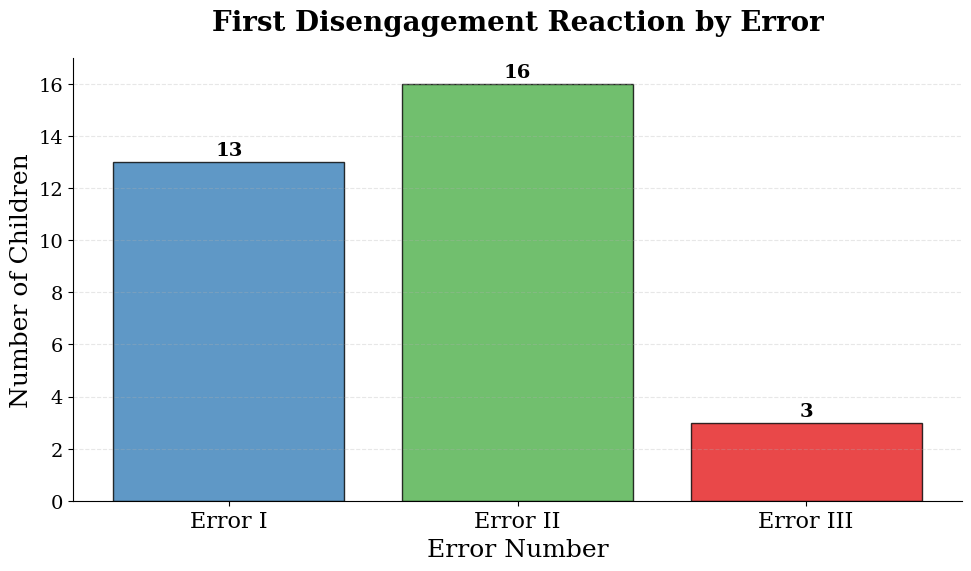


TYPES OF FIRST DISENGAGEMENT REACTIONS
Most common first disengagement reactions:
  no prompt: 17 children (53.1%)
  looks for researcher: 11 children (34.4%)
  quitting: 2 children (6.2%)
  stands up: 1 children (3.1%)
  leaves room: 1 children (3.1%)

Detailed results saved to 'first_disengagement_results.csv'
Disengagement composition by error:
first_disengagement_type   leaves room  looks for researcher  no prompt  \
first_disengagement_error                                                 
1                                    0                     5          7   
2                                    1                     5          9   
3                                    0                     1          1   

first_disengagement_type   quitting  stands up  
first_disengagement_error                       
1                                 0          1  
2                                 1          0  
3                                 1          0  

Stacked plot saved to 'plot

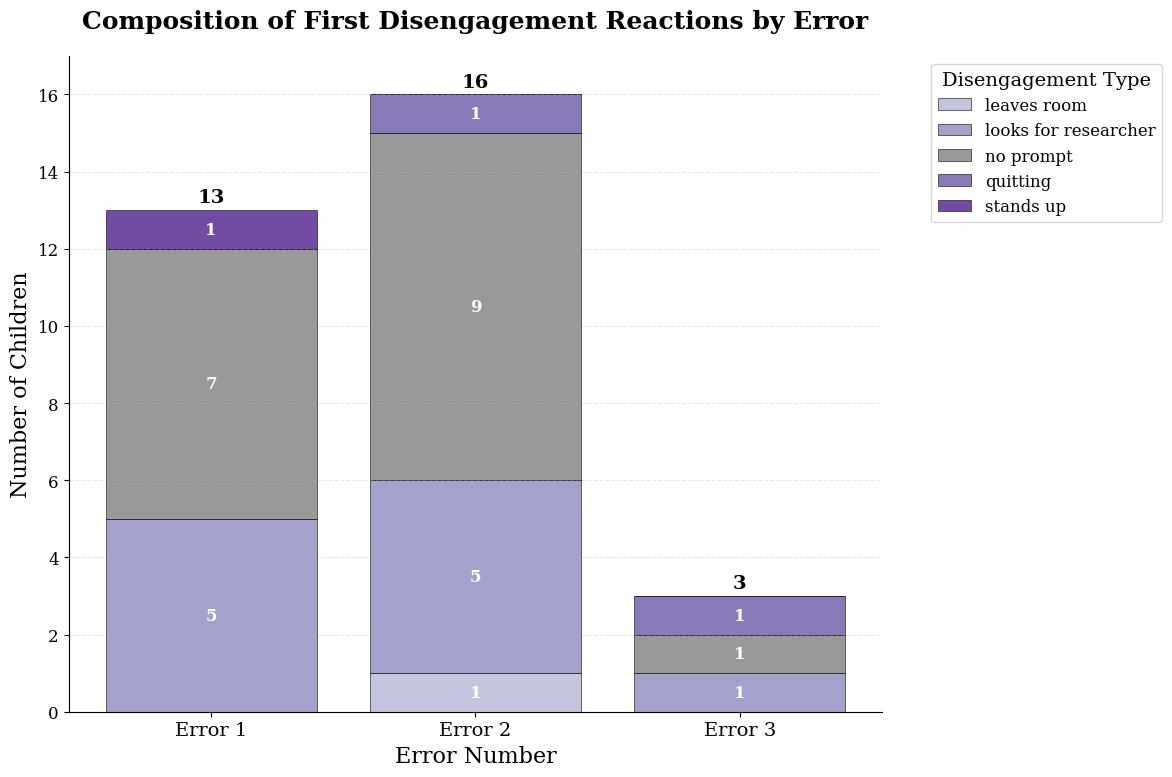


DETAILED DISENGAGEMENT COMPOSITION

Error 1 (Total: 13 children):
  looks for researcher: 5 children (38.5%)
  no prompt: 7 children (53.8%)
  stands up: 1 children (7.7%)

Error 2 (Total: 16 children):
  leaves room: 1 children (6.2%)
  looks for researcher: 5 children (31.2%)
  no prompt: 9 children (56.2%)
  quitting: 1 children (6.2%)

Error 3 (Total: 3 children):
  looks for researcher: 1 children (33.3%)
  no prompt: 1 children (33.3%)
  quitting: 1 children (33.3%)


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze_first_disengagement():
    """Analyze when children first show disengagement reactions"""
    
    # Use the disengagement category from your updated categories
    disengagement_reactions = categories["disengagement"] + categories["did not engage"]
    disengagement_reactions.remove("looks at robot")
    disengagement_reactions.remove("looks at PC")
    print(f"Analyzing first disengagement for reactions: {disengagement_reactions}")
    
    # Read the reactions data
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} total reactions")
    print(f"Available participants: {sorted(data['participant_id'].unique())}")
    
    # Filter to only disengagement reactions
    disengagement_data = data[data['subcode_readable'].isin(disengagement_reactions)].copy()
    
    print(f"Found {len(disengagement_data)} disengagement reactions")
    
    if len(disengagement_data) == 0:
        print("No disengagement reactions found!")
        print(f"Available reactions in data: {sorted(data['subcode_readable'].unique())}")
        return
    
    print(f"Disengagement reactions found:")
    print(disengagement_data['subcode_readable'].value_counts())
    
    # For each participant, find their first disengagement reaction
    first_disengagement = []
    
    participants = disengagement_data['participant_id'].unique()
    
    for participant in participants:
        participant_disengagement = disengagement_data[
            disengagement_data['participant_id'] == participant
        ].copy()
        
        # Find the earliest error number for this participant
        first_error = participant_disengagement['error'].min()
        
        # Get details of the first disengagement
        first_reaction = participant_disengagement[
            participant_disengagement['error'] == first_error
        ].iloc[0]  # Take first if multiple in same error
        
        first_disengagement.append({
            'participant_id': participant,
            'first_disengagement_error': first_error,
            'first_disengagement_type': first_reaction['subcode_readable'],
            'reaction_time': first_reaction['start']
        })
        
        print(f"Participant {participant}: First disengagement in Error {first_error} - {first_reaction['subcode_readable']}")
    
    # Convert to DataFrame
    first_disengagement_df = pd.DataFrame(first_disengagement)
    
    # Count distribution across errors
    error_counts = first_disengagement_df['first_disengagement_error'].value_counts().sort_index()
    
    print(f"\n" + "="*60)
    print("FIRST DISENGAGEMENT DISTRIBUTION")
    print("="*60)
    
    total_participants_with_disengagement = len(first_disengagement_df)
    total_participants = len(data['participant_id'].unique())
    
    print(f"Total participants: {total_participants}")
    print(f"Participants who showed disengagement: {total_participants_with_disengagement}")
    print(f"Participants who never disengaged: {total_participants - total_participants_with_disengagement}")
    
    print(f"\nFirst disengagement by error:")
    for error_num in [1, 2, 3]:
        count = error_counts.get(error_num, 0)
        percentage = (count / total_participants_with_disengagement) * 100 if total_participants_with_disengagement > 0 else 0
        print(f"  Error {error_num}: {count} children ({percentage:.1f}% of those who disengaged)")
    
    # Create visualization
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Prepare data for plotting
    errors = [1, 2, 3]
    counts = [error_counts.get(error, 0) for error in errors]
    
    # Create bar plot
    bars = plt.bar(errors, counts, 
                   color=['#377EB8', '#4DAF4A', '#E41A1C'],  # Blue, Green, Red
                   edgecolor='black', 
                   linewidth=1,
                   alpha=0.8)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    str(count), ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Customize plot
    plt.xlabel('Error Number', fontsize=18)
    plt.ylabel('Number of Children', fontsize=18)
    plt.title('First Disengagement Reaction by Error', fontsize=20, pad=20, fontweight='bold')
    plt.xticks(errors, ['Error I', 'Error II', 'Error III'], fontsize=16)
    plt.yticks(fontsize=14)
    
    # Set y-axis to start at 0 and go slightly above max
    plt.ylim(0, max(counts) + 1 if max(counts) > 0 else 1)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig('plots/first_disengagement_by_error.png', format='png', dpi=500, bbox_inches='tight')
    print(f"\nPlot saved to 'plots/first_disengagement_by_error.png'")
    
    plt.show()
    
    # Additional analysis: Types of first disengagement reactions
    print(f"\n" + "="*60)
    print("TYPES OF FIRST DISENGAGEMENT REACTIONS")
    print("="*60)
    
    reaction_types = first_disengagement_df['first_disengagement_type'].value_counts()
    print("Most common first disengagement reactions:")
    for reaction, count in reaction_types.items():
        percentage = (count / total_participants_with_disengagement) * 100
        print(f"  {reaction}: {count} children ({percentage:.1f}%)")
    
    # Save the detailed results
    first_disengagement_df.to_csv('first_disengagement_results.csv', index=False)
    print(f"\nDetailed results saved to 'first_disengagement_results.csv'")
    
    return first_disengagement_df

def create_disengagement_comparison():
    """Create a comparison showing disengagement vs non-disengagement participants"""
    
    # Get first disengagement data
    first_disengagement_df = analyze_first_disengagement()
    
    if first_disengagement_df is None or len(first_disengagement_df) == 0:
        return
    
    # Read all reaction data to get total participants
    all_data = pd.read_csv('reactions_between_errors.csv')
    total_participants = len(all_data['participant_id'].unique())
    participants_with_disengagement = len(first_disengagement_df)
    participants_without_disengagement = total_participants - participants_with_disengagement
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='white')
    
    # Plot 1: Overall disengagement vs no disengagement
    categories = ['Showed\nDisengagement', 'Never\nDisengaged']
    counts = [participants_with_disengagement, participants_without_disengagement]
    colors = ['#E41A1C', '#377EB8']  # Red for disengagement, Blue for no disengagement
    
    bars1 = ax1.bar(categories, counts, color=colors, edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add value labels
    for bar, count in zip(bars1, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(count), ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax1.set_title('Children Who Disengaged vs Never Disengaged', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Number of Children', fontsize=14)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 2: Timing of first disengagement (same as main plot but smaller)
    if participants_with_disengagement > 0:
        error_counts = first_disengagement_df['first_disengagement_error'].value_counts().sort_index()
        errors = [1, 2, 3]
        disengagement_counts = [error_counts.get(error, 0) for error in errors]
        
        bars2 = ax2.bar(errors, disengagement_counts, 
                       color=['#377EB8', '#4DAF4A', '#E41A1C'],
                       edgecolor='black', linewidth=1, alpha=0.8)
        
        # Add value labels
        for bar, count in zip(bars2, disengagement_counts):
            if count > 0:
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax2.set_title('Timing of First Disengagement', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Error Number', fontsize=14)
        ax2.set_ylabel('Number of Children', fontsize=14)
        ax2.set_xticks(errors)
        ax2.set_xticklabels(['Error I', 'Error II', 'Error III'])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('plots/disengagement_comparison.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    
    print("Comparison plot saved to 'plots/disengagement_comparison.png'")

def create_stacked_disengagement_plot(first_disengagement_df):
    """Create a stacked bar plot showing composition of disengagement reactions by error"""
    
    if len(first_disengagement_df) == 0:
        print("No disengagement data available for stacked plot")
        return
    
    # Create crosstab of error vs disengagement type
    disengagement_composition = pd.crosstab(
        first_disengagement_df['first_disengagement_error'], 
        first_disengagement_df['first_disengagement_type']
    )
    
    print("Disengagement composition by error:")
    print(disengagement_composition)
    
    # Ensure we have all errors (1, 2, 3) even if some are missing
    for error_num in [1, 2, 3]:
        if error_num not in disengagement_composition.index:
            # Add row of zeros for missing error
            new_row = pd.Series(0, index=disengagement_composition.columns, name=error_num)
            disengagement_composition = pd.concat([disengagement_composition, new_row.to_frame().T])
    
    disengagement_composition = disengagement_composition.sort_index()
    
    # Create the stacked bar plot
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create custom color scheme: shades of purple except grey for "no prompt"
    reaction_types = disengagement_composition.columns
    colors = []
    
    # Generate purple shades for most reactions
    purple_reactions = [r for r in reaction_types if r != "no prompt"]
    if len(purple_reactions) > 0:
        purple_shades = plt.cm.Purples(np.linspace(0.4, 0.9, len(purple_reactions)))
    else:
        purple_shades = []
    
    # Assign colors
    purple_idx = 0
    for reaction in reaction_types:
        if reaction == "no prompt":
            colors.append('#808080')  # Grey for "no prompt"
        else:
            colors.append(purple_shades[purple_idx])
            purple_idx += 1
    
    # Create stacked bars
    bottom = np.zeros(len(disengagement_composition.index))
    
    for i, (reaction_type, color) in enumerate(zip(disengagement_composition.columns, colors)):
        values = disengagement_composition[reaction_type].values
        
        bars = plt.bar(
            disengagement_composition.index, 
            values, 
            bottom=bottom, 
            label=reaction_type, 
            color=color,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add count labels on segments (only if count > 0)
        for j, (bar, value) in enumerate(zip(bars, values)):
            if value > 0:
                # Position label in center of segment
                label_y = bottom[j] + value / 2
                plt.text(bar.get_x() + bar.get_width()/2, label_y, 
                        str(int(value)), ha='center', va='center', 
                        fontsize=12, fontweight='bold', color='white')
        
        bottom += values
    
    # Add total count labels on top of each bar
    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(disengagement_composition.index[i], total + 0.1, 
                    str(int(total)), ha='center', va='bottom', 
                    fontsize=14, fontweight='bold', color='black')
    
    # Customize the plot
    plt.xlabel('Error Number', fontsize=16)
    plt.ylabel('Number of Children', fontsize=16)
    plt.title('Composition of First Disengagement Reactions by Error', fontsize=18, pad=20, fontweight='bold')
    
    # Set x-axis labels
    plt.xticks(disengagement_composition.index, 
               [f'Error {i}' for i in disengagement_composition.index], 
               fontsize=14)
    plt.yticks(fontsize=12)
    
    # Create legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title='Disengagement Type', title_fontsize=14)
    
    # Set y-axis limits
    max_total = max(bottom) if len(bottom) > 0 and max(bottom) > 0 else 1
    plt.ylim(0, max_total + 1)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig('plots/stacked_disengagement_by_error.png', format='png', dpi=500, bbox_inches='tight')
    print(f"\nStacked plot saved to 'plots/stacked_disengagement_by_error.png'")
    
    plt.show()
    
    # Print detailed breakdown
    print(f"\n" + "="*60)
    print("DETAILED DISENGAGEMENT COMPOSITION")
    print("="*60)
    
    for error_num in disengagement_composition.index:
        error_data = disengagement_composition.loc[error_num]
        total_for_error = error_data.sum()
        
        print(f"\nError {error_num} (Total: {total_for_error} children):")
        if total_for_error > 0:
            for reaction_type in error_data.index:
                count = error_data[reaction_type]
                if count > 0:
                    percentage = (count / total_for_error) * 100
                    print(f"  {reaction_type}: {count} children ({percentage:.1f}%)")
        else:
            print("  No first disengagements in this error")

# Run the analysis
first_disengagement_results = analyze_first_disengagement()

# Create the stacked plot
if first_disengagement_results is not None and len(first_disengagement_results) > 0:
    create_stacked_disengagement_plot(first_disengagement_results)

Analyzing engagement patterns...
Loaded 425 reactions from 50 participants
Reprompting subcodes: ['longer prompt', 'more specific/longer prompt', 'swaps terms', 'simpler prompt', 'repeats prompt', 'makes new prompt', "'please'"]
Verbal tone subcodes: ['slower speech', 'demanding tone', 'interrogative tone', 'filler words', 'assertive tone', 'moves closer to robot']
Autonomy subcodes: ['moves closer to robot']
Calls for backup subcodes: ['speaks to researcher', 'looks for researcher', 'stands up', 'leaves room']
Participant P10: autonomous
Participant P11: autonomous
Participant P12: mixed autonomy
  Autonomy: []
  Backup: ['leaves room']
Participant P13: autonomous
Participant P14: did not engage
Participant P16: mixed autonomy
  Autonomy: []
  Backup: ['looks for researcher']
Participant P19: autonomous
Participant P2: did not engage
Participant P20: mixed autonomy
  Autonomy: ['moves closer to robot']
  Backup: ['stands up']
Participant P21: mixed autonomy
  Autonomy: []
  Backup: ['

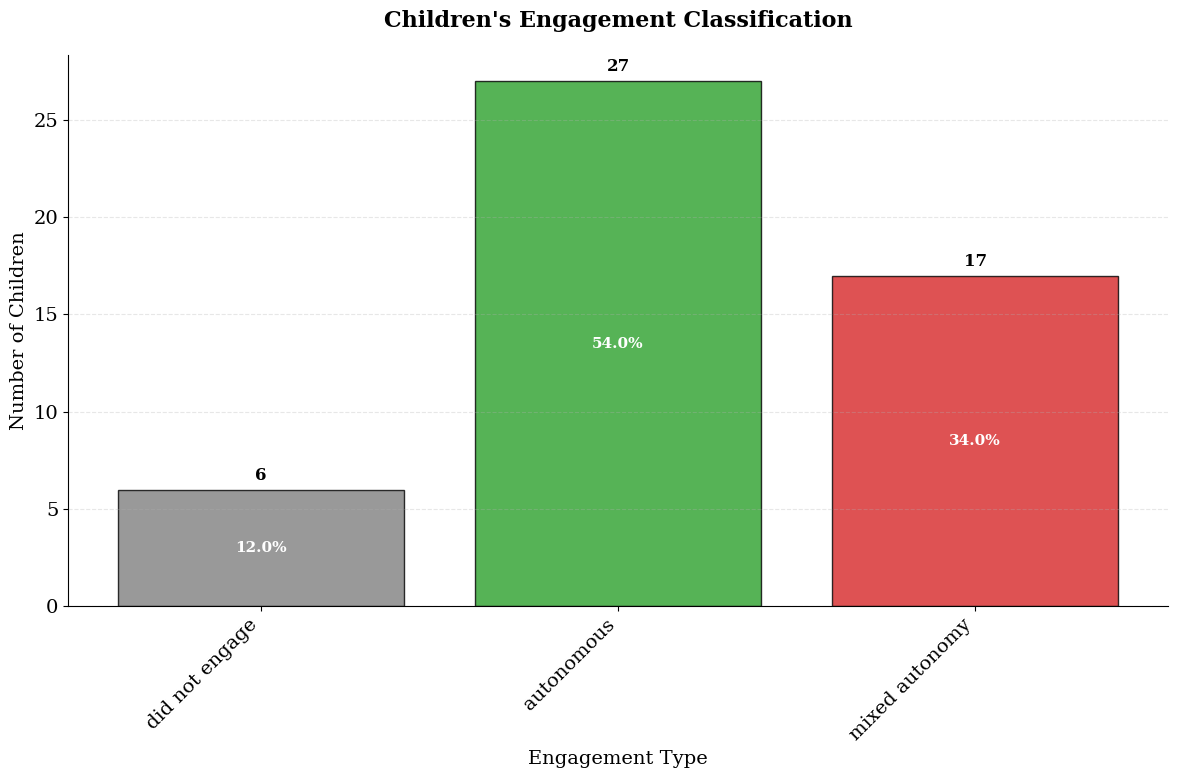

Engagement classification plot saved to 'plots/engagement_classification.png'

2. Analyzing mixed autonomy patterns...

MIXED AUTONOMY PATTERNS ANALYSIS (17 children)

Participant P12:
  Pattern: backup
  Type: mixed throughout
  Details: backup(leaves room)

Participant P16:
  Pattern: backup → backup → backup
  Type: mixed throughout
  Details: backup(looks for researcher) → backup(looks for researcher) → backup(looks for researcher)

Participant P20:
  Pattern: backup → autonomy
  Type: backup → autonomy
  Details: backup(stands up) → autonomy(moves closer to robot)

Participant P21:
  Pattern: backup
  Type: mixed throughout
  Details: backup(looks for researcher)

Participant P22:
  Pattern: backup → backup → backup → backup
  Type: mixed throughout
  Details: backup(looks for researcher) → backup(looks for researcher) → backup(looks for researcher) → backup(looks for researcher)

Participant P24:
  Pattern: backup
  Type: mixed throughout
  Details: backup(leaves room)

Participa

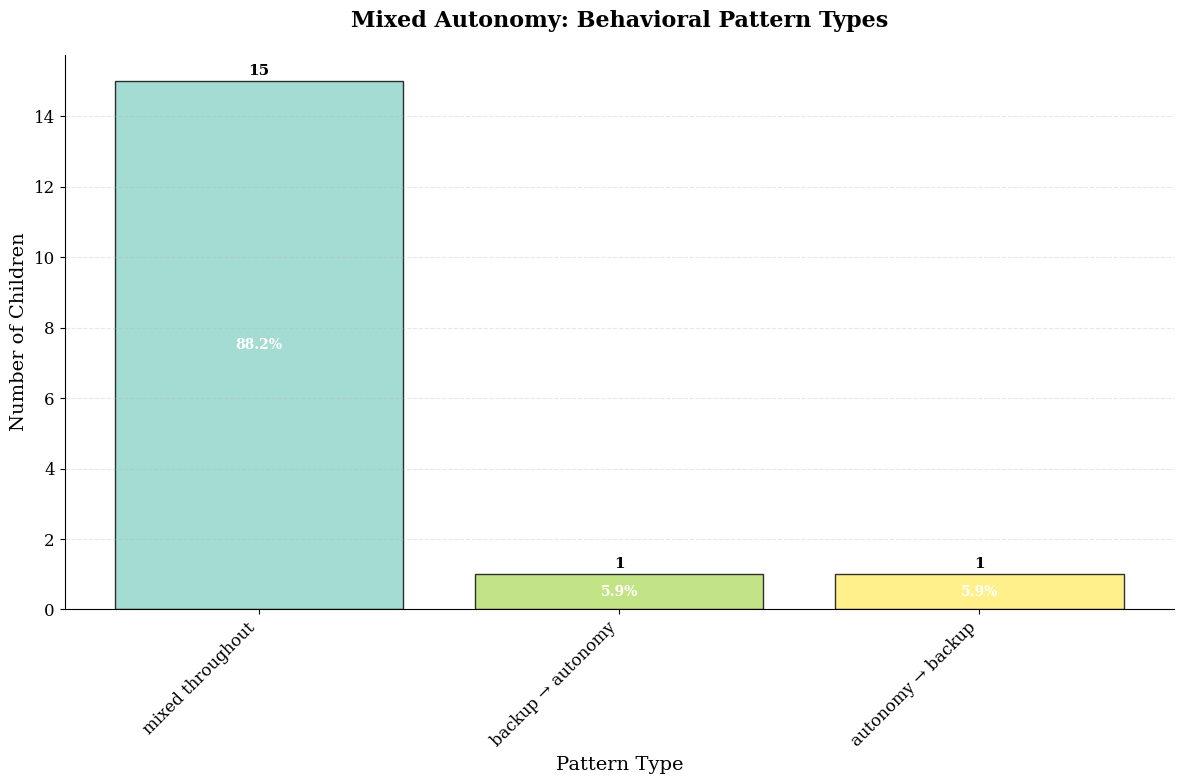

Mixed autonomy patterns saved to 'plots/mixed_autonomy_patterns.png'


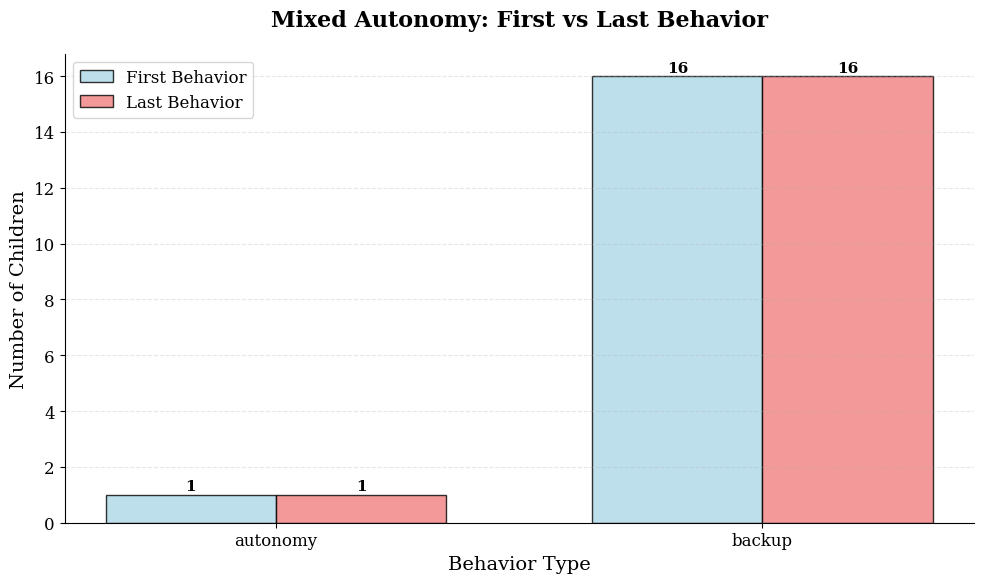

Mixed autonomy first/last behavior plot saved to 'plots/mixed_autonomy_first_last.png'

DETAILED ENGAGEMENT ANALYSIS SUMMARY

Total participants analyzed: 50

Engagement Classification:
  autonomous: 27 children (54.0%)
  mixed autonomy: 17 children (34.0%)
  did not engage: 6 children (12.0%)

------------------------------------------------------------
DETAILED BREAKDOWN BY GROUP
------------------------------------------------------------

AUTONOMOUS (27 children):
  - Autonomy behaviors observed:
    moves closer to robot: 8 children

MIXED AUTONOMY (17 children):
  - Shows both autonomy and help-seeking behaviors
  - Behavioral patterns:
    mixed throughout: 15 children
    backup → autonomy: 1 children
    autonomy → backup: 1 children

DID NOT ENGAGE (6 children):
  - No reprompting or verbal tone behaviors observed

Engagement classification results saved to 'engagement_classification_results.csv'
Mixed autonomy patterns saved to 'mixed_autonomy_patterns.csv'


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_engagement_patterns():
    """Analyze engagement patterns focusing on autonomy and help-seeking behaviors"""
    
    # Read the reactions data
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} reactions from {data['participant_id'].nunique()} participants")
    
    # Get category lists
    reprompting_subcodes = categories["reprompting strategies"]
    verbal_tone_subcodes = categories["verbal tone or cadence"] 
    autonomy_subcodes = engagement_categories["autonomy"]
    calls_for_backup_subcodes = engagement_categories["calls for backup"]
    
    print(f"Reprompting subcodes: {reprompting_subcodes}")
    print(f"Verbal tone subcodes: {verbal_tone_subcodes}")
    print(f"Autonomy subcodes: {autonomy_subcodes}")
    print(f"Calls for backup subcodes: {calls_for_backup_subcodes}")
    
    # Analyze each participant
    participants = data['participant_id'].unique()
    engagement_results = []
    
    for participant in participants:
        participant_data = data[data['participant_id'] == participant]
        participant_subcodes = set(participant_data['subcode_readable'].tolist())
        
        # Step 1: Check if participant engaged (has reprompting OR verbal tone behaviors)
        has_reprompting = bool(participant_subcodes.intersection(set(reprompting_subcodes)))
        has_verbal_tone = bool(participant_subcodes.intersection(set(verbal_tone_subcodes)))
        engaged = has_reprompting or has_verbal_tone
        
        if not engaged:
            classification = "did not engage"
            autonomy_behaviors = []
            backup_behaviors = []
        else:
            # Step 2: Check for autonomy and backup behaviors
            has_autonomy = bool(participant_subcodes.intersection(set(autonomy_subcodes))) or has_verbal_tone or has_reprompting
            has_backup = bool(participant_subcodes.intersection(set(calls_for_backup_subcodes)))
            
            # Get specific behaviors
            autonomy_behaviors = list(participant_subcodes.intersection(set(autonomy_subcodes)))
            backup_behaviors = list(participant_subcodes.intersection(set(calls_for_backup_subcodes)))
            
            # Classify based on autonomy/backup patterns
            if has_autonomy and has_backup:
                classification = "mixed autonomy"
            elif has_autonomy:
                classification = "autonomous"
            elif has_backup:
                classification = "help seeking"
            else:
                classification = "autonomous"  # Engaged but no autonomy/backup behaviors
        
        engagement_results.append({
            'participant_id': participant,
            'classification': classification,
            'engaged': engaged,
            'has_reprompting': has_reprompting,
            'has_verbal_tone': has_verbal_tone,
            'has_autonomy': has_autonomy if engaged else False,
            'has_backup': has_backup if engaged else False,
            'autonomy_behaviors': autonomy_behaviors,
            'backup_behaviors': backup_behaviors,
            'all_subcodes': list(participant_subcodes)
        })
        
        print(f"Participant {participant}: {classification}")
        if classification == "mixed autonomy":
            print(f"  Autonomy: {autonomy_behaviors}")
            print(f"  Backup: {backup_behaviors}")
    
    engagement_df = pd.DataFrame(engagement_results)
    
    # Count classifications
    classification_counts = engagement_df['classification'].value_counts()
    
    print(f"\n" + "="*60)
    print("ENGAGEMENT CLASSIFICATION RESULTS")
    print("="*60)
    
    total_participants = len(engagement_df)
    for classification, count in classification_counts.items():
        percentage = (count / total_participants) * 100
        print(f"{classification}: {count} children ({percentage:.1f}%)")
    
    return engagement_df, classification_counts

def plot_engagement_classification(engagement_df, classification_counts):
    """Plot engagement classification results"""
    
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Define desired order and colors
    desired_order = ["did not engage", "autonomous", "help seeking", "mixed autonomy", "engaged only"]
    colors = ['#808080', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd']  # Grey, Green, Orange, Red, Purple
    
    # Filter to only show categories that exist in data
    existing_classifications = []
    existing_counts = []
    existing_colors = []
    
    for i, classification in enumerate(desired_order):
        if classification in classification_counts.index:
            existing_classifications.append(classification)
            existing_counts.append(classification_counts[classification])
            existing_colors.append(colors[i])
    
    # Create bar plot
    bars = plt.bar(range(len(existing_classifications)), existing_counts, 
                   color=existing_colors, edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add value labels on bars
    for bar, count in zip(bars, existing_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Customize plot
    plt.title('Children\'s Engagement Classification', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Engagement Type', fontsize=14)
    plt.ylabel('Number of Children', fontsize=14)
    plt.xticks(range(len(existing_classifications)), existing_classifications, rotation=45, ha='right')
    
    # Add percentage labels
    total_participants = len(engagement_df)
    for i, (bar, count) in enumerate(zip(bars, existing_counts)):
        percentage = (count / total_participants) * 100
        plt.text(i, count/2, f'{percentage:.1f}%', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/engagement_classification.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Engagement classification plot saved to 'plots/engagement_classification.png'")

def analyze_mixed_autonomy_patterns(engagement_df):
    """Analyze behavioral patterns for children with mixed autonomy"""
    
    # Filter to mixed autonomy children
    mixed_autonomy_children = engagement_df[engagement_df['classification'] == 'mixed autonomy']
    
    if len(mixed_autonomy_children) == 0:
        print("No children with mixed autonomy found.")
        return None
    
    print(f"\n" + "="*80)
    print(f"MIXED AUTONOMY PATTERNS ANALYSIS ({len(mixed_autonomy_children)} children)")
    print("="*80)
    
    # Load full reaction data to analyze sequences
    data = pd.read_csv('reactions_between_errors.csv')
    
    autonomy_subcodes = set(engagement_categories["autonomy"])
    backup_subcodes = set(engagement_categories["calls for backup"])
    
    pattern_results = []
    
    for _, child_info in mixed_autonomy_children.iterrows():
        participant_id = child_info['participant_id']
        
        # Get all reactions for this participant in chronological order
        participant_data = data[data['participant_id'] == participant_id].sort_values(['error', 'start'])
        
        # Create sequence of autonomy/backup behaviors
        behavioral_sequence = []
        detailed_sequence = []
        
        for _, reaction in participant_data.iterrows():
            subcode = reaction['subcode_readable']
            
            if subcode in autonomy_subcodes:
                behavioral_sequence.append('autonomy')
                detailed_sequence.append(f"autonomy({subcode})")
            elif subcode in backup_subcodes:
                behavioral_sequence.append('backup')
                detailed_sequence.append(f"backup({subcode})")
        
        # Analyze the pattern
        if len(behavioral_sequence) > 0:
            pattern_summary = " → ".join(behavioral_sequence)
            detailed_pattern = " → ".join(detailed_sequence)
            
            # Determine dominant pattern
            if behavioral_sequence[0] == 'autonomy' and 'backup' in behavioral_sequence:
                if behavioral_sequence[-1] == 'backup':
                    pattern_type = "autonomy → backup"
                else:
                    pattern_type = "autonomy → backup → autonomy"
            elif behavioral_sequence[0] == 'backup' and 'autonomy' in behavioral_sequence:
                if behavioral_sequence[-1] == 'autonomy':
                    pattern_type = "backup → autonomy" 
                else:
                    pattern_type = "backup → autonomy → backup"
            else:
                pattern_type = "mixed throughout"
            
            pattern_results.append({
                'participant_id': participant_id,
                'pattern_summary': pattern_summary,
                'detailed_pattern': detailed_pattern,
                'pattern_type': pattern_type,
                'first_behavior': behavioral_sequence[0],
                'last_behavior': behavioral_sequence[-1],
                'total_autonomy': behavioral_sequence.count('autonomy'),
                'total_backup': behavioral_sequence.count('backup')
            })
            
            print(f"\nParticipant {participant_id}:")
            print(f"  Pattern: {pattern_summary}")
            print(f"  Type: {pattern_type}")
            print(f"  Details: {detailed_pattern}")
    
    if pattern_results:
        patterns_df = pd.DataFrame(pattern_results)
        
        # Count pattern types
        pattern_type_counts = patterns_df['pattern_type'].value_counts()
        
        print(f"\n" + "="*60)
        print("MIXED AUTONOMY PATTERN SUMMARY")
        print("="*60)
        
        for pattern_type, count in pattern_type_counts.items():
            percentage = (count / len(pattern_results)) * 100
            print(f"{pattern_type}: {count} children ({percentage:.1f}%)")
        
        return patterns_df, pattern_type_counts
    
    return None, None

def plot_mixed_autonomy_patterns(patterns_df, pattern_type_counts):
    """Plot mixed autonomy pattern analysis"""
    
    if patterns_df is None or len(patterns_df) == 0:
        print("No mixed autonomy patterns to plot.")
        return
    
    # Plot 1: Pattern types
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(pattern_type_counts)))
    
    bars = plt.bar(range(len(pattern_type_counts)), pattern_type_counts.values,
                   color=colors, edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add value labels
    for bar, count in zip(bars, pattern_type_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Mixed Autonomy: Behavioral Pattern Types', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Pattern Type', fontsize=14)
    plt.ylabel('Number of Children', fontsize=14)
    plt.xticks(range(len(pattern_type_counts)), pattern_type_counts.index, rotation=45, ha='right')
    
    # Add percentage labels
    total_mixed = len(patterns_df)
    for i, (bar, count) in enumerate(zip(bars, pattern_type_counts.values)):
        percentage = (count / total_mixed) * 100
        plt.text(i, count/2, f'{percentage:.1f}%', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/mixed_autonomy_patterns.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Mixed autonomy patterns saved to 'plots/mixed_autonomy_patterns.png'")
    
    # Plot 2: First vs Last Behavior
    plt.figure(figsize=(10, 6), facecolor='white')
    
    first_behavior_counts = patterns_df['first_behavior'].value_counts()
    last_behavior_counts = patterns_df['last_behavior'].value_counts()
    
    behaviors = ['autonomy', 'backup']
    first_counts = [first_behavior_counts.get(b, 0) for b in behaviors]
    last_counts = [last_behavior_counts.get(b, 0) for b in behaviors]
    
    x = np.arange(len(behaviors))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, first_counts, width, label='First Behavior', 
                   color='lightblue', edgecolor='black', alpha=0.8)
    bars2 = plt.bar(x + width/2, last_counts, width, label='Last Behavior',
                   color='lightcoral', edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                        str(int(height)), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Mixed Autonomy: First vs Last Behavior', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Behavior Type', fontsize=14)
    plt.ylabel('Number of Children', fontsize=14)
    plt.xticks(x, behaviors)
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/mixed_autonomy_first_last.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Mixed autonomy first/last behavior plot saved to 'plots/mixed_autonomy_first_last.png'")

def create_detailed_summary(engagement_df, patterns_df):
    """Create detailed summary of engagement analysis"""
    
    print(f"\n" + "="*100)
    print("DETAILED ENGAGEMENT ANALYSIS SUMMARY")
    print("="*100)
    
    total_participants = len(engagement_df)
    
    # Overall engagement statistics
    classification_counts = engagement_df['classification'].value_counts()
    
    print(f"\nTotal participants analyzed: {total_participants}")
    print(f"\nEngagement Classification:")
    for classification, count in classification_counts.items():
        percentage = (count / total_participants) * 100
        print(f"  {classification}: {count} children ({percentage:.1f}%)")
    
    # Detailed breakdown for each group
    print(f"\n" + "-"*60)
    print("DETAILED BREAKDOWN BY GROUP")
    print("-"*60)
    
    for classification in classification_counts.index:
        group_data = engagement_df[engagement_df['classification'] == classification]
        print(f"\n{classification.upper()} ({len(group_data)} children):")
        
        if classification == "did not engage":
            print("  - No reprompting or verbal tone behaviors observed")
            
        elif classification == "autonomous":
            autonomy_behaviors = []
            for _, child in group_data.iterrows():
                autonomy_behaviors.extend(child['autonomy_behaviors'])
            behavior_counts = Counter(autonomy_behaviors)
            print("  - Autonomy behaviors observed:")
            for behavior, count in behavior_counts.items():
                print(f"    {behavior}: {count} children")
                
        elif classification == "help seeking":
            backup_behaviors = []
            for _, child in group_data.iterrows():
                backup_behaviors.extend(child['backup_behaviors'])
            behavior_counts = Counter(backup_behaviors)
            print("  - Help-seeking behaviors observed:")
            for behavior, count in behavior_counts.items():
                print(f"    {behavior}: {count} children")
                
        elif classification == "mixed autonomy" and patterns_df is not None:
            print("  - Shows both autonomy and help-seeking behaviors")
            pattern_summary = patterns_df['pattern_type'].value_counts()
            print("  - Behavioral patterns:")
            for pattern, count in pattern_summary.items():
                print(f"    {pattern}: {count} children")

# Run the analysis
print("Analyzing engagement patterns...")
engagement_df, classification_counts = analyze_engagement_patterns()

# Plot engagement classification
print("\n1. Creating engagement classification plot...")
plot_engagement_classification(engagement_df, classification_counts)

# Analyze mixed autonomy patterns
print("\n2. Analyzing mixed autonomy patterns...")
patterns_df, pattern_type_counts = analyze_mixed_autonomy_patterns(engagement_df)

if patterns_df is not None:
    print("\n3. Creating mixed autonomy pattern plots...")
    plot_mixed_autonomy_patterns(patterns_df, pattern_type_counts)

# Create detailed summary
create_detailed_summary(engagement_df, patterns_df)

# Save results
engagement_df.to_csv('engagement_classification_results.csv', index=False)
print(f"\nEngagement classification results saved to 'engagement_classification_results.csv'")

if patterns_df is not None:
    patterns_df.to_csv('mixed_autonomy_patterns.csv', index=False)
    print(f"Mixed autonomy patterns saved to 'mixed_autonomy_patterns.csv'")

Analyzing reaction patterns...
Loaded 425 reactions from 50 participants
Created sequences for 50 participants

TOP 3 MOST COMMON CATEGORY PATTERNS
1. disengagement -> disengagement -> disengagement
   Count: 15 participants (30.0%)

2. disengagement -> disengagement -> emotion
   Count: 4 participants (8.0%)

3. disengagement -> emotion -> disengagement
   Count: 3 participants (6.0%)


TOP 3 MOST COMMON SUBCODE PATTERNS
1. looks at robot -> looks at robot -> looks at robot
   Count: 5 participants (10.0%)

2. looks at robot -> confusion -> looks at PC
   Count: 2 participants (4.0%)

3. interrogative tone -> frustration -> frustration
   Count: 1 participants (2.0%)


Analyzing complete reaction sequences...

ANALYZING COMPLETE REACTION SEQUENCES (ALL REACTIONS PER PARTICIPANT)
Found 50 unique subcode patterns
Found 49 unique category patterns

1. Creating complete reaction pattern plots...


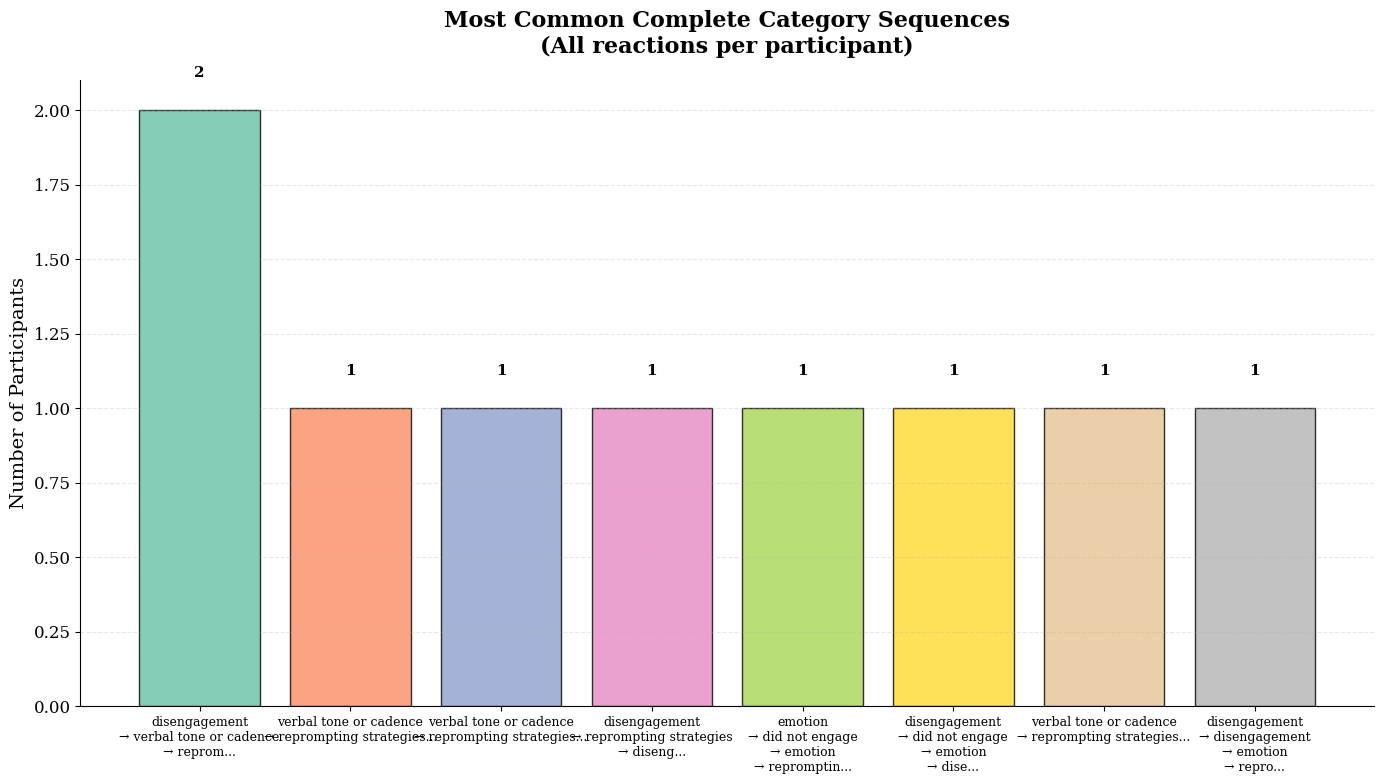

Complete category sequences saved to 'plots/complete_category_sequences.png'


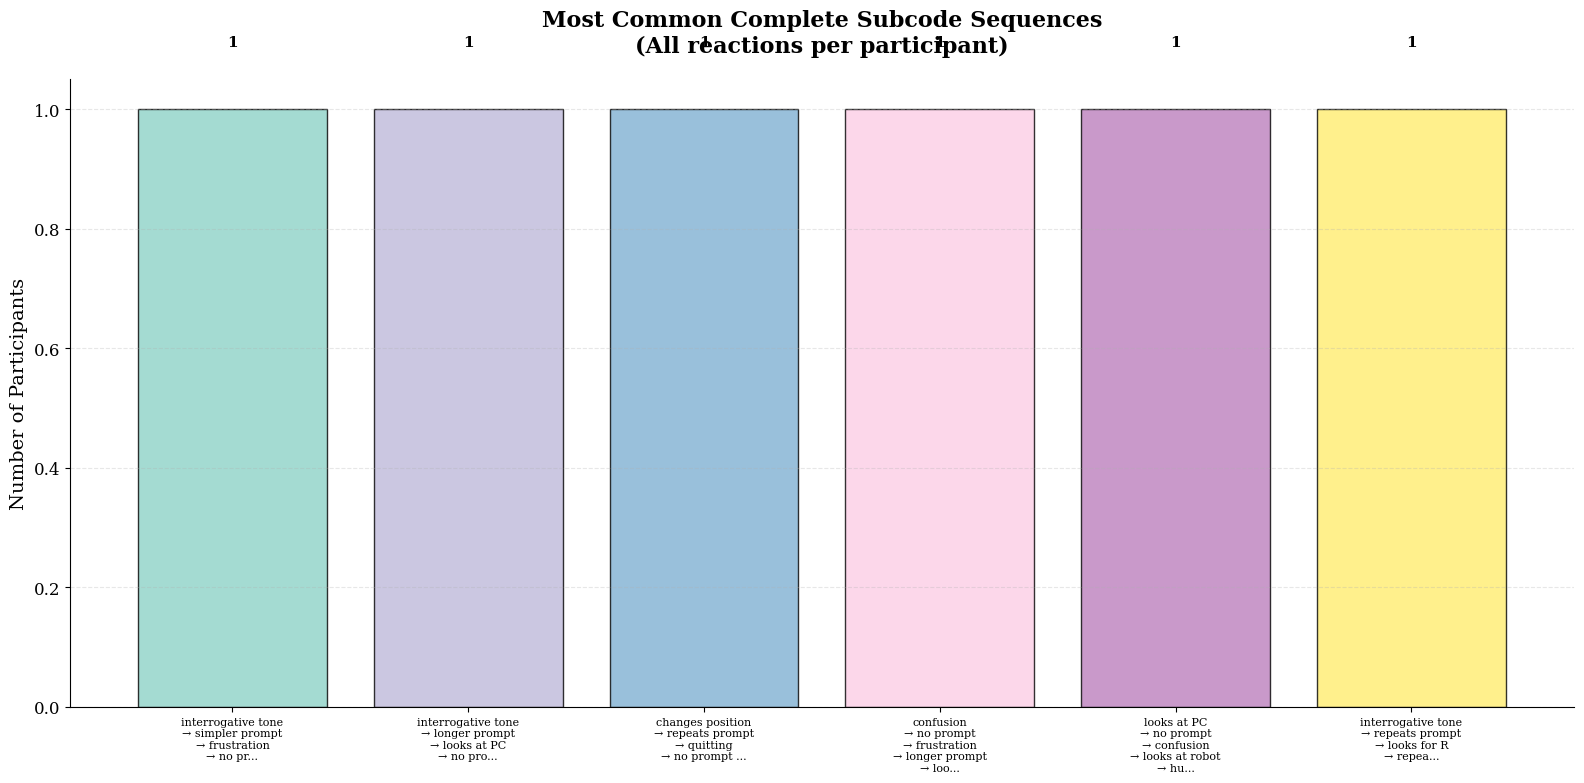

Complete subcode sequences saved to 'plots/complete_subcode_sequences.png'

TOP COMPLETE CATEGORY PATTERNS
1. disengagement → verbal tone or cadence → reprompting strategies → disengagement → verbal tone or cadence → reprompting strategies → disengagement → verbal tone or cadence → reprompting strategies
   Count: 2 participants (4.0%)

2. verbal tone or cadence → reprompting strategies → emotion → did not engage → emotion → disengagement → reprompting strategies → emotion → verbal tone or cadence → reprompting strategies
   Count: 1 participants (2.0%)

3. verbal tone or cadence → reprompting strategies → disengagement → did not engage → emotion → disengagement → emotion → reprompting strategies → reprompting strategies
   Count: 1 participants (2.0%)

4. disengagement → reprompting strategies → disengagement → did not engage → disengagement → reprompting strategies → emotion → did not engage → reprompting strategies
   Count: 1 participants (2.0%)

5. emotion → did not engage → emoti

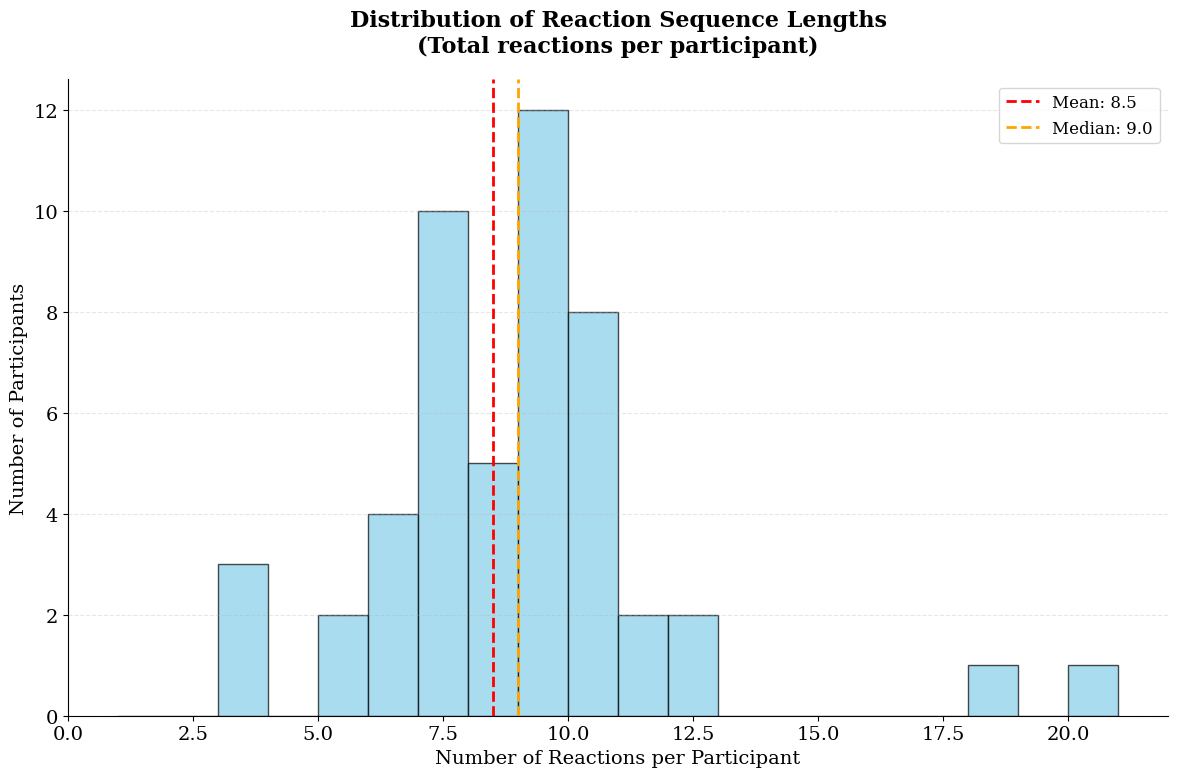

Sequence length distribution saved to 'plots/sequence_length_distribution.png'

Sequence Length Statistics:
  Mean reactions per participant: 8.5
  Median reactions per participant: 9.0
  Min reactions: 3
  Max reactions: 20
  Total participants: 50

3. Creating top category patterns plot (error-by-error)...


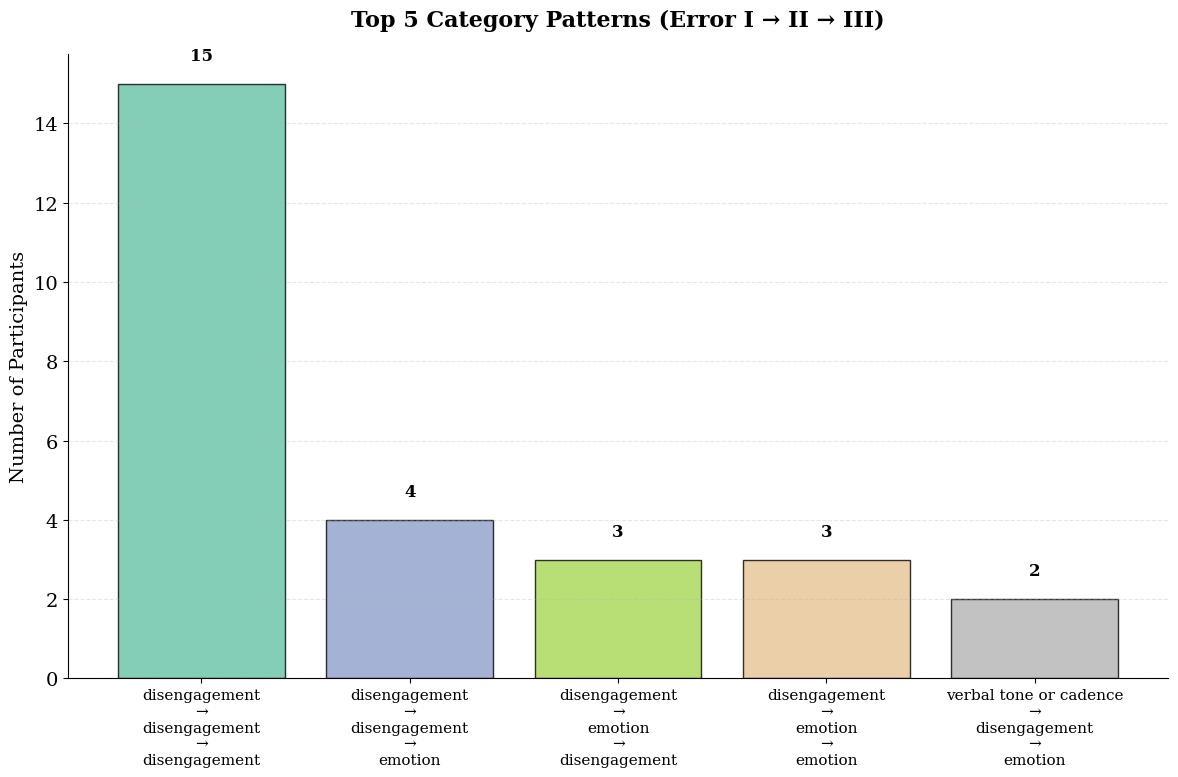

Top category patterns saved to 'plots/top_category_patterns.png'

4. Creating top subcode patterns plot (error-by-error)...


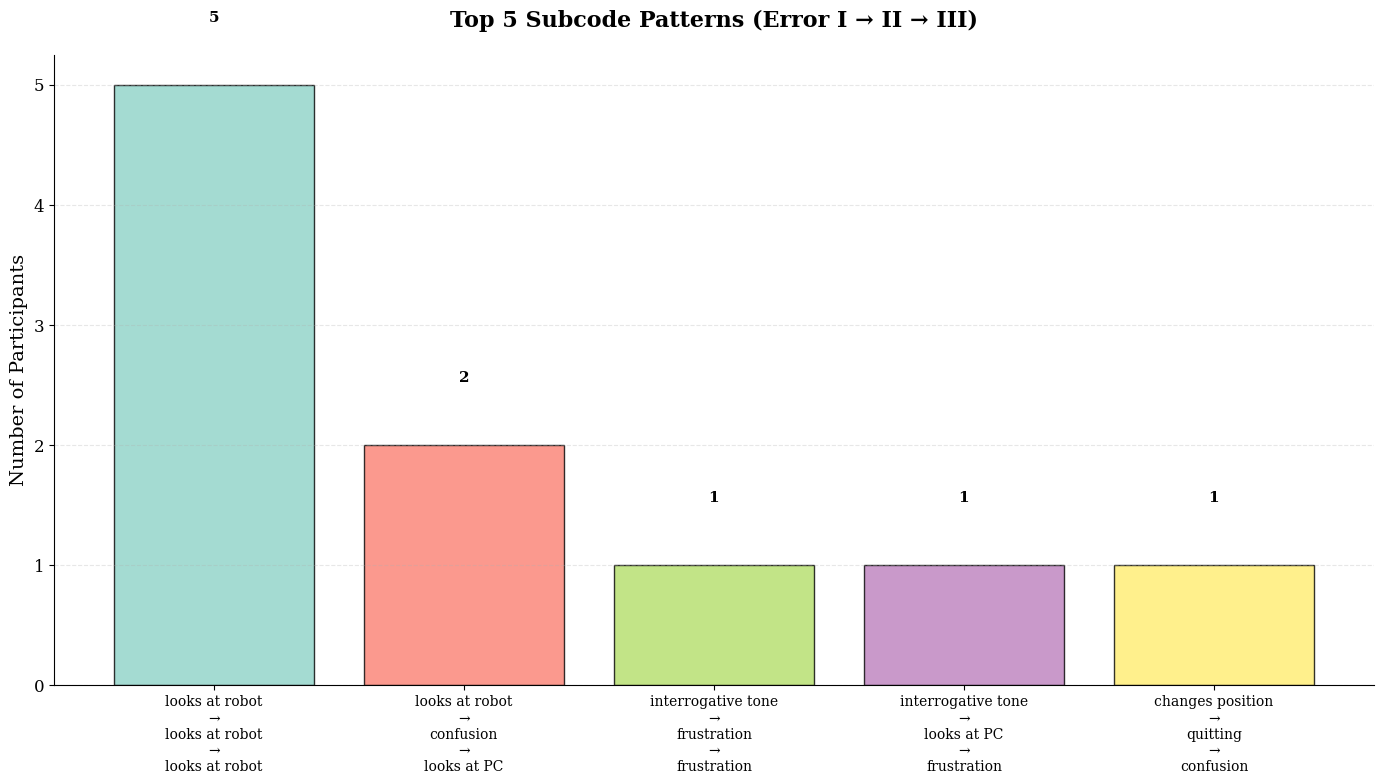

Top subcode patterns saved to 'plots/top_subcode_patterns.png'

5. Creating category by error position plot...


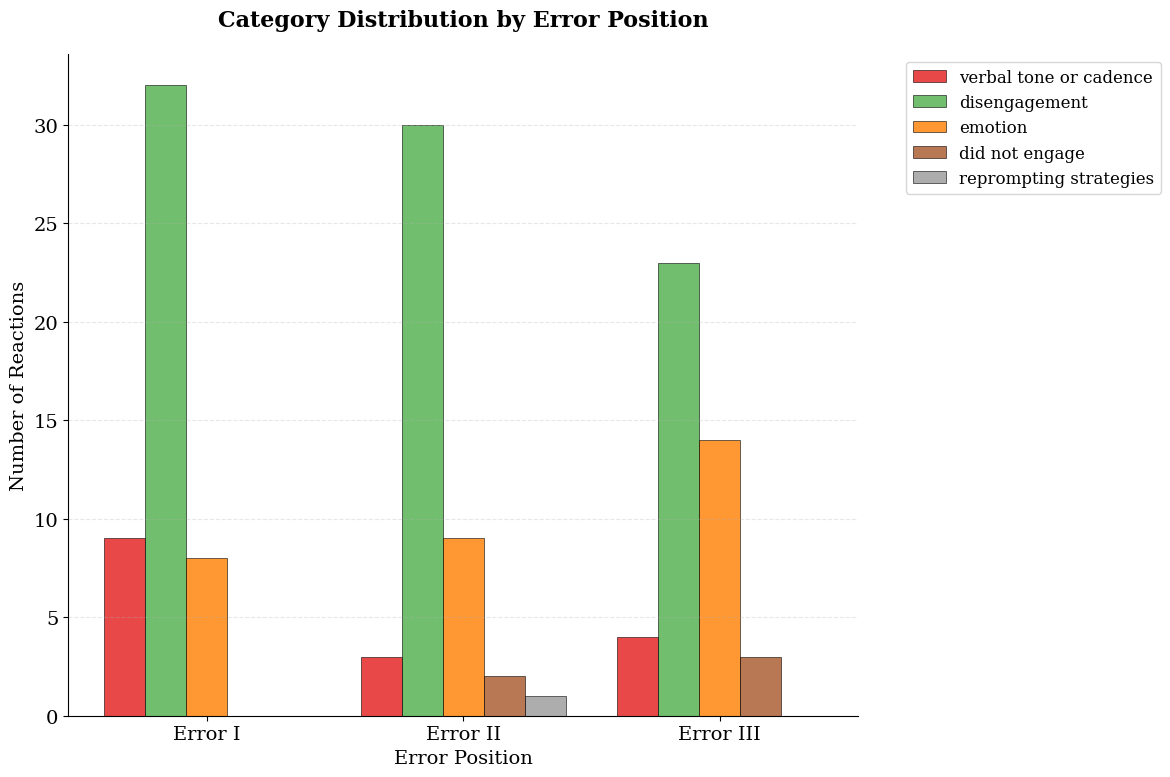

Category by error position saved to 'plots/category_by_error_position.png'

6. Creating pattern diversity plot...


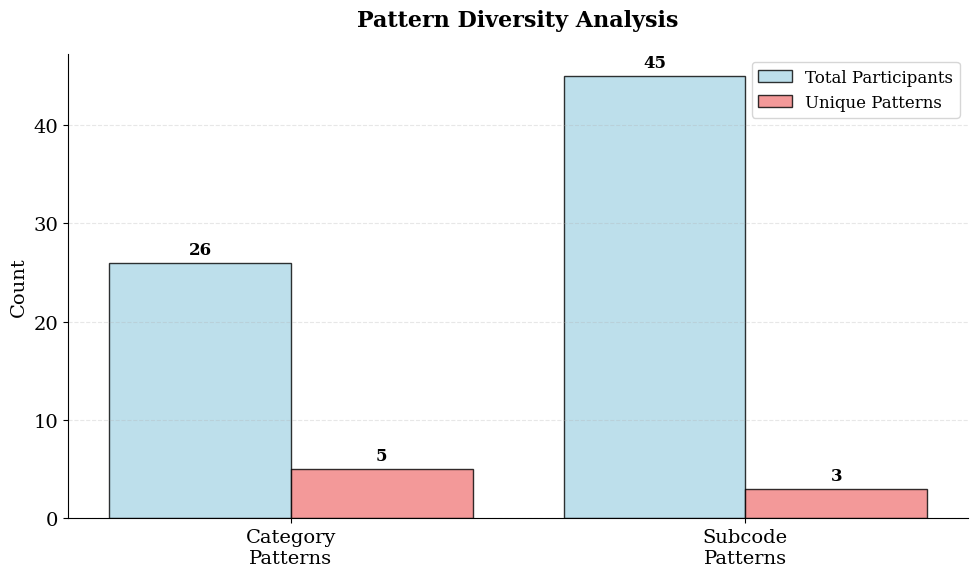

Pattern diversity saved to 'plots/pattern_diversity.png'

7. Creating vertical flow diagram...

VERTICAL FLOW ANALYSIS - TOP 3 CATEGORY PATTERNS
Pattern 1: disengagement -> disengagement -> disengagement (15 children)
Pattern 2: disengagement -> disengagement -> emotion (4 children)
Pattern 3: disengagement -> emotion -> disengagement (3 children)


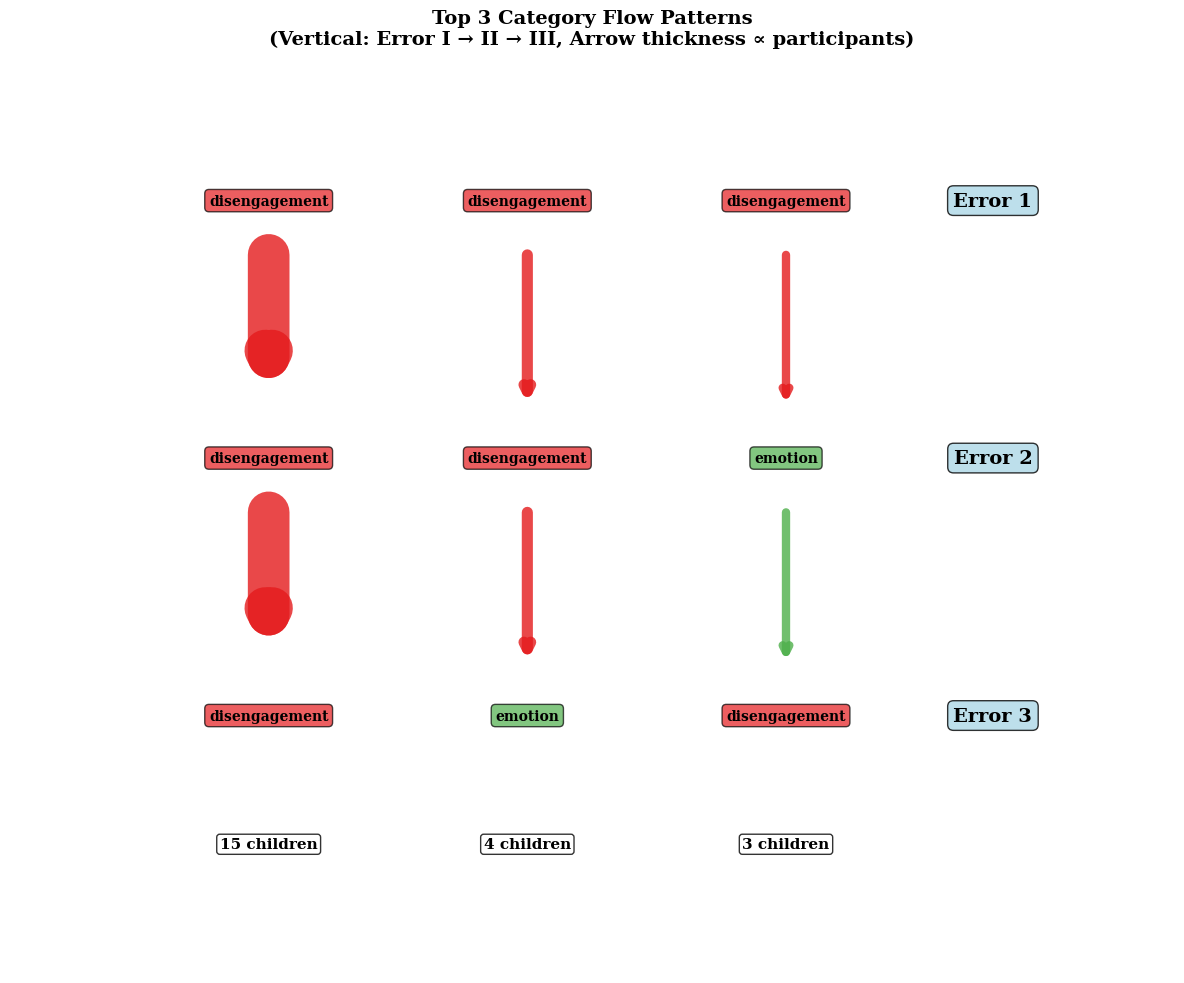

Vertical flow diagram saved to 'plots/vertical_flow_diagram.png'

Detailed pattern results saved to 'reaction_patterns_results.csv'


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

def map_subcode_to_category(subcode):
    """Map a subcode to its category"""
    for category, subcodes in categories.items():
        if subcode in subcodes:
            return category
    return "other"

def analyze_reaction_patterns():
    """Analyze the most common reaction patterns across errors"""
    
    # Read the reactions data
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} reactions from {data['participant_id'].nunique()} participants")
    
    # Create sequences for each participant
    participant_sequences = {}
    participant_category_sequences = {}
    
    participants = data['participant_id'].unique()
    
    for participant in participants:
        participant_data = data[data['participant_id'] == participant].sort_values(['error', 'start'])
        
        # Create subcode sequence
        subcode_sequence = []
        category_sequence = []
        
        for error in [1, 2, 3]:
            error_reactions = participant_data[participant_data['error'] == error]
            
            if len(error_reactions) > 0:
                # Take first reaction in each error (or could be all, or most common)
                first_reaction = error_reactions.iloc[0]['subcode_readable']
                subcode_sequence.append(first_reaction)
                
                # Map to category
                category = map_subcode_to_category(first_reaction)
                category_sequence.append(category)
            else:
                subcode_sequence.append("no_reaction")
                category_sequence.append("no_reaction")
        
        participant_sequences[participant] = subcode_sequence
        participant_category_sequences[participant] = category_sequence
    
    print(f"Created sequences for {len(participant_sequences)} participants")
    
    # Convert sequences to strings for counting
    subcode_patterns = [" -> ".join(seq) for seq in participant_sequences.values()]
    category_patterns = [" -> ".join(seq) for seq in participant_category_sequences.values()]
    
    # Count most common patterns
    subcode_counter = Counter(subcode_patterns)
    category_counter = Counter(category_patterns)
    
    print(f"\n" + "="*80)
    print("TOP 3 MOST COMMON CATEGORY PATTERNS")
    print("="*80)
    
    for i, (pattern, count) in enumerate(category_counter.most_common(3)):
        percentage = (count / len(participants)) * 100
        print(f"{i+1}. {pattern}")
        print(f"   Count: {count} participants ({percentage:.1f}%)")
        print()
    
    print(f"\n" + "="*80)
    print("TOP 3 MOST COMMON SUBCODE PATTERNS")
    print("="*80)
    
    for i, (pattern, count) in enumerate(subcode_counter.most_common(3)):
        percentage = (count / len(participants)) * 100
        print(f"{i+1}. {pattern}")
        print(f"   Count: {count} participants ({percentage:.1f}%)")
        print()
    
    return {
        'subcode_patterns': subcode_counter,
        'category_patterns': category_counter,
        'participant_sequences': participant_sequences,
        'participant_category_sequences': participant_category_sequences,
        'data': data
    }

def analyze_complete_reaction_sequences(pattern_data):
    """Analyze complete reaction sequences considering all reactions per participant"""
    
    data = pattern_data['data']
    
    print(f"\n" + "="*80)
    print("ANALYZING COMPLETE REACTION SEQUENCES (ALL REACTIONS PER PARTICIPANT)")
    print("="*80)
    
    # Create complete sequences for each participant
    participant_complete_sequences = {}
    participant_complete_category_sequences = {}
    
    participants = data['participant_id'].unique()
    
    for participant in participants:
        participant_data = data[data['participant_id'] == participant].sort_values(['error', 'start'])
        
        # Get all reactions in chronological order
        all_subcodes = participant_data['subcode_readable'].tolist()
        all_categories = [map_subcode_to_category(subcode) for subcode in all_subcodes]
        
        participant_complete_sequences[participant] = all_subcodes
        participant_complete_category_sequences[participant] = all_categories
    
    # Convert sequences to strings for counting
    complete_subcode_patterns = [" → ".join(seq) for seq in participant_complete_sequences.values() if len(seq) > 0]
    complete_category_patterns = [" → ".join(seq) for seq in participant_complete_category_sequences.values() if len(seq) > 0]
    
    # Count most common patterns
    complete_subcode_counter = Counter(complete_subcode_patterns)
    complete_category_counter = Counter(complete_category_patterns)
    
    print(f"Found {len(complete_subcode_counter)} unique subcode patterns")
    print(f"Found {len(complete_category_counter)} unique category patterns")
    
    return {
        'complete_subcode_patterns': complete_subcode_counter,
        'complete_category_patterns': complete_category_counter,
        'participant_complete_sequences': participant_complete_sequences,
        'participant_complete_category_sequences': participant_complete_category_sequences
    }

def plot_complete_reaction_patterns(complete_data):
    """Plot most common complete reaction patterns"""
    
    category_counter = complete_data['complete_category_patterns']
    subcode_counter = complete_data['complete_subcode_patterns']
    
    # Plot 1: Top Complete Category Patterns
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    top_categories = category_counter.most_common(8)  # Show more since patterns are longer
    
    # Truncate very long patterns for display
    cat_patterns = []
    cat_counts = [count for _, count in top_categories]
    
    for pattern, _ in top_categories:
        if len(pattern) > 50:  # Truncate long patterns
            truncated = pattern[:47] + "..."
        else:
            truncated = pattern
        # Replace arrows with line breaks for better readability
        truncated = truncated.replace(" → ", "\n→ ")
        cat_patterns.append(truncated)
    
    bars = plt.bar(range(len(cat_patterns)), cat_counts, 
                   color=plt.cm.Set2(np.linspace(0, 1, len(cat_patterns))),
                   edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add count labels on bars
    for bar, count in zip(bars, cat_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Most Common Complete Category Sequences\n(All reactions per participant)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.xticks(range(len(cat_patterns)), cat_patterns, fontsize=9, rotation=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/complete_category_sequences.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Complete category sequences saved to 'plots/complete_category_sequences.png'")
    
    # Plot 2: Top Complete Subcode Patterns  
    plt.figure(figsize=(16, 8), facecolor='white')
    
    top_subcodes = subcode_counter.most_common(6)  # Fewer since subcode patterns are longer
    
    sub_patterns = []
    sub_counts = [count for _, count in top_subcodes]
    
    for pattern, _ in top_subcodes:
        # Shorten long subcode names and truncate very long patterns
        shortened = pattern.replace("more specific/longer prompt", "longer prompt")
        shortened = shortened.replace("amusement/humor", "humor")
        shortened = shortened.replace("speaks to researcher", "speaks to R")
        shortened = shortened.replace("looks for researcher", "looks for R")
        
        if len(shortened) > 60:  # Truncate very long patterns
            shortened = shortened[:57] + "..."
        
        # Replace arrows with line breaks
        shortened = shortened.replace(" → ", "\n→ ")
        sub_patterns.append(shortened)
    
    bars = plt.bar(range(len(sub_patterns)), sub_counts,
                   color=plt.cm.Set3(np.linspace(0, 1, len(sub_patterns))),
                   edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add count labels
    for bar, count in zip(bars, sub_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Most Common Complete Subcode Sequences\n(All reactions per participant)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.xticks(range(len(sub_patterns)), sub_patterns, fontsize=8, rotation=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/complete_subcode_sequences.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Complete subcode sequences saved to 'plots/complete_subcode_sequences.png'")
    
    # Print detailed statistics
    print(f"\n" + "="*80)
    print("TOP COMPLETE CATEGORY PATTERNS")
    print("="*80)
    
    total_participants = len(complete_data['participant_complete_category_sequences'])
    for i, (pattern, count) in enumerate(category_counter.most_common(5)):
        percentage = (count / total_participants) * 100
        print(f"{i+1}. {pattern}")
        print(f"   Count: {count} participants ({percentage:.1f}%)")
        print()
    
    print(f"\n" + "="*80)
    print("TOP COMPLETE SUBCODE PATTERNS")
    print("="*80)
    
    for i, (pattern, count) in enumerate(subcode_counter.most_common(5)):
        percentage = (count / total_participants) * 100
        print(f"{i+1}. {pattern}")
        print(f"   Count: {count} participants ({percentage:.1f}%)")
        print()

def plot_sequence_length_analysis(complete_data):
    """Analyze and plot sequence length distributions"""
    
    participant_sequences = complete_data['participant_complete_sequences']
    
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Calculate sequence lengths
    sequence_lengths = [len(seq) for seq in participant_sequences.values()]
    
    # Create histogram
    plt.hist(sequence_lengths, bins=range(1, max(sequence_lengths) + 2), 
             alpha=0.7, color='skyblue', edgecolor='black', linewidth=1)
    
    # Add statistics
    mean_length = np.mean(sequence_lengths)
    median_length = np.median(sequence_lengths)
    
    plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
    plt.axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.1f}')
    
    plt.title('Distribution of Reaction Sequence Lengths\n(Total reactions per participant)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Reactions per Participant', fontsize=14)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/sequence_length_distribution.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Sequence length distribution saved to 'plots/sequence_length_distribution.png'")
    
    print(f"\nSequence Length Statistics:")
    print(f"  Mean reactions per participant: {mean_length:.1f}")
    print(f"  Median reactions per participant: {median_length:.1f}")
    print(f"  Min reactions: {min(sequence_lengths)}")
    print(f"  Max reactions: {max(sequence_lengths)}")
    print(f"  Total participants: {len(sequence_lengths)}")

def plot_top_category_patterns(pattern_data):
    """Plot top category patterns"""
    
    category_counter = pattern_data['category_patterns']
    
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    top_categories = category_counter.most_common(5)
    cat_patterns = [pattern.replace(" -> ", "\n→\n") for pattern, _ in top_categories]
    cat_counts = [count for _, count in top_categories]
    
    bars = plt.bar(range(len(cat_patterns)), cat_counts, 
                   color=plt.cm.Set2(np.linspace(0, 1, len(cat_patterns))),
                   edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add count labels on bars
    for bar, count in zip(bars, cat_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.title('Top 5 Category Patterns (Error I → II → III)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.xticks(range(len(cat_patterns)), cat_patterns, fontsize=11)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/top_category_patterns.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Top category patterns saved to 'plots/top_category_patterns.png'")

def plot_top_subcode_patterns(pattern_data):
    """Plot top subcode patterns"""
    
    subcode_counter = pattern_data['subcode_patterns']
    
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    top_subcodes = subcode_counter.most_common(5)
    sub_patterns = []
    sub_counts = [count for _, count in top_subcodes]
    
    for pattern, _ in top_subcodes:
        # Shorten long subcode names for display
        shortened = pattern.replace("more specific/longer prompt", "longer prompt")
        shortened = shortened.replace("amusement/humor", "humor")
        shortened = shortened.replace(" -> ", "\n→\n")
        sub_patterns.append(shortened)
    
    bars = plt.bar(range(len(sub_patterns)), sub_counts,
                   color=plt.cm.Set3(np.linspace(0, 1, len(sub_patterns))),
                   edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add count labels
    for bar, count in zip(bars, sub_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Top 5 Subcode Patterns (Error I → II → III)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Participants', fontsize=14)
    plt.xticks(range(len(sub_patterns)), sub_patterns, fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/top_subcode_patterns.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Top subcode patterns saved to 'plots/top_subcode_patterns.png'")

def plot_category_by_error(pattern_data):
    """Plot category distribution by error position"""
    
    participant_category_sequences = pattern_data['participant_category_sequences']
    
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create matrix of categories by error position
    category_by_error = {1: [], 2: [], 3: []}
    
    for seq in participant_category_sequences.values():
        for error_pos, category in enumerate(seq, 1):
            if error_pos <= 3:
                category_by_error[error_pos].append(category)
    
    # Count categories for each error position
    error_data = []
    for error_pos in [1, 2, 3]:
        cat_counts = Counter(category_by_error[error_pos])
        for cat, count in cat_counts.items():
            if cat != "no_reaction":
                error_data.append({'Error': f'Error {error_pos}', 'Category': cat, 'Count': count})
    
    error_df = pd.DataFrame(error_data)
    
    if len(error_df) > 0:
        # Create grouped bar chart
        categories_list = error_df['Category'].unique()
        x = np.arange(3)  # Error positions
        width = 0.8 / len(categories_list)
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(categories_list)))
        
        for i, (category, color) in enumerate(zip(categories_list, colors)):
            cat_data = error_df[error_df['Category'] == category]
            counts = []
            for error_pos in [1, 2, 3]:
                error_cat_data = cat_data[cat_data['Error'] == f'Error {error_pos}']
                count = error_cat_data['Count'].sum() if len(error_cat_data) > 0 else 0
                counts.append(count)
            
            plt.bar(x + i * width, counts, width, label=category, color=color, 
                   edgecolor='black', linewidth=0.5, alpha=0.8)
        
        plt.title('Category Distribution by Error Position', fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('Number of Reactions', fontsize=14)
        plt.xlabel('Error Position', fontsize=14)
        plt.xticks(x + width * (len(categories_list) - 1) / 2, ['Error I', 'Error II', 'Error III'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.savefig('plots/category_by_error_position.png', format='png', dpi=500, bbox_inches='tight')
        plt.show()
        print("Category by error position saved to 'plots/category_by_error_position.png'")

def plot_pattern_diversity(pattern_data):
    """Plot pattern diversity analysis"""
    
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'serif'})
    
    pattern_lengths = [len(pattern_data['category_patterns']), len(pattern_data['subcode_patterns'])]
    unique_patterns = [len(set(pattern_data['category_patterns'].values())), 
                      len(set(pattern_data['subcode_patterns'].values()))]
    
    x_labels = ['Category\nPatterns', 'Subcode\nPatterns']
    x_pos = np.arange(len(x_labels))
    
    bars_total = plt.bar(x_pos - 0.2, pattern_lengths, 0.4, label='Total Participants', 
                        color='lightblue', edgecolor='black', alpha=0.8)
    bars_unique = plt.bar(x_pos + 0.2, unique_patterns, 0.4, label='Unique Patterns', 
                         color='lightcoral', edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bars in [bars_total, bars_unique]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    str(int(height)), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.title('Pattern Diversity Analysis', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(x_pos, x_labels)
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('plots/pattern_diversity.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Pattern diversity saved to 'plots/pattern_diversity.png'")

def create_vertical_flow_diagram(pattern_data, top_n=3):
    """Create a vertical flow diagram showing the most common patterns"""
    
    category_counter = pattern_data['category_patterns']
    participant_category_sequences = pattern_data['participant_category_sequences']
    
    # Get top N patterns
    top_patterns = category_counter.most_common(top_n)
    
    print(f"\n" + "="*60)
    print(f"VERTICAL FLOW ANALYSIS - TOP {top_n} CATEGORY PATTERNS")
    print("="*60)
    
    plt.figure(figsize=(12, 10), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Define vertical positions for each error stage (top to bottom)
    error_y_positions = {1: 2, 2: 1, 3: 0}  # Error I at top, III at bottom
    
    # Get unique categories and assign colors
    all_categories = set()
    for seq in participant_category_sequences.values():
        all_categories.update(seq)
    all_categories.discard("no_reaction")
    
    category_colors = {}
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_categories)))
    for cat, color in zip(all_categories, colors):
        category_colors[cat] = color
    
    # Calculate x positions for patterns to avoid overlap
    x_positions = np.linspace(-1, 1, top_n)
    
    # Plot flows for top patterns
    for i, (pattern, count) in enumerate(top_patterns):
        steps = pattern.split(" -> ")
        x_center = x_positions[i]
        
        print(f"Pattern {i+1}: {pattern} ({count} children)")
        
        # Draw the flow vertically
        for step_idx in range(len(steps)):
            current_cat = steps[step_idx]
            
            if current_cat != "no_reaction":
                y_pos = error_y_positions[step_idx + 1]
                
                # Draw category box
                bbox_props = dict(boxstyle="round,pad=0.3", 
                                facecolor=category_colors.get(current_cat, 'lightgrey'), 
                                alpha=0.7, edgecolor='black')
                
                plt.text(x_center, y_pos, current_cat, 
                        ha='center', va='center', fontsize=10, fontweight='bold',
                        bbox=bbox_props, wrap=True)
                
                # Draw arrow to next step
                if step_idx < len(steps) - 1:
                    next_cat = steps[step_idx + 1]
                    if next_cat != "no_reaction":
                        next_y = error_y_positions[step_idx + 2]
                        
                        # Arrow from current to next
                        plt.annotate('', xy=(x_center, next_y + 0.2), xytext=(x_center, y_pos - 0.2),
                                    arrowprops=dict(arrowstyle='->', lw=count*2, 
                                                  color=category_colors.get(current_cat, 'grey'),
                                                  alpha=0.8))
        
        # Add pattern count label
        plt.text(x_center, -0.5, f'{count} children', 
                ha='center', va='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
    
    # Add error labels on the right
    for error_num, y_pos in error_y_positions.items():
        plt.text(1.8, y_pos, f'Error {error_num}', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))
    
    plt.xlim(-2, 2.5)
    plt.ylim(-1, 2.5)
    plt.title(f'Top {top_n} Category Flow Patterns\n(Vertical: Error I → II → III, Arrow thickness ∝ participants)', 
             fontsize=14, fontweight='bold', pad=20)
    
    # Remove axes
    plt.xticks([])
    plt.yticks([])
    
    # Remove all spines
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.savefig('plots/vertical_flow_diagram.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    
    print("Vertical flow diagram saved to 'plots/vertical_flow_diagram.png'")

# Run the analysis
print("Analyzing reaction patterns...")
pattern_results = analyze_reaction_patterns()

# Analyze complete reaction sequences
print("\nAnalyzing complete reaction sequences...")
complete_results = analyze_complete_reaction_sequences(pattern_results)

# Create all visualizations as separate figures
print("\n1. Creating complete reaction pattern plots...")
plot_complete_reaction_patterns(complete_results)

print("\n2. Creating sequence length analysis...")
plot_sequence_length_analysis(complete_results)

print("\n3. Creating top category patterns plot (error-by-error)...")
plot_top_category_patterns(pattern_results)

print("\n4. Creating top subcode patterns plot (error-by-error)...")
plot_top_subcode_patterns(pattern_results)

print("\n5. Creating category by error position plot...")
plot_category_by_error(pattern_results)

print("\n6. Creating pattern diversity plot...")
plot_pattern_diversity(pattern_results)

print("\n7. Creating vertical flow diagram...")
create_vertical_flow_diagram(pattern_results, top_n=3)

# Save detailed results including complete sequences
pattern_df = pd.DataFrame([
    {'Pattern': pattern, 'Type': 'Category (Error-by-Error)', 'Count': count, 'Percentage': f"{(count/len(pattern_results['participant_category_sequences']))*100:.1f}%"}
    for pattern, count in pattern_results['category_patterns'].most_common(10)
] + [
    {'Pattern': pattern, 'Type': 'Subcode (Error-by-Error)', 'Count': count, 'Percentage': f"{(count/len(pattern_results['participant_sequences']))*100:.1f}%"}
    for pattern, count in pattern_results['subcode_patterns'].most_common(10)
] + [
    {'Pattern': pattern, 'Type': 'Complete Category Sequence', 'Count': count, 'Percentage': f"{(count/len(complete_results['participant_complete_category_sequences']))*100:.1f}%"}
    for pattern, count in complete_results['complete_category_patterns'].most_common(10)
] + [
    {'Pattern': pattern, 'Type': 'Complete Subcode Sequence', 'Count': count, 'Percentage': f"{(count/len(complete_results['participant_complete_sequences']))*100:.1f}%"}
    for pattern, count in complete_results['complete_subcode_patterns'].most_common(10)
])

pattern_df.to_csv('reaction_patterns_results.csv', index=False)
print("\nDetailed pattern results saved to 'reaction_patterns_results.csv'")

Analyzing top reactions by error...
Loaded 425 reactions from 50 participants

Error 1: 150 total reactions
  Top 3 subcodes: {'repeats prompt': 24, 'looks at robot': 22, 'slower speech': 13}
  Top 3 categories: {'reprompting strategies': 44, 'disengagement': 44, 'verbal tone or cadence': 39}
  Top 3 engagement: {'other': 104, 'autonomy': 29, 'calls for backup': 9}

Error 2: 127 total reactions
  Top 3 subcodes: {'no prompt': 22, 'repeats prompt': 13, 'looks at robot': 13}
  Top 3 categories: {'disengagement': 45, 'reprompting strategies': 26, 'did not engage': 22}
  Top 3 engagement: {'other': 75, 'did not engage': 22, 'autonomy': 16}

Error 3: 148 total reactions
  Top 3 subcodes: {'frustration': 15, 'no prompt': 14, 'repeats prompt': 14}
  Top 3 categories: {'disengagement': 38, 'reprompting strategies': 37, 'verbal tone or cadence': 31}
  Top 3 engagement: {'other': 104, 'autonomy': 19, 'did not engage': 14}

1. Creating top subcodes by error plot...


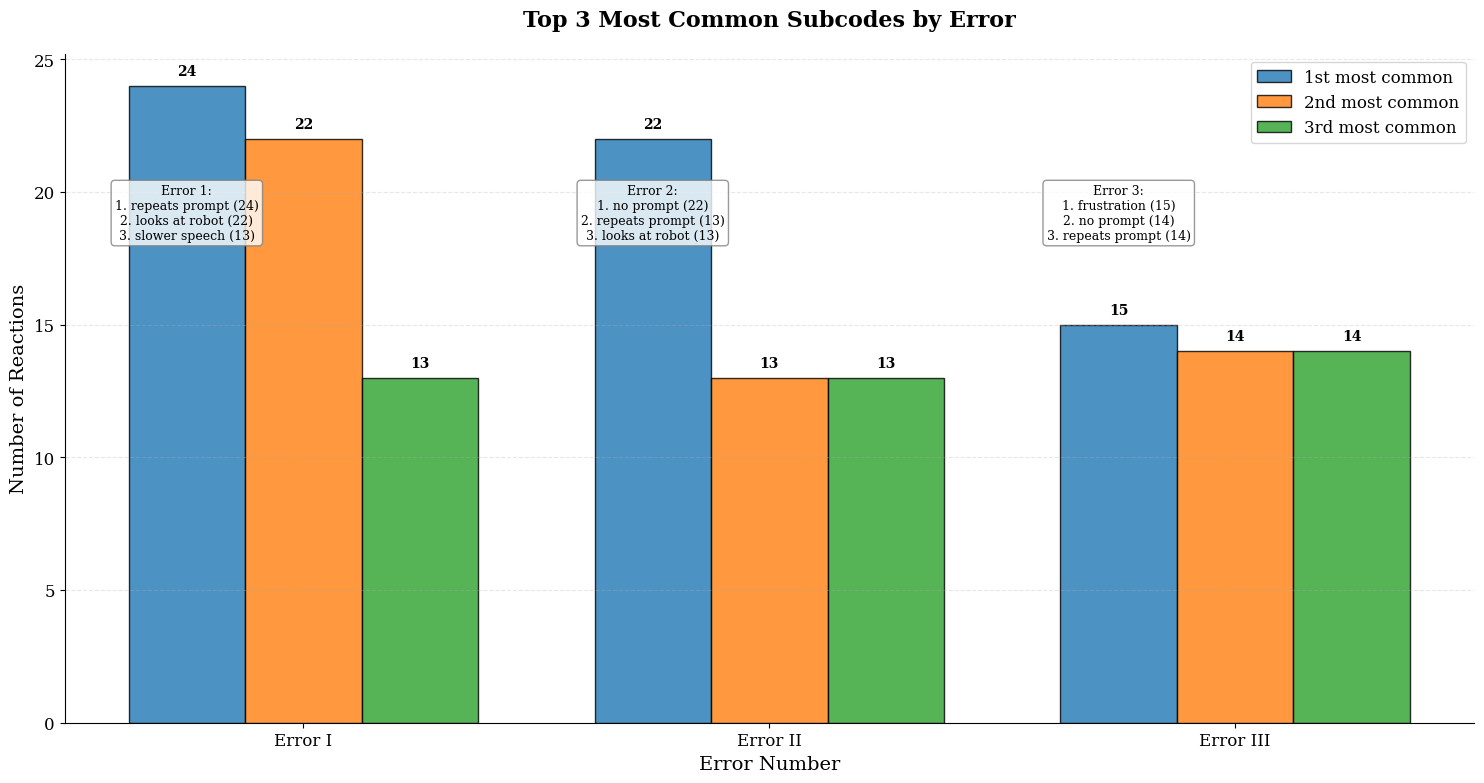

Top subcodes by error saved to 'plots/top_subcodes_by_error.png'

2. Creating top categories by error plot...


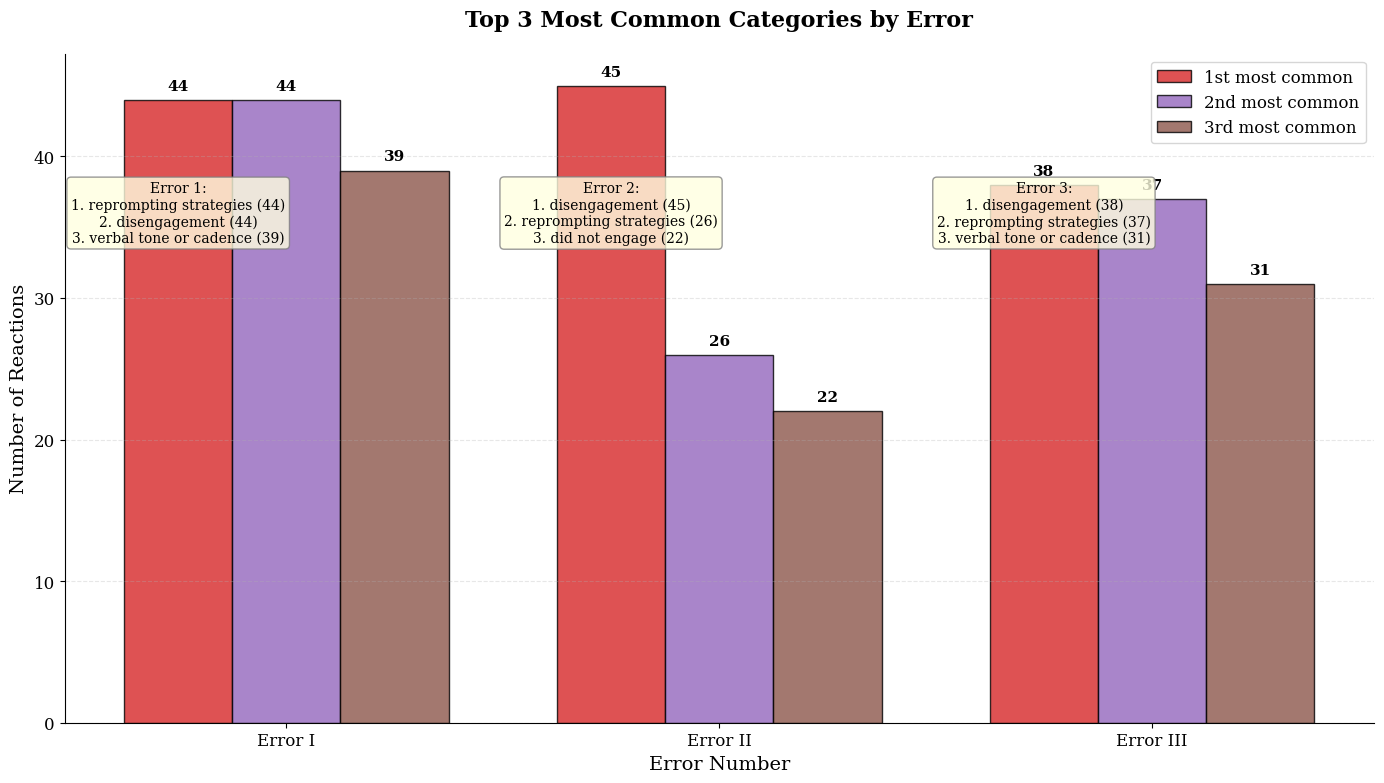

Top categories by error saved to 'plots/top_categories_by_error.png'

3. Creating top engagement categories by error plot...


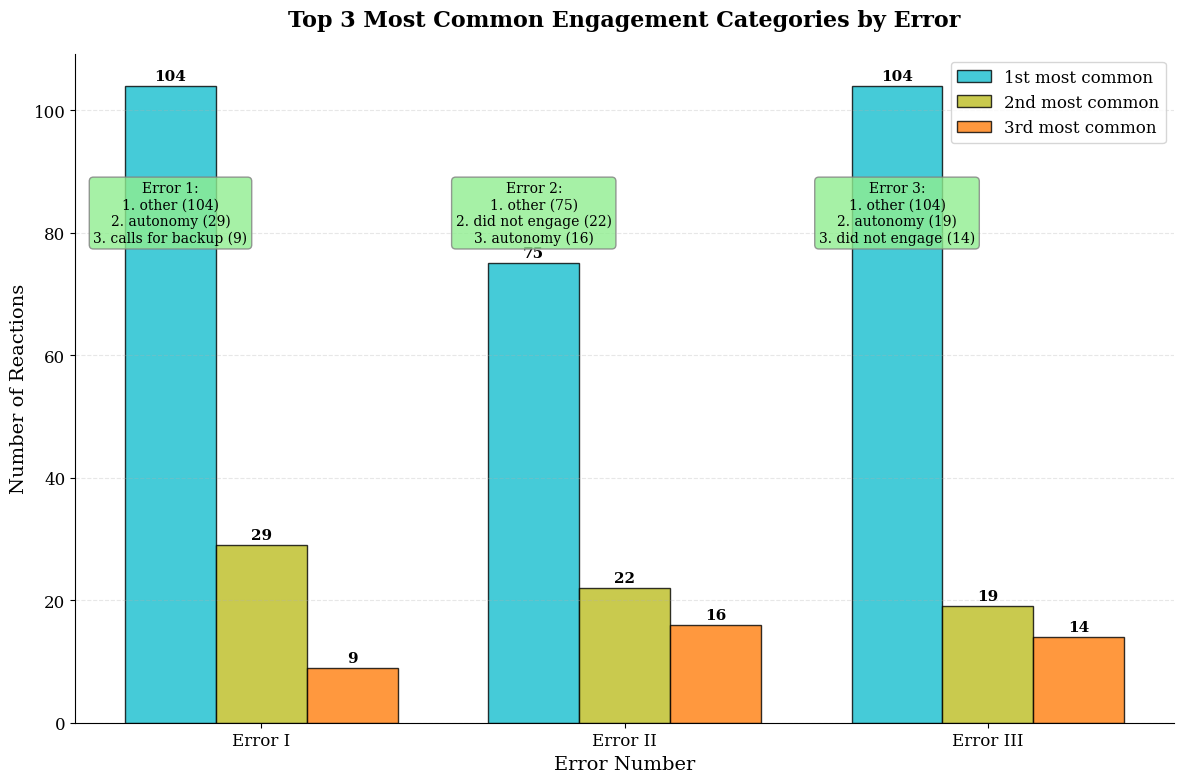

Top engagement categories by error saved to 'plots/top_engagement_by_error.png'

4. Creating reaction heatmap...


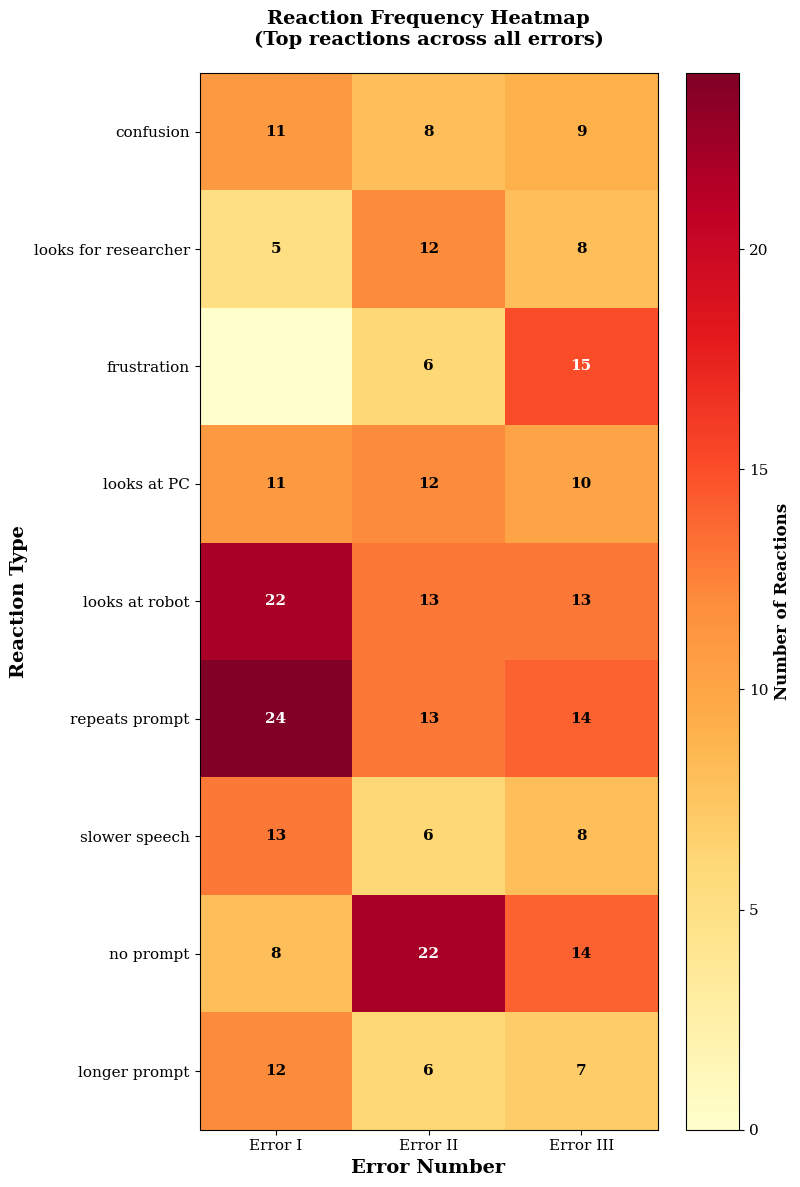

Reaction heatmap saved to 'plots/reaction_heatmap_by_error.png'

SUMMARY: TOP 3 MOST COMMON REACTIONS BY ERROR

==================== ERROR 1 (150 total reactions) ====================

TOP SUBCODES:
  1. repeats prompt: 24 reactions (16.0%)
  2. looks at robot: 22 reactions (14.7%)
  3. slower speech: 13 reactions (8.7%)

TOP CATEGORIES:
  1. reprompting strategies: 44 reactions (29.3%)
  2. disengagement: 44 reactions (29.3%)
  3. verbal tone or cadence: 39 reactions (26.0%)

TOP ENGAGEMENT CATEGORIES:
  1. other: 104 reactions (69.3%)
  2. autonomy: 29 reactions (19.3%)
  3. calls for backup: 9 reactions (6.0%)

==================== ERROR 2 (127 total reactions) ====================

TOP SUBCODES:
  1. no prompt: 22 reactions (17.3%)
  2. repeats prompt: 13 reactions (10.2%)
  3. looks at robot: 13 reactions (10.2%)

TOP CATEGORIES:
  1. disengagement: 45 reactions (35.4%)
  2. reprompting strategies: 26 reactions (20.5%)
  3. did not engage: 22 reactions (17.3%)

TOP ENGAGEMENT CATE

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def map_subcode_to_engagement_category(subcode):
    """Map a subcode to its engagement category"""
    for category, subcodes in engagement_categories.items():
        if subcode in subcodes:
            return category
    return "other"

def analyze_top_reactions_by_error():
    """Analyze the top 3 most common reactions to each error"""
    
    # Read the reactions data
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} reactions from {data['participant_id'].nunique()} participants")
    
    # Add category mappings
    data['category'] = data['subcode_readable'].apply(map_subcode_to_category)
    data['engagement_category'] = data['subcode_readable'].apply(map_subcode_to_engagement_category)
    
    results = {}
    
    for error_num in [1, 2, 3]:
        error_data = data[data['error'] == error_num]
        print(f"\nError {error_num}: {len(error_data)} total reactions")
        
        # Count subcodes
        subcode_counts = error_data['subcode_readable'].value_counts()
        
        # Count categories  
        category_counts = error_data['category'].value_counts()
        
        # Count engagement categories
        engagement_counts = error_data['engagement_category'].value_counts()
        
        results[error_num] = {
            'subcode_counts': subcode_counts,
            'category_counts': category_counts,
            'engagement_counts': engagement_counts,
            'total_reactions': len(error_data)
        }
        
        print(f"  Top 3 subcodes: {subcode_counts.head(3).to_dict()}")
        print(f"  Top 3 categories: {category_counts.head(3).to_dict()}")
        print(f"  Top 3 engagement: {engagement_counts.head(3).to_dict()}")
    
    return results

def plot_top_subcodes_by_error(results):
    """Plot top 3 subcodes for each error"""
    
    plt.figure(figsize=(15, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Prepare data for plotting
    errors = [1, 2, 3]
    width = 0.25  # Width of bars
    x = np.arange(len(errors))
    
    # Get top 3 subcodes for each error
    top_subcodes_data = {}
    all_top_subcodes = set()
    
    for error_num in errors:
        top_3 = results[error_num]['subcode_counts'].head(3)
        top_subcodes_data[error_num] = top_3
        all_top_subcodes.update(top_3.index)
    
    # Create bars for each position (1st, 2nd, 3rd most common)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green for 1st, 2nd, 3rd
    positions = ['1st', '2nd', '3rd']
    
    for pos_idx, (position, color) in enumerate(zip(positions, colors)):
        counts = []
        labels = []
        
        for error_num in errors:
            top_subcodes = list(top_subcodes_data[error_num].index)
            top_counts = list(top_subcodes_data[error_num].values)
            
            if pos_idx < len(top_subcodes):
                counts.append(top_counts[pos_idx])
                if pos_idx == 0:  # Only show labels for the first set to avoid clutter
                    labels.append(top_subcodes[pos_idx])
                else:
                    labels.append('')
            else:
                counts.append(0)
                labels.append('')
        
        bars = plt.bar(x + pos_idx * width, counts, width, 
                      label=f'{position} most common', color=color, alpha=0.8, edgecolor='black')
        
        # Add value labels on bars
        for bar, count, label in zip(bars, counts, labels):
            if count > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                        str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.title('Top 3 Most Common Subcodes by Error', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Error Number', fontsize=14)
    plt.ylabel('Number of Reactions', fontsize=14)
    plt.xticks(x + width, ['Error I', 'Error II', 'Error III'])
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add text annotations showing what each bar represents
    y_max = max([max(results[error_num]['subcode_counts'].head(3).values) for error_num in errors])
    
    for error_idx, error_num in enumerate(errors):
        top_3 = results[error_num]['subcode_counts'].head(3)
        text_y = y_max * 0.8
        
        annotation_text = f"Error {error_num}:\n"
        for i, (subcode, count) in enumerate(top_3.items()):
            short_subcode = subcode.replace("more specific/longer prompt", "longer prompt")
            short_subcode = short_subcode.replace("amusement/humor", "humor")
            annotation_text += f"{i+1}. {short_subcode} ({count})\n"
        
        plt.text(error_idx, text_y, annotation_text.strip(), 
                ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.savefig('plots/top_subcodes_by_error.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Top subcodes by error saved to 'plots/top_subcodes_by_error.png'")

def plot_top_categories_by_error(results):
    """Plot top 3 categories for each error"""
    
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    errors = [1, 2, 3]
    width = 0.25
    x = np.arange(len(errors))
    
    # Get top 3 categories for each error
    top_categories_data = {}
    
    for error_num in errors:
        top_3 = results[error_num]['category_counts'].head(3)
        top_categories_data[error_num] = top_3
    
    colors = ['#d62728', '#9467bd', '#8c564b']  # Red, Purple, Brown for 1st, 2nd, 3rd
    positions = ['1st', '2nd', '3rd']
    
    for pos_idx, (position, color) in enumerate(zip(positions, colors)):
        counts = []
        
        for error_num in errors:
            top_categories = list(top_categories_data[error_num].values)
            
            if pos_idx < len(top_categories):
                counts.append(top_categories[pos_idx])
            else:
                counts.append(0)
        
        bars = plt.bar(x + pos_idx * width, counts, width, 
                      label=f'{position} most common', color=color, alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bar, count in zip(bars, counts):
            if count > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Top 3 Most Common Categories by Error', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Error Number', fontsize=14)
    plt.ylabel('Number of Reactions', fontsize=14)
    plt.xticks(x + width, ['Error I', 'Error II', 'Error III'])
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add annotations
    y_max = max([max(results[error_num]['category_counts'].head(3).values) for error_num in errors])
    
    for error_idx, error_num in enumerate(errors):
        top_3 = results[error_num]['category_counts'].head(3)
        text_y = y_max * 0.8
        
        annotation_text = f"Error {error_num}:\n"
        for i, (category, count) in enumerate(top_3.items()):
            annotation_text += f"{i+1}. {category} ({count})\n"
        
        plt.text(error_idx, text_y, annotation_text.strip(), 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.savefig('plots/top_categories_by_error.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Top categories by error saved to 'plots/top_categories_by_error.png'")

def plot_top_engagement_by_error(results):
    """Plot top 3 engagement categories for each error"""
    
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.family': 'serif'})
    
    errors = [1, 2, 3]
    width = 0.25
    x = np.arange(len(errors))
    
    # Get top 3 engagement categories for each error
    top_engagement_data = {}
    
    for error_num in errors:
        top_3 = results[error_num]['engagement_counts'].head(3)
        top_engagement_data[error_num] = top_3
    
    colors = ['#17becf', '#bcbd22', '#ff7f0e']  # Cyan, Yellow-green, Orange for 1st, 2nd, 3rd
    positions = ['1st', '2nd', '3rd']
    
    for pos_idx, (position, color) in enumerate(zip(positions, colors)):
        counts = []
        
        for error_num in errors:
            top_engagement = list(top_engagement_data[error_num].values)
            
            if pos_idx < len(top_engagement):
                counts.append(top_engagement[pos_idx])
            else:
                counts.append(0)
        
        bars = plt.bar(x + pos_idx * width, counts, width, 
                      label=f'{position} most common', color=color, alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bar, count in zip(bars, counts):
            if count > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title('Top 3 Most Common Engagement Categories by Error', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Error Number', fontsize=14)
    plt.ylabel('Number of Reactions', fontsize=14)
    plt.xticks(x + width, ['Error I', 'Error II', 'Error III'])
    plt.legend(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add annotations
    y_max = max([max(results[error_num]['engagement_counts'].head(3).values) for error_num in errors if len(results[error_num]['engagement_counts']) > 0])
    
    for error_idx, error_num in enumerate(errors):
        top_3 = results[error_num]['engagement_counts'].head(3)
        if len(top_3) > 0:
            text_y = y_max * 0.8
            
            annotation_text = f"Error {error_num}:\n"
            for i, (engagement, count) in enumerate(top_3.items()):
                annotation_text += f"{i+1}. {engagement} ({count})\n"
            
            plt.text(error_idx, text_y, annotation_text.strip(), 
                    ha='center', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.savefig('plots/top_engagement_by_error.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Top engagement categories by error saved to 'plots/top_engagement_by_error.png'")

def create_summary_table(results):
    """Create a summary table of top reactions"""
    
    print(f"\n" + "="*100)
    print("SUMMARY: TOP 3 MOST COMMON REACTIONS BY ERROR")
    print("="*100)
    
    for error_num in [1, 2, 3]:
        total_reactions = results[error_num]['total_reactions']
        
        print(f"\n{'='*20} ERROR {error_num} ({total_reactions} total reactions) {'='*20}")
        
        print(f"\nTOP SUBCODES:")
        for i, (subcode, count) in enumerate(results[error_num]['subcode_counts'].head(3).items(), 1):
            percentage = (count / total_reactions) * 100
            print(f"  {i}. {subcode}: {count} reactions ({percentage:.1f}%)")
        
        print(f"\nTOP CATEGORIES:")
        for i, (category, count) in enumerate(results[error_num]['category_counts'].head(3).items(), 1):
            percentage = (count / total_reactions) * 100
            print(f"  {i}. {category}: {count} reactions ({percentage:.1f}%)")
        
        print(f"\nTOP ENGAGEMENT CATEGORIES:")
        for i, (engagement, count) in enumerate(results[error_num]['engagement_counts'].head(3).items(), 1):
            percentage = (count / total_reactions) * 100
            print(f"  {i}. {engagement}: {count} reactions ({percentage:.1f}%)")

def create_heatmap_visualization(results):
    """Create a heatmap showing reaction patterns across errors"""
    
    # Prepare data for heatmap
    all_subcodes = set()
    for error_num in [1, 2, 3]:
        all_subcodes.update(results[error_num]['subcode_counts'].head(5).index)
    
    # Create matrix
    heatmap_data = []
    subcode_labels = list(all_subcodes)
    
    for subcode in subcode_labels:
        row = []
        for error_num in [1, 2, 3]:
            count = results[error_num]['subcode_counts'].get(subcode, 0)
            row.append(count)
        heatmap_data.append(row)
    
    heatmap_data = np.array(heatmap_data)
    
    # Create heatmap
    plt.figure(figsize=(8, 12), facecolor='white')
    plt.rcParams.update({'font.size': 11})
    
    im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Number of Reactions', fontsize=12, fontweight='bold')
    
    # Set ticks and labels
    plt.xticks([0, 1, 2], ['Error I', 'Error II', 'Error III'])
    plt.yticks(range(len(subcode_labels)), [s.replace('more specific/longer prompt', 'longer prompt') 
                                           for s in subcode_labels])
    
    plt.xlabel('Error Number', fontsize=14, fontweight='bold')
    plt.ylabel('Reaction Type', fontsize=14, fontweight='bold')
    plt.title('Reaction Frequency Heatmap\n(Top reactions across all errors)', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Add text annotations
    for i in range(len(subcode_labels)):
        for j in range(3):
            count = heatmap_data[i, j]
            if count > 0:
                plt.text(j, i, str(count), ha='center', va='center', 
                        color='white' if count > heatmap_data.max() * 0.6 else 'black',
                        fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/reaction_heatmap_by_error.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    print("Reaction heatmap saved to 'plots/reaction_heatmap_by_error.png'")

# Run the analysis
print("Analyzing top reactions by error...")
error_results = analyze_top_reactions_by_error()

# Create visualizations
print("\n1. Creating top subcodes by error plot...")
plot_top_subcodes_by_error(error_results)

print("\n2. Creating top categories by error plot...")
plot_top_categories_by_error(error_results)

print("\n3. Creating top engagement categories by error plot...")
plot_top_engagement_by_error(error_results)

print("\n4. Creating reaction heatmap...")
create_heatmap_visualization(error_results)

# Print summary table
create_summary_table(error_results)

# Save detailed results
results_df = []
for error_num in [1, 2, 3]:
    for rank, (subcode, count) in enumerate(error_results[error_num]['subcode_counts'].head(3).items(), 1):
        results_df.append({
            'Error': error_num,
            'Rank': rank,
            'Type': 'Subcode',
            'Reaction': subcode,
            'Count': count,
            'Percentage': f"{(count/error_results[error_num]['total_reactions'])*100:.1f}%"
        })
    
    for rank, (category, count) in enumerate(error_results[error_num]['category_counts'].head(3).items(), 1):
        results_df.append({
            'Error': error_num,
            'Rank': rank,
            'Type': 'Category',
            'Reaction': category,
            'Count': count,
            'Percentage': f"{(count/error_results[error_num]['total_reactions'])*100:.1f}%"
        })
    
    for rank, (engagement, count) in enumerate(error_results[error_num]['engagement_counts'].head(3).items(), 1):
        results_df.append({
            'Error': error_num,
            'Rank': rank,
            'Type': 'Engagement',
            'Reaction': engagement,
            'Count': count,
            'Percentage': f"{(count/error_results[error_num]['total_reactions'])*100:.1f}%"
        })

results_df = pd.DataFrame(results_df)
results_df.to_csv('top_reactions_by_error.csv', index=False)
print("\nDetailed results saved to 'top_reactions_by_error.csv'")

Loading reactions_between_errors.csv...
Loaded 425 reaction events
Unique readable subcodes: 24
Errors covered: [1, 2, 3]
Total annotation categories defined: 25
Filtered to 425 reactions with defined categories

Grouped data by error:
subcode_readable  no prompt  longer prompt  more specific/longer prompt  \
error                                                                     
1                         8              0                           12   
2                        22              0                            6   
3                        14              0                            7   

subcode_readable  swaps terms  simpler prompt  repeats prompt  \
error                                                           
1                           1               2              24   
2                           1               6              13   
3                           0              10              14   

subcode_readable  makes new prompt  'please'  slower speech  d

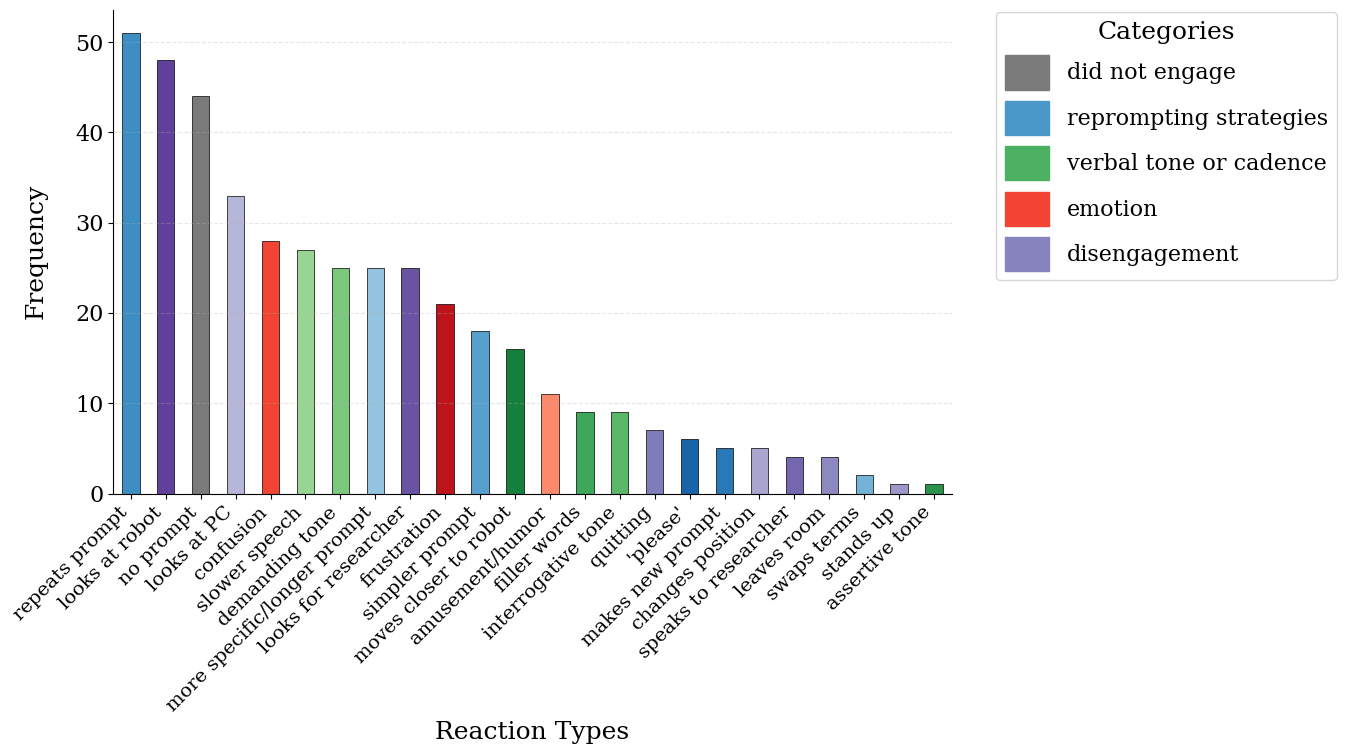


CREATING ERROR-SPECIFIC PLOTS
Error-specific plots saved to 'plots/reactions_by_error_number.png'


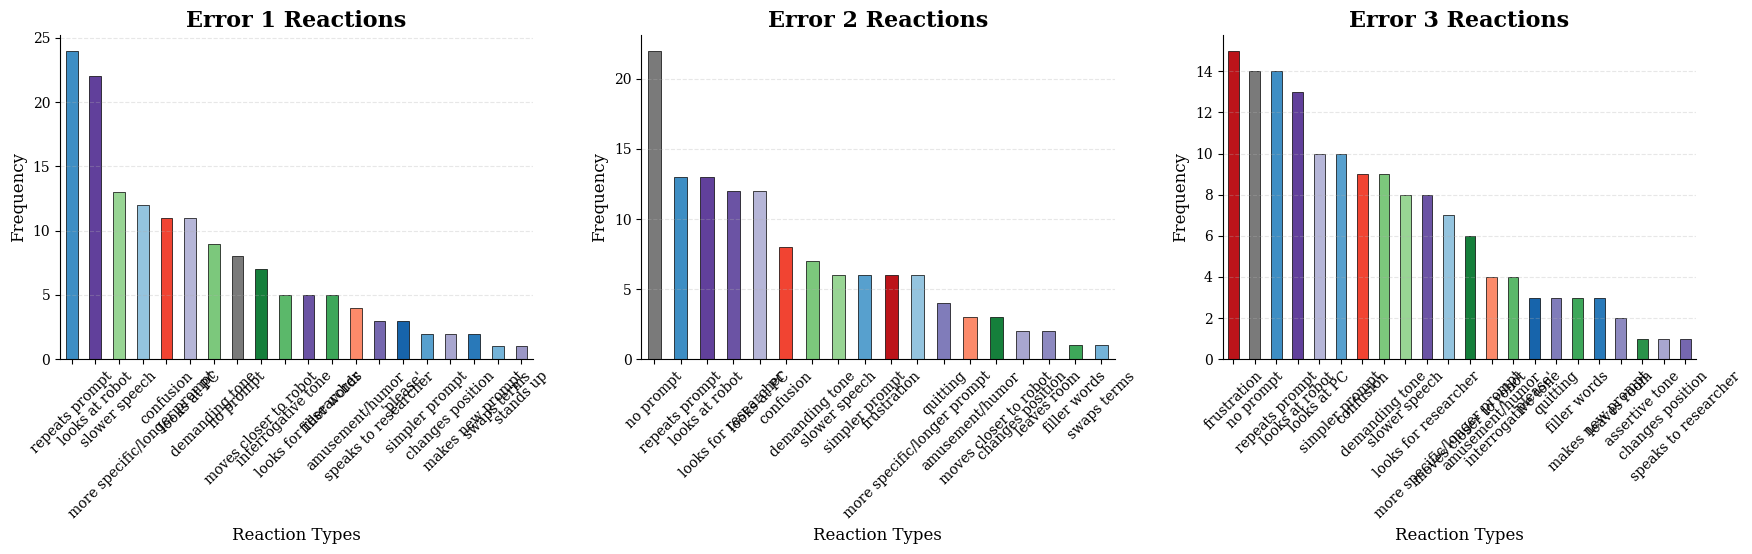


SUMMARY STATISTICS
Total participants: 50
Total reaction events: 425
Reactions per error:
  Error 1: 150 reactions
  Error 2: 127 reactions
  Error 3: 148 reactions

Most common reaction types:
  1. repeats prompt: 51 times
  2. looks at robot: 48 times
  3. no prompt: 44 times
  4. looks at PC: 33 times
  5. confusion: 28 times

Reaction categories distribution:
  disengagement: 127 reactions
  reprompting strategies: 107 reactions
  verbal tone or cadence: 87 reactions
  emotion: 60 reactions
  did not engage: 44 reactions


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np

# Categories and color mappings (from your original code)

# Read the reactions data (output from previous script)
print("Loading reactions_between_errors.csv...")
data = pd.read_csv('reactions_between_errors.csv')

print(f"Loaded {len(data)} reaction events")
print(f"Unique readable subcodes: {data['subcode_readable'].nunique()}")
print(f"Errors covered: {sorted(data['error'].unique())}")

# Create annotation list from all readable subcodes in our categories
annotation_list = []
for category_labels in categories.values():
    annotation_list.extend(category_labels)

print(f"Total annotation categories defined: {len(annotation_list)}")

# Filter data to only include labels that are in our defined categories
data_filtered = data[data['subcode_readable'].isin(annotation_list)].copy()
print(f"Filtered to {len(data_filtered)} reactions with defined categories")

if len(data_filtered) == 0:
    print("WARNING: No reactions found in defined categories!")
    print("Available subcode_readable values:", data['subcode_readable'].unique())
    print("Expected categories:", annotation_list)
else:
    # Group by error and labels to create frequency matrix
    grouped_data = data_filtered.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    
    # Reindex to include all annotation categories (fill missing with 0)
    grouped_data = grouped_data.reindex(columns=annotation_list, fill_value=0)
    
    print("\nGrouped data by error:")
    print(grouped_data)
    
    # Calculate overall frequency for plotting
    frequency = data_filtered['subcode_readable'].value_counts()
    print(f"\nOverall frequencies:")
    print(frequency)
    
    # Function to get shaded colors for each category
    def get_shaded_colors(category, labels):
        cmap = category_colormaps[category]
        num_labels = len(labels)
        if num_labels == 1:
            return [cmap(0.6)]
        return cmap(np.linspace(0.4, 0.8, num_labels))
    
    # Create label color mapping
    label_colors = {}
    for category, labels in categories.items():
        # Only include labels that actually appear in our data
        present_labels = [label for label in labels if label in frequency.index]
        if present_labels:
            shades = get_shaded_colors(category, present_labels)
            label_colors.update(dict(zip(present_labels, shades)))
    
    # Get bar colors for the plot
    bar_colors = [label_colors.get(label, 'gray') for label in frequency.index]
    
    # Create the plot
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create bar plot
    ax = frequency.sort_values(ascending=False).plot(
        kind='bar',
        color=bar_colors,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Create legend patches (only for categories that have data)
    legend_patches = []
    for category in categories.keys():
        # Check if this category has any labels in our data
        category_labels = [label for label in categories[category] if label in frequency.index]
        if category_labels:
            legend_patches.append(
                mpatches.Patch(color=category_colormaps[category](0.6), label=category)
            )
    
    plt.legend(
        handles=legend_patches, 
        title="Categories", 
        title_fontsize=18, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        fontsize=16, 
        handleheight=2, 
        handlelength=2, 
        borderaxespad=0.1
    )
    
    # Formatting
    plt.xlabel("Reaction Types", fontsize=18)
    plt.ylabel("Frequency", labelpad=20, fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=16)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig('plots/reaction_frequencies_between_errors.png', format='png', dpi=500, bbox_inches='tight')
    print("Plot saved to 'plots/reaction_frequencies_between_errors.png'")
    
    plt.show()
    
    # Additional analysis: Plot by error number
    print("\n" + "="*50)
    print("CREATING ERROR-SPECIFIC PLOTS")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
    
    for i, error_num in enumerate([1, 2, 3]):
        if error_num in data_filtered['error'].values:
            error_data = data_filtered[data_filtered['error'] == error_num]
            error_freq = error_data['subcode_readable'].value_counts()
            
            if len(error_freq) > 0:
                error_colors = [label_colors.get(label, 'gray') for label in error_freq.index]
                
                error_freq.plot(
                    kind='bar',
                    ax=axes[i],
                    color=error_colors,
                    edgecolor='black',
                    linewidth=0.5
                )
                
                axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
                axes[i].set_xlabel('Reaction Types', fontsize=12)
                axes[i].set_ylabel('Frequency', fontsize=12)
                axes[i].tick_params(axis='x', rotation=45, labelsize=10)
                axes[i].tick_params(axis='y', labelsize=10)
                axes[i].grid(axis='y', alpha=0.3, linestyle='--')
                axes[i].spines['top'].set_visible(False)
                axes[i].spines['right'].set_visible(False)
            else:
                axes[i].text(0.5, 0.5, f'No reactions\nfor Error {error_num}', 
                            ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
                axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, f'No data\nfor Error {error_num}', 
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
            axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/reactions_by_error_number.png', format='png', dpi=500, bbox_inches='tight')
    print("Error-specific plots saved to 'plots/reactions_by_error_number.png'")
    plt.show()
    
    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    
    print(f"Total participants: {data['participant_id'].nunique()}")
    print(f"Total reaction events: {len(data_filtered)}")
    print(f"Reactions per error:")
    for error_num in [1, 2, 3]:
        count = len(data_filtered[data_filtered['error'] == error_num])
        print(f"  Error {error_num}: {count} reactions")
    
    print(f"\nMost common reaction types:")
    for i, (reaction, count) in enumerate(frequency.head(5).items()):
        print(f"  {i+1}. {reaction}: {count} times")
    
    print(f"\nReaction categories distribution:")
    category_counts = {}
    for category, labels in categories.items():
        count = sum(frequency.get(label, 0) for label in labels)
        if count > 0:
            category_counts[category] = count
    
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {count} reactions")

Loading reactions_between_errors.csv...
Loaded 422 reaction events
Unique readable subcodes: 25
Errors covered: [1, 2, 3]
Total annotation categories defined: 9
Filtered to 140 reactions with defined categories

Grouped data by error:
subcode_readable  no prompt  initial prompt  looks at robot  \
error                                                         
1                         8               0              21   
2                        22               0              12   
3                        14               0              13   

subcode_readable  moves closer to robot  speaks to researcher  \
error                                                           
1                                     7                     3   
2                                     3                     0   
3                                     6                     1   

subcode_readable  tries to look at researcher  looks for researcher  \
error                                               

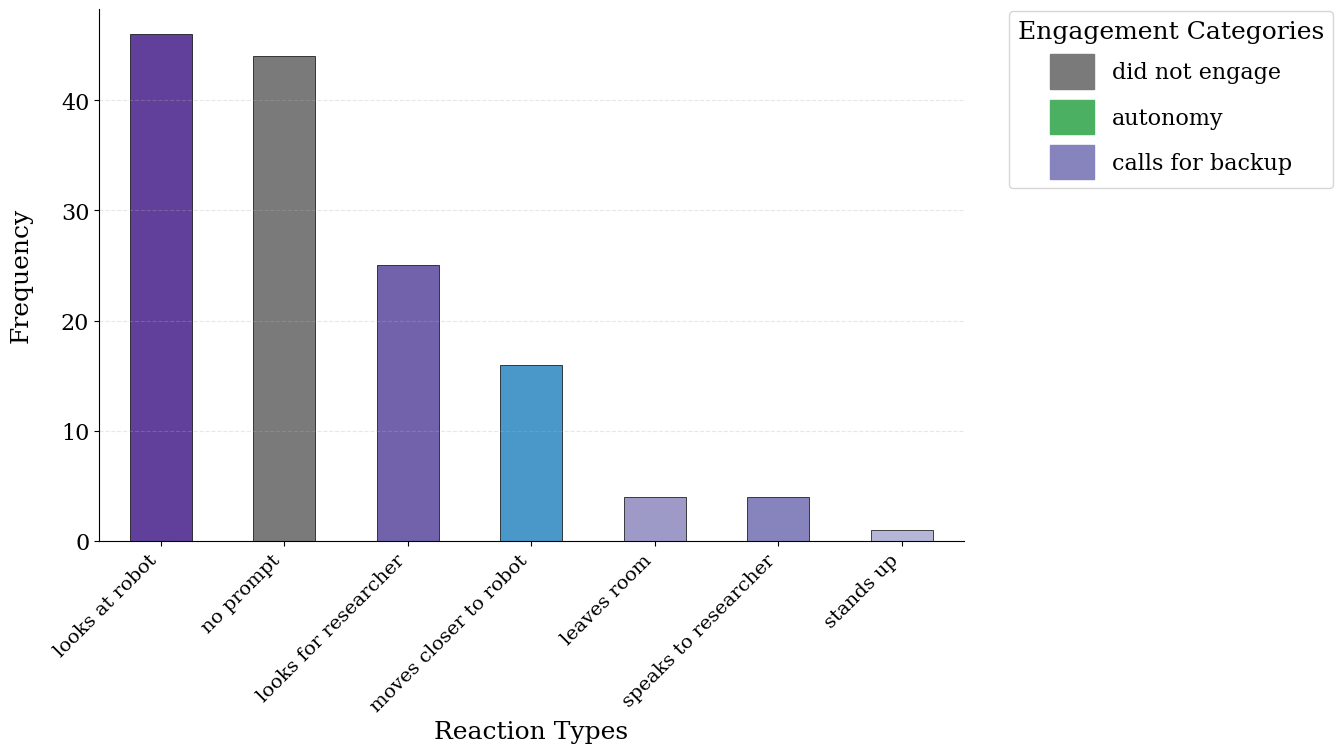


CREATING ERROR-SPECIFIC PLOTS
Error-specific plots saved to 'plots/reactions_by_error_number.png'


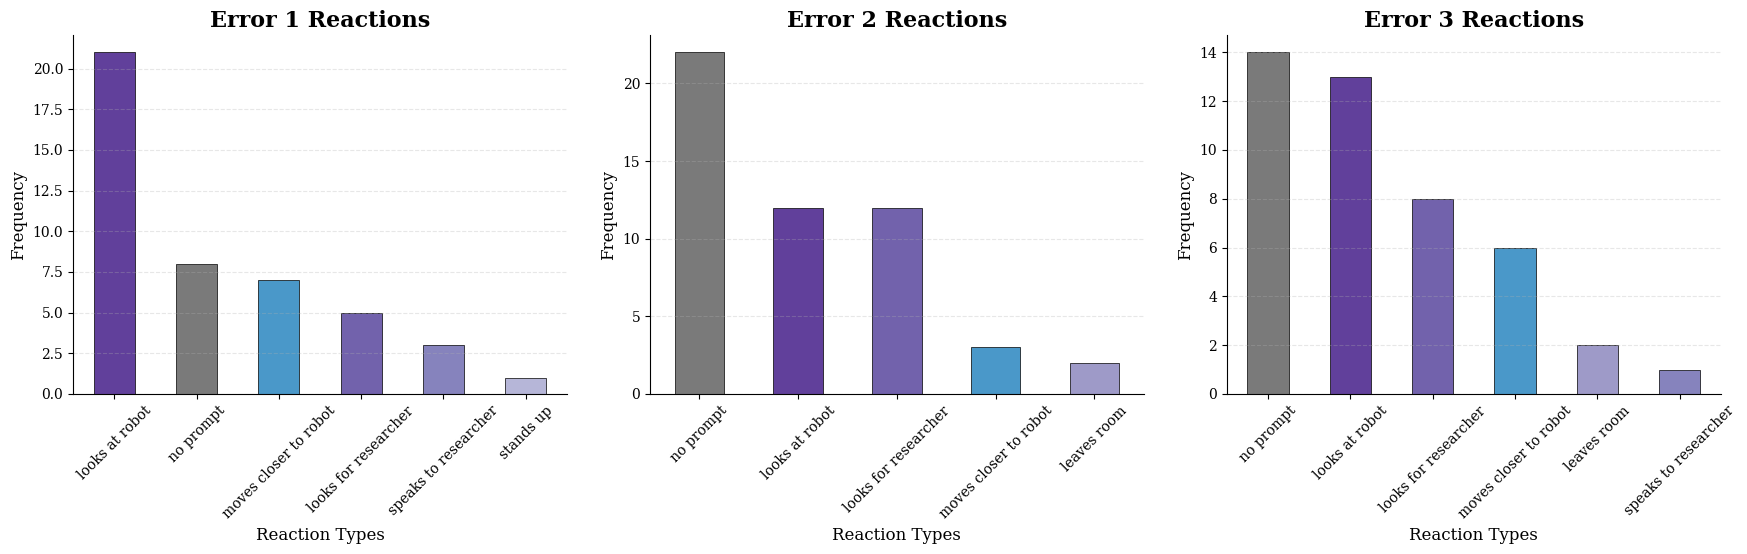


SUMMARY STATISTICS
Total participants: 49
Total reaction events: 140
Reactions per error:
  Error 1: 45 reactions
  Error 2: 51 reactions
  Error 3: 44 reactions

Most common reaction types:
  1. looks at robot: 46 times
  2. no prompt: 44 times
  3. looks for researcher: 25 times
  4. moves closer to robot: 16 times
  5. leaves room: 4 times

Reaction categories distribution:
  disengagement: 80 reactions
  did not engage: 44 reactions
  reprompting strategies: 16 reactions


In [135]:

# Read the reactions data (output from previous script)
print("Loading reactions_between_errors.csv...")
data = pd.read_csv('reactions_between_errors.csv')

print(f"Loaded {len(data)} reaction events")
print(f"Unique readable subcodes: {data['subcode_readable'].nunique()}")
print(f"Errors covered: {sorted(data['error'].unique())}")

# Create annotation list from all readable subcodes in our categories
annotation_list = []
for category_labels in engagement_categories.values():
    annotation_list.extend(category_labels)

print(f"Total annotation categories defined: {len(annotation_list)}")

# Filter data to only include labels that are in our defined categories
data_filtered = data[data['subcode_readable'].isin(annotation_list)].copy()
print(f"Filtered to {len(data_filtered)} reactions with defined categories")

if len(data_filtered) == 0:
    print("WARNING: No reactions found in defined categories!")
    print("Available subcode_readable values:", data['subcode_readable'].unique())
    print("Expected categories:", annotation_list)
else:
    # Group by error and labels to create frequency matrix
    grouped_data = data_filtered.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    
    # Reindex to include all annotation categories (fill missing with 0)
    grouped_data = grouped_data.reindex(columns=annotation_list, fill_value=0)
    
    print("\nGrouped data by error:")
    print(grouped_data)
    
    # Calculate overall frequency for plotting
    frequency = data_filtered['subcode_readable'].value_counts()
    print(f"\nOverall frequencies:")
    print(frequency)
    
    # Function to get shaded colors for each category
    def get_shaded_colors(category, labels):
        cmap = category_colormaps[category]
        num_labels = len(labels)
        if num_labels == 1:
            return [cmap(0.6)]
        return cmap(np.linspace(0.4, 0.8, num_labels))
    
    # Create label color mapping
    label_colors = {}
    for category, labels in categories.items():
        # Only include labels that actually appear in our data
        present_labels = [label for label in labels if label in frequency.index]
        if present_labels:
            shades = get_shaded_colors(category, present_labels)
            label_colors.update(dict(zip(present_labels, shades)))
    
    # Get bar colors for the plot
    bar_colors = [label_colors.get(label, 'gray') for label in frequency.index]
    
    # Create the plot
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create bar plot
    ax = frequency.sort_values(ascending=False).plot(
        kind='bar',
        color=bar_colors,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Create legend patches (only for categories that have data)
    legend_patches = []
    for category in engagement_categories.keys():
        # Check if this category has any labels in our data
        category_labels = [label for label in engagement_categories[category] if label in frequency.index]
        if category_labels:
            legend_patches.append(
                mpatches.Patch(color=category_colormaps[category](0.6), label=category)
            )
    
    plt.legend(
        handles=legend_patches, 
        title="Engagement Categories", 
        title_fontsize=18, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        fontsize=16, 
        handleheight=2, 
        handlelength=2, 
        borderaxespad=0.1
    )
    
    # Formatting
    plt.xlabel("Reaction Types", fontsize=18)
    plt.ylabel("Frequency", labelpad=20, fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=16)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    #plt.savefig('plots/reaction_frequencies_between_errors.png', format='png', dpi=500, bbox_inches='tight')
    print("Plot saved to 'plots/reaction_frequencies_between_errors.png'")
    
    plt.show()
    
    # Additional analysis: Plot by error number
    print("\n" + "="*50)
    print("CREATING ERROR-SPECIFIC PLOTS")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
    
    for i, error_num in enumerate([1, 2, 3]):
        if error_num in data_filtered['error'].values:
            error_data = data_filtered[data_filtered['error'] == error_num]
            error_freq = error_data['subcode_readable'].value_counts()
            
            if len(error_freq) > 0:
                error_colors = [label_colors.get(label, 'gray') for label in error_freq.index]
                
                error_freq.plot(
                    kind='bar',
                    ax=axes[i],
                    color=error_colors,
                    edgecolor='black',
                    linewidth=0.5
                )
                
                axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
                axes[i].set_xlabel('Reaction Types', fontsize=12)
                axes[i].set_ylabel('Frequency', fontsize=12)
                axes[i].tick_params(axis='x', rotation=45, labelsize=10)
                axes[i].tick_params(axis='y', labelsize=10)
                axes[i].grid(axis='y', alpha=0.3, linestyle='--')
                axes[i].spines['top'].set_visible(False)
                axes[i].spines['right'].set_visible(False)
            else:
                axes[i].text(0.5, 0.5, f'No reactions\nfor Error {error_num}', 
                            ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
                axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, f'No data\nfor Error {error_num}', 
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
            axes[i].set_title(f'Error {error_num} Reactions', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    #plt.savefig('plots/reactions_by_error_number.png', format='png', dpi=500, bbox_inches='tight')
    print("Error-specific plots saved to 'plots/reactions_by_error_number.png'")
    plt.show()
    
    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    
    print(f"Total participants: {data['participant_id'].nunique()}")
    print(f"Total reaction events: {len(data_filtered)}")
    print(f"Reactions per error:")
    for error_num in [1, 2, 3]:
        count = len(data_filtered[data_filtered['error'] == error_num])
        print(f"  Error {error_num}: {count} reactions")
    
    print(f"\nMost common reaction types:")
    for i, (reaction, count) in enumerate(frequency.head(5).items()):
        print(f"  {i+1}. {reaction}: {count} times")
    
    print(f"\nReaction categories distribution:")
    category_counts = {}
    for category, labels in categories.items():
        count = sum(frequency.get(label, 0) for label in labels)
        if count > 0:
            category_counts[category] = count
    
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {count} reactions")

In [145]:
# Example usage - Verbal Tone or Cadence
verbal_tone_list = [
    "slower speech", 
    "demanding tone", 
    "interrogative tone", 
    "filler words",
    "assertive tone"
]


# Example usage - Reprompting Strategies
reprompting_list = [
    "repeats prompt", 
    "more specific/longer prompt", 
    "swaps terms", 
    "simpler prompt",
    "makes new prompt",
    "'please'",
    "longer prompt"
]


# Example usage - Emotional Reactions
emotion_list = [
    "amusement/humor", 
    "confusion", 
    "frustration"

]


# Example usage - Disengagement Behaviors
disengagement_list = [
    "looks at PC", 
    "changes position", 
    "stands up", 
    "leaves room", 
    "quitting",
    "looks for researcher",
    "speaks to researcher",
    "tries to look at researcher",
    "looks at robot",
    "moves closer to robot",
    "no prompt"
]


Creating histogram for: Verbal Tone or Cadence
Found 71 reactions for this category
Grouped data:
subcode_readable  slower speech  demanding tone  interrogative tone  \
error                                                                 
1                            13               9                   5   
2                             6               7                   0   
3                             8               9                   4   

subcode_readable  filler words  assertive tone  
error                                           
1                            5               0  
2                            1               0  
3                            3               1  
Plot saved to plots/tone_cadence_annotations_histogram.png


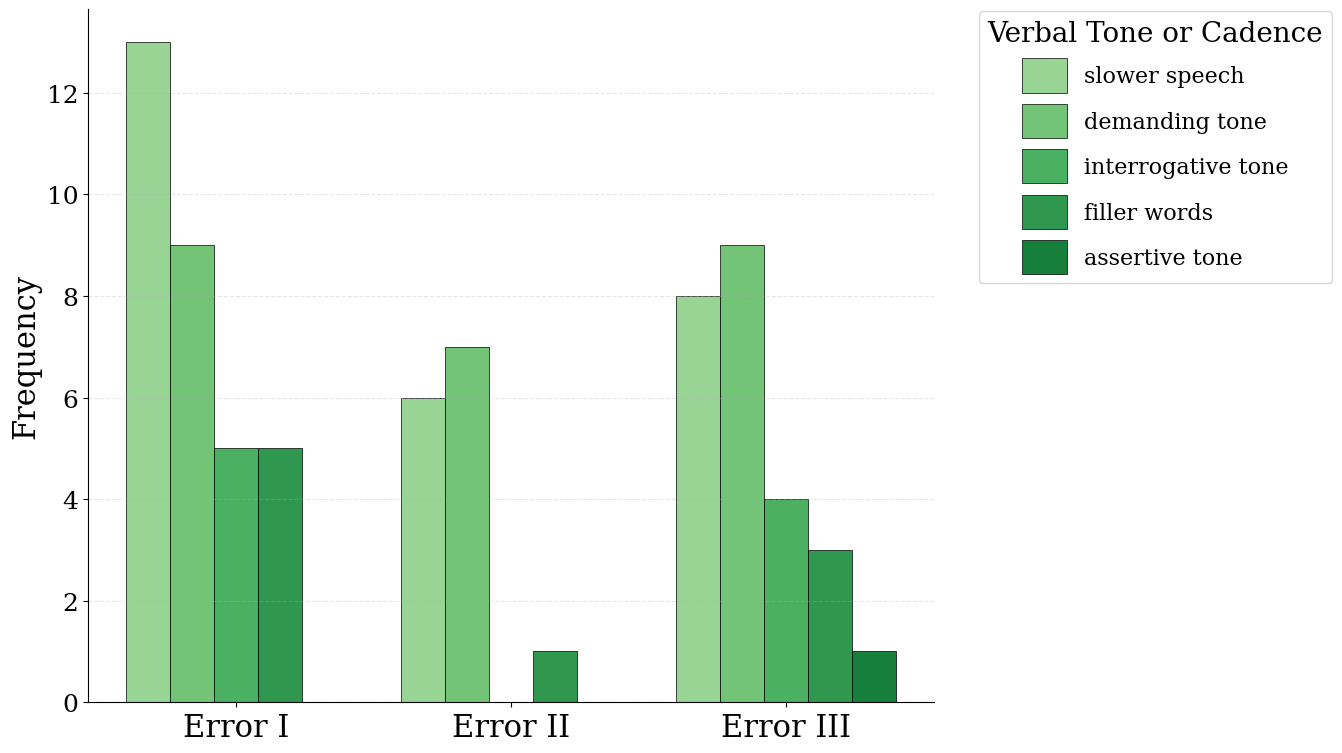


Summary for Verbal Tone or Cadence:
  Error 1: 32 total reactions
  Error 2: 14 total reactions
  Error 3: 25 total reactions
Most common reactions in this category:
  slower speech: 27 times
  demanding tone: 25 times
  interrogative tone: 9 times
  filler words: 9 times
  assertive tone: 1 times
Creating histogram for: Reprompting Strategies
Found 107 reactions for this category
Grouped data:
subcode_readable  repeats prompt  more specific/longer prompt  swaps terms  \
error                                                                        
1                             24                           12            1   
2                             13                            6            1   
3                             14                            7            0   

subcode_readable  simpler prompt  makes new prompt  'please'  longer prompt  
error                                                                        
1                              2                 2    

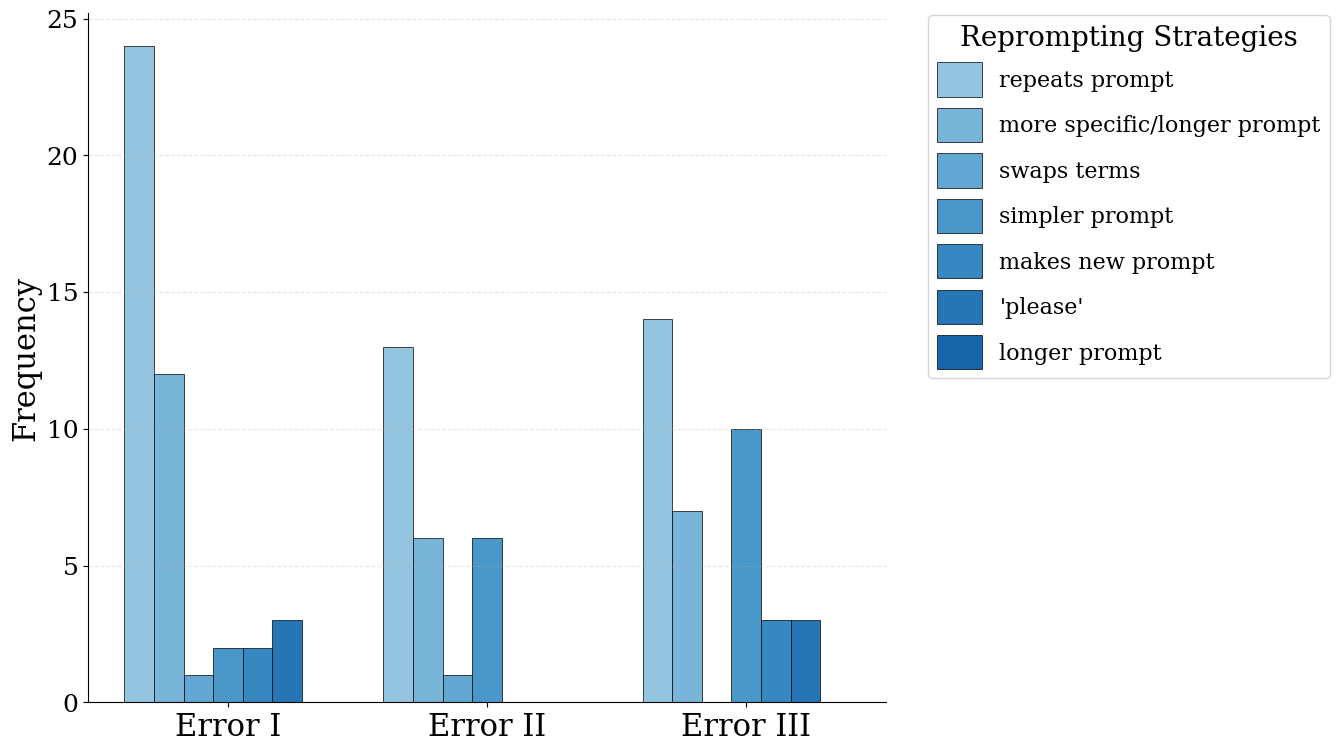


Summary for Reprompting Strategies:
  Error 1: 44 total reactions
  Error 2: 26 total reactions
  Error 3: 37 total reactions
Most common reactions in this category:
  repeats prompt: 51 times
  more specific/longer prompt: 25 times
  simpler prompt: 18 times
  'please': 6 times
  makes new prompt: 5 times
  swaps terms: 2 times
Creating histogram for: Emotional Reactions
Found 60 reactions for this category
Grouped data:
subcode_readable  amusement/humor  confusion  frustration
error                                                    
1                               4         11            0
2                               3          8            6
3                               4          9           15
Plot saved to plots/emotional_reactions_annotations_histogram.png


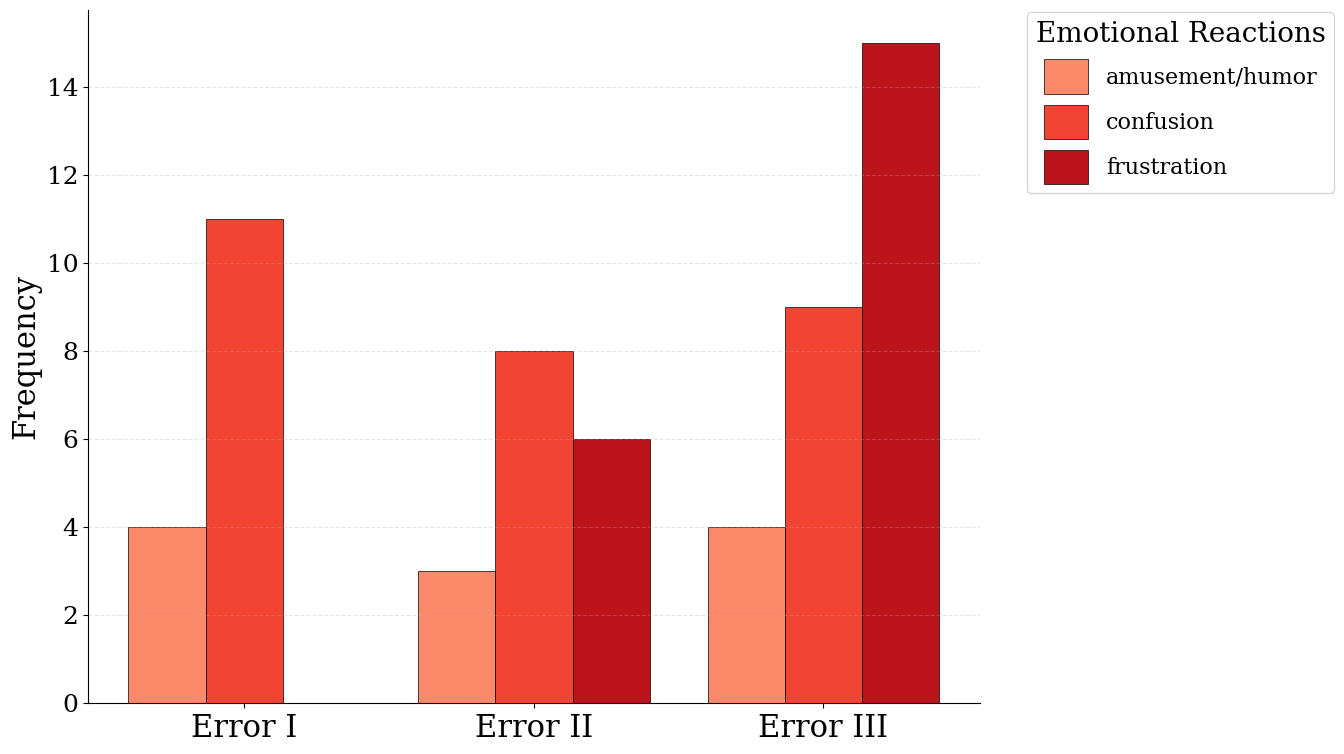


Summary for Emotional Reactions:
  Error 1: 15 total reactions
  Error 2: 17 total reactions
  Error 3: 28 total reactions
Most common reactions in this category:
  confusion: 28 times
  frustration: 21 times
  amusement/humor: 11 times
Creating histogram for: Disengagement Behaviors
Found 187 reactions for this category
Grouped data:
subcode_readable  looks at PC  changes position  stands up  leaves room  \
error                                                                     
1                          11                 2          1            0   
2                          12                 2          0            2   
3                          10                 1          0            2   

subcode_readable  quitting  looks for researcher  speaks to researcher  \
error                                                                    
1                        0                     5                     3   
2                        4                    12                

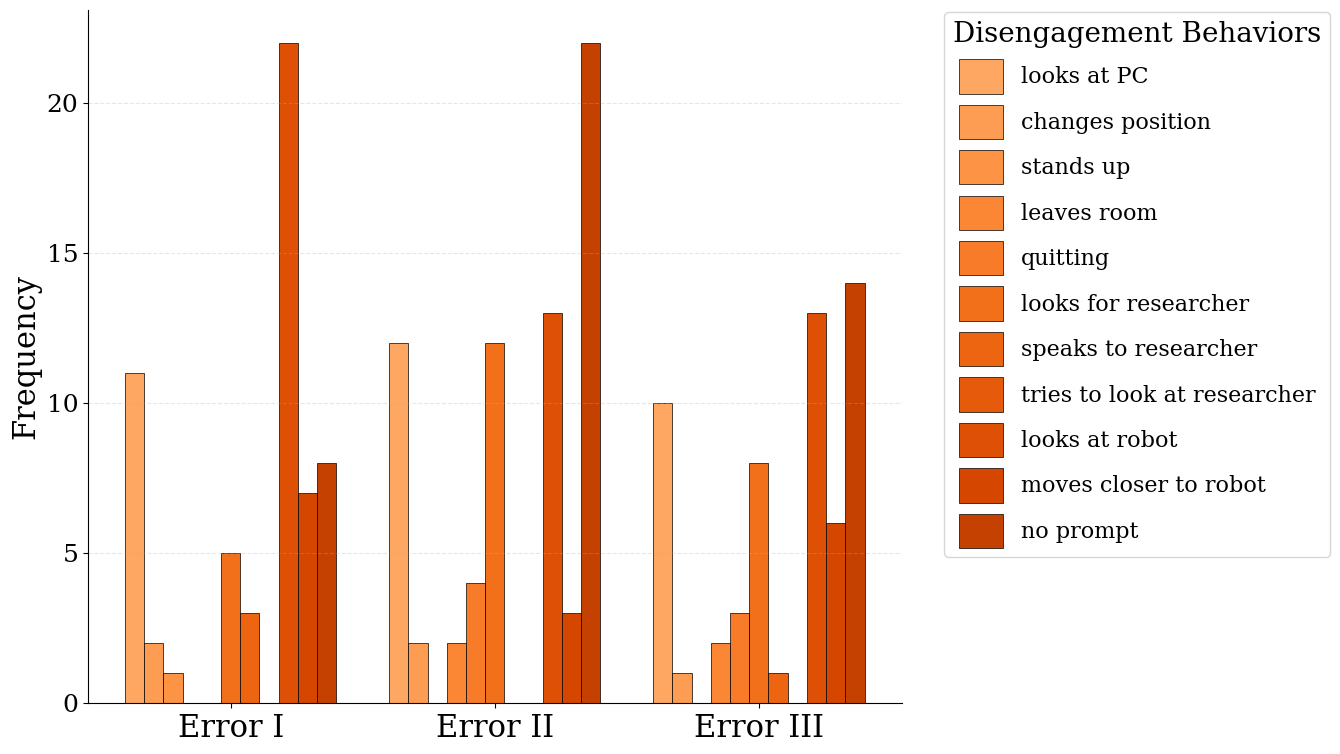


Summary for Disengagement Behaviors:
  Error 1: 59 total reactions
  Error 2: 70 total reactions
  Error 3: 58 total reactions
Most common reactions in this category:
  looks at robot: 48 times
  no prompt: 44 times
  looks at PC: 33 times
  looks for researcher: 25 times
  moves closer to robot: 16 times
  quitting: 7 times
  changes position: 5 times
  leaves room: 4 times
  speaks to researcher: 4 times
  stands up: 1 times


In [170]:

def plot_category_histogram(annotation_list, annotation_name, colormap, filename_suffix):
    """
    Create a grouped bar chart for specific annotation categories across errors
    
    Parameters:
    - annotation_list: List of specific annotations to include
    - annotation_name: Name for the category (for legend title)
    - colormap: Matplotlib colormap to use
    - filename_suffix: Suffix for the saved filename
    """
    
    # Read the reactions data
    print(f"Creating histogram for: {annotation_name}")
    data = pd.read_csv('reactions_between_errors.csv')
    
    # Filter data to only include annotations in our list
    data_filtered = data[data['subcode_readable'].isin(annotation_list)].copy()
    
    print(f"Found {len(data_filtered)} reactions for this category")
    
    if len(data_filtered) == 0:
        print(f"WARNING: No reactions found for {annotation_name}")
        print("Available subcode_readable values:", data['subcode_readable'].unique())
        return
    
    # Group by error and subcode_readable to get frequency matrix
    grouped_data = data_filtered.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    
    # Ensure we have all errors (1, 2, 3) even if some are missing
    all_errors = [1, 2, 3]
    grouped_data = grouped_data.reindex(index=all_errors, fill_value=0)
    
    # Ensure we have all annotations even if some don't appear
    grouped_data = grouped_data.reindex(columns=annotation_list, fill_value=0)
    
    print("Grouped data:")
    print(grouped_data)
    
    # Set up the plot
    errors = grouped_data.index
    annotations = grouped_data.columns
    num_annotations = len(annotations)
    
    # Calculate bar positions
    bar_width = 0.8 / num_annotations
    x_positions = np.arange(len(errors))
    
    # Generate colors
    colors = colormap(np.linspace(0.4, 0.8, num_annotations))
    
    # Create the figure
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create bars for each annotation
    for i, (annotation, color) in enumerate(zip(annotations, colors)):
        plt.bar(
            x_positions + i * bar_width - bar_width * (num_annotations - 1) / 2,
            grouped_data[annotation],
            width=bar_width,
            label=annotation,
            color=color,
            edgecolor='black',
            linewidth=0.5
        )
    
    # Customize the plot
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(x_positions, x_labels, fontsize=22)
    plt.ylabel("Frequency", fontsize=22)
    plt.yticks(fontsize=18)
    
    # Add legend
    plt.legend(
        title=annotation_name, 
        title_fontsize=20, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        fontsize=16, 
        handleheight=2, 
        handlelength=2, 
        borderaxespad=0.1
    )
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/{filename_suffix}_annotations_histogram.png'
    plt.savefig(filename, format='png', dpi=500, bbox_inches='tight')
    print(f"Plot saved to {filename}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {annotation_name}:")
    total_per_error = grouped_data.sum(axis=1)
    for error_num in [1, 2, 3]:
        print(f"  Error {error_num}: {total_per_error.get(error_num, 0)} total reactions")
    
    print(f"Most common reactions in this category:")
    overall_freq = data_filtered['subcode_readable'].value_counts()
    for reaction, count in overall_freq.items():
        print(f"  {reaction}: {count} times")

# Example usage - Verbal Tone or Cadence
plot_category_histogram(
    annotation_list=verbal_tone_list,
    annotation_name="Verbal Tone or Cadence",
    colormap=cm.Greens,
    filename_suffix="tone_cadence"
)

# Example usage - Reprompting Strategies
plot_category_histogram(
    annotation_list=reprompting_list,
    annotation_name="Reprompting Strategies",
    colormap=cm.Blues,
    filename_suffix="reprompting_strategies"
)

# Example usage - Emotional Reactions
plot_category_histogram(
    annotation_list=emotion_list,
    annotation_name="Emotional Reactions",
    colormap=cm.Reds,
    filename_suffix="emotional_reactions"
)

# Example usage - Disengagement Behaviors
plot_category_histogram(
    annotation_list=disengagement_list,
    annotation_name="Disengagement Behaviors", 
    colormap=cm.Oranges,
    filename_suffix="disengagement"
)

# Quick function to plot all categories at once
# Quick function to plot all categories at once
def plot_all_categories():
    """Plot histograms for all main categories"""
    
    categories_to_plot = {
        "Verbal Tone or Cadence": {
            "list": ["slower speech", "demanding tone", "interrogative tone", "filler words", "assertive tone"],
            "colormap": cm.Greens,
            "suffix": "tone_cadence"
        },
        "Reprompting Strategies": {
            "list": [ "repeats prompt", 
    "more specific/longer prompt", 
    "swaps terms", 
    "simpler prompt",
    "makes new prompt",
    "'please'",
    "longer prompt"],
            "colormap": cm.Blues,
            "suffix": "reprompting"
        },
        "Emotional Reactions": {
            "list": ["amusement/humor", "confusion", "frustration"],
            "colormap": cm.Reds,
            "suffix": "emotions"
        },
        "Disengagement": {
            "list": ["looks at PC", "changes position", "stands up", "leaves room", "quitting", "looks for researcher"],
            "colormap": cm.Oranges,
            "suffix": "disengagement"
        },
        "Calls for Backup": {
            "list": ["looks at PC", 
    "changes position", 
    "stands up", 
    "leaves room", 
    "quitting",
    "looks for researcher",
    "speaks to researcher",
    "tries to look at researcher",
    "looks for researcher",
    "looks at robot"],
            "colormap": cm.Greys,
            "suffix": "calls_backup"
        }
    }
    
    for category_name, config in categories_to_plot.items():
        print("\n" + "="*60)
        plot_category_histogram(
            annotation_list=config["list"],
            annotation_name=category_name,
            colormap=config["colormap"],
            filename_suffix=config["suffix"]
        )

# Uncomment the line below to plot all categories at once
# plot_all_categories()

Creating histogram for: Quitting
Found 7 reactions for this category
Grouped data:
subcode_readable  quitting
error                     
1                        0
2                        4
3                        3
Plot saved to plots/quitting_annotations_histogram.png


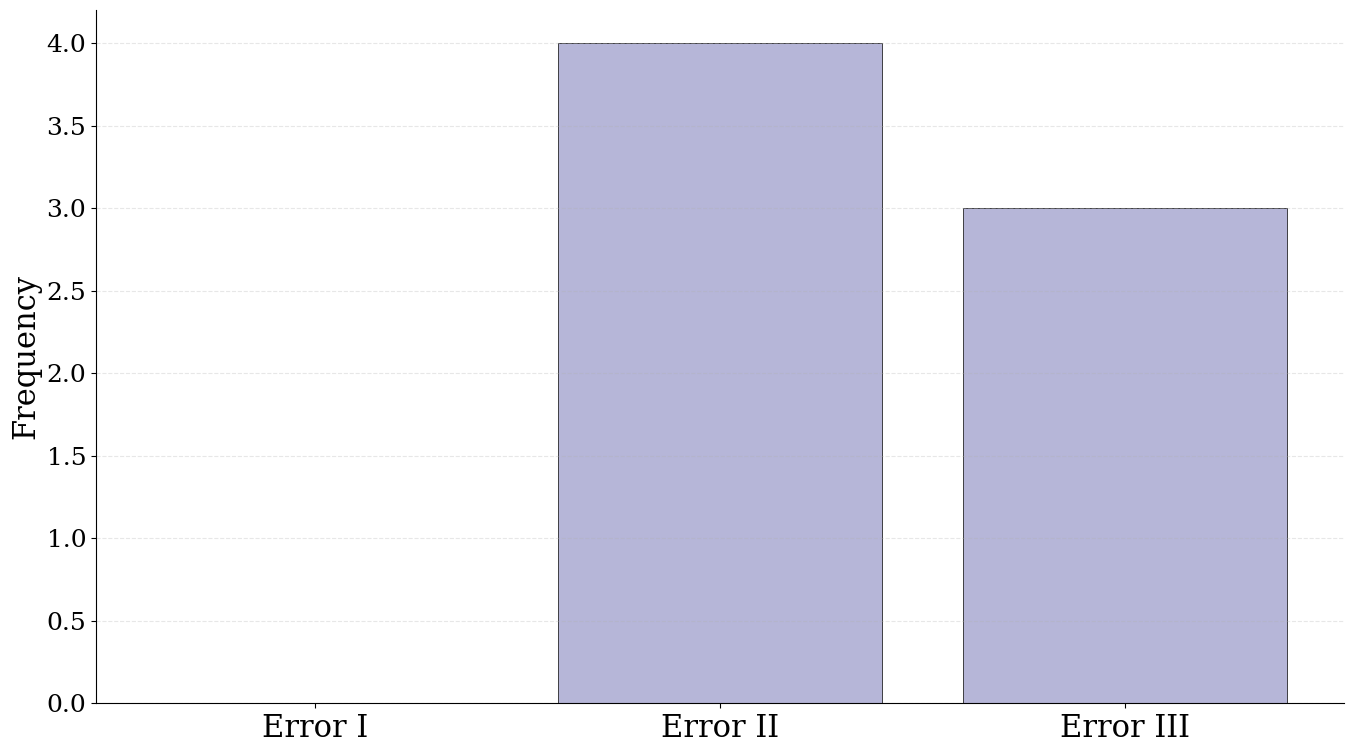


Summary for Quitting:
  Error 1: 0 occurrences
  Error 2: 4 occurrences
  Error 3: 3 occurrences
  Total across all errors: 7
Breakdown by specific reactions:
  quitting: 7 times
Creating histogram for: Frustration
Found 20 reactions for this category
Grouped data:
subcode_readable  frustration
error                        
1                           0
2                           6
3                          14
Plot saved to plots/frustration_annotations_histogram.png


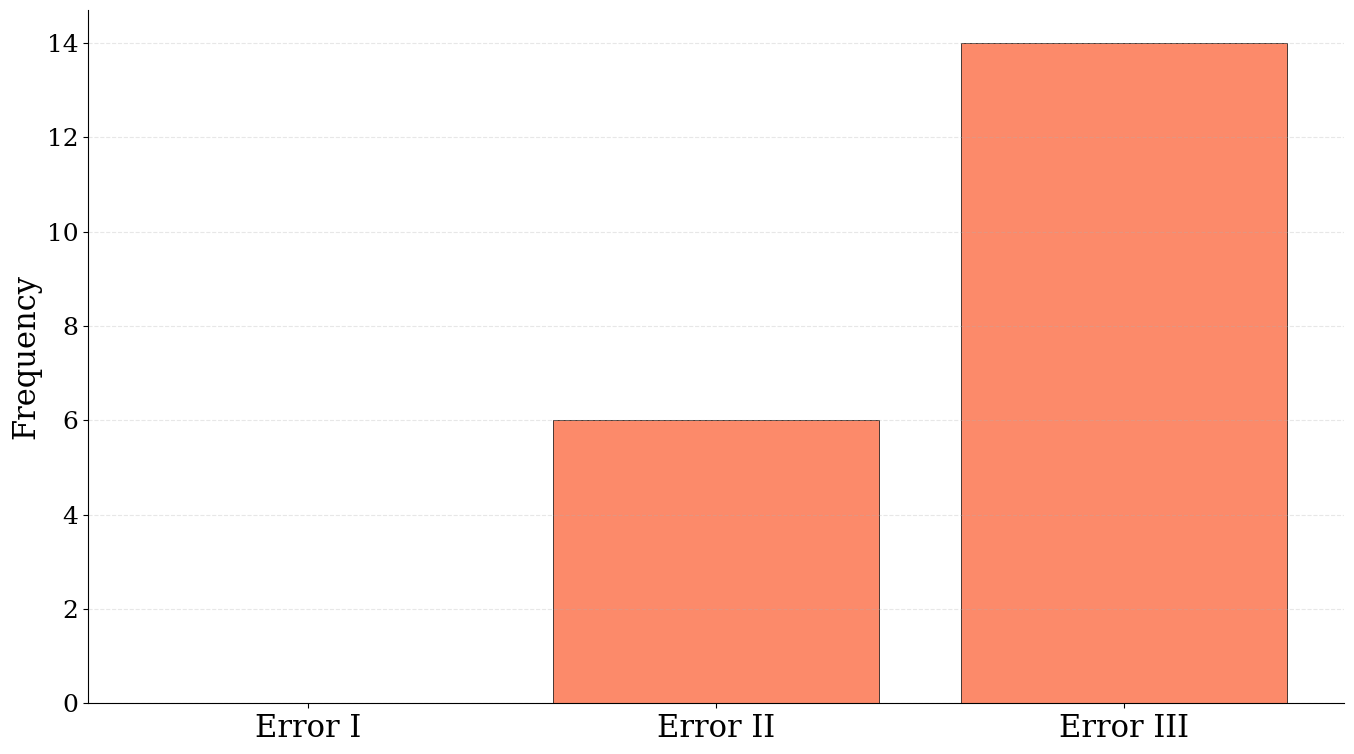


Summary for Frustration:
  Error 1: 0 occurrences
  Error 2: 6 occurrences
  Error 3: 14 occurrences
  Total across all errors: 20
Breakdown by specific reactions:
  frustration: 20 times
Creating histogram for: Humor
Found 9 reactions for this category
Grouped data:
subcode_readable  amusement/humor
error                            
1                               3
2                               2
3                               4
Plot saved to plots/humor_annotations_histogram.png


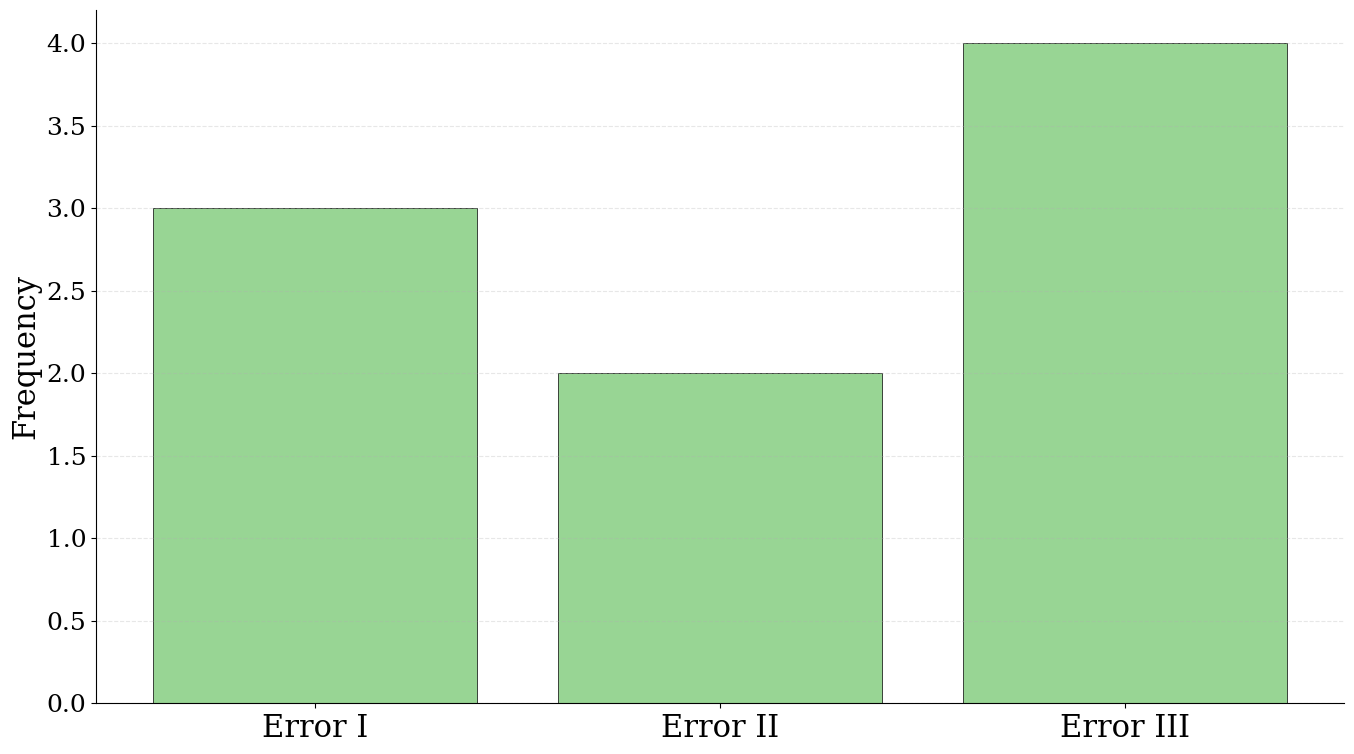


Summary for Humor:
  Error 1: 3 occurrences
  Error 2: 2 occurrences
  Error 3: 4 occurrences
  Total across all errors: 9
Breakdown by specific reactions:
  amusement/humor: 9 times
Creating histogram for: Looking at PC
Found 33 reactions for this category
Grouped data:
subcode_readable  looks at PC
error                        
1                          11
2                          12
3                          10
Plot saved to plots/looking_pc_annotations_histogram.png


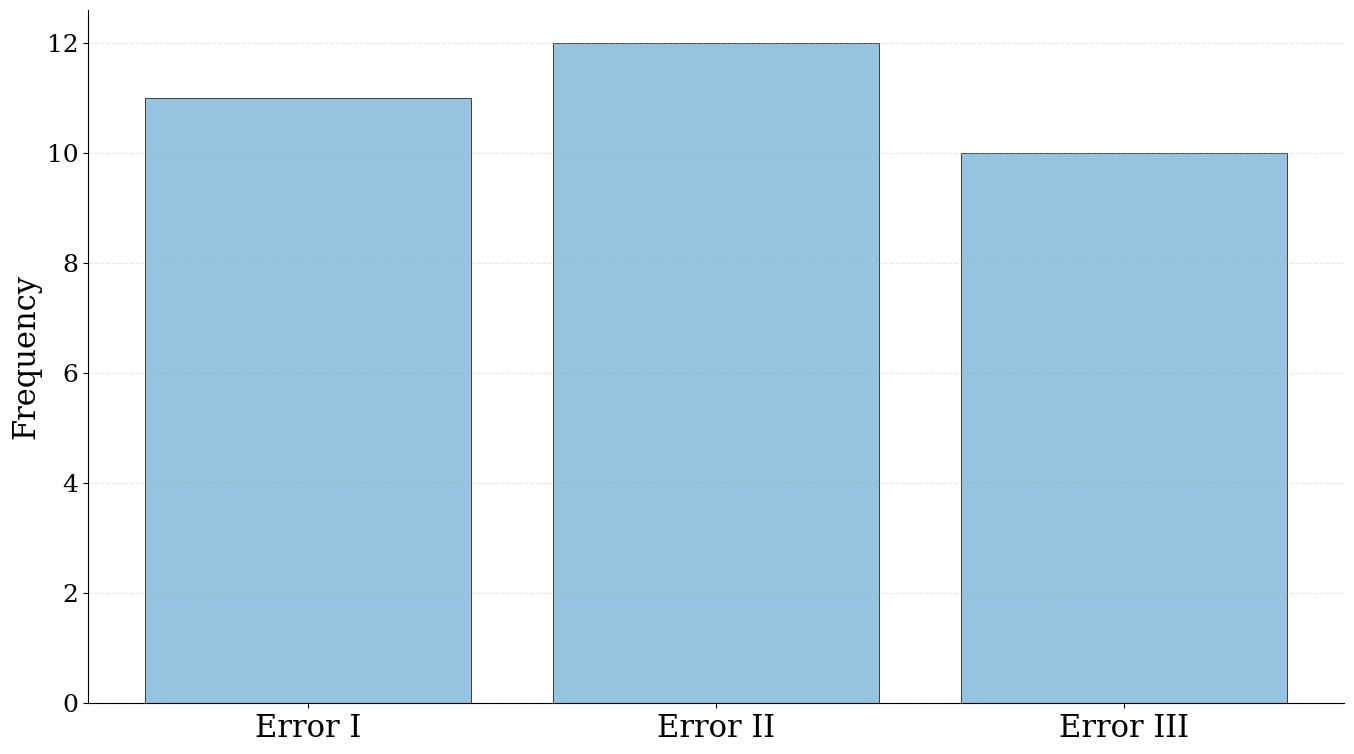


Summary for Looking at PC:
  Error 1: 11 occurrences
  Error 2: 12 occurrences
  Error 3: 10 occurrences
  Total across all errors: 33
Breakdown by specific reactions:
  looks at PC: 33 times
Creating histogram for: Confusion
Found 28 reactions for this category
Grouped data:
subcode_readable  confusion
error                      
1                        11
2                         8
3                         9
Plot saved to plots/confusion_annotations_histogram.png


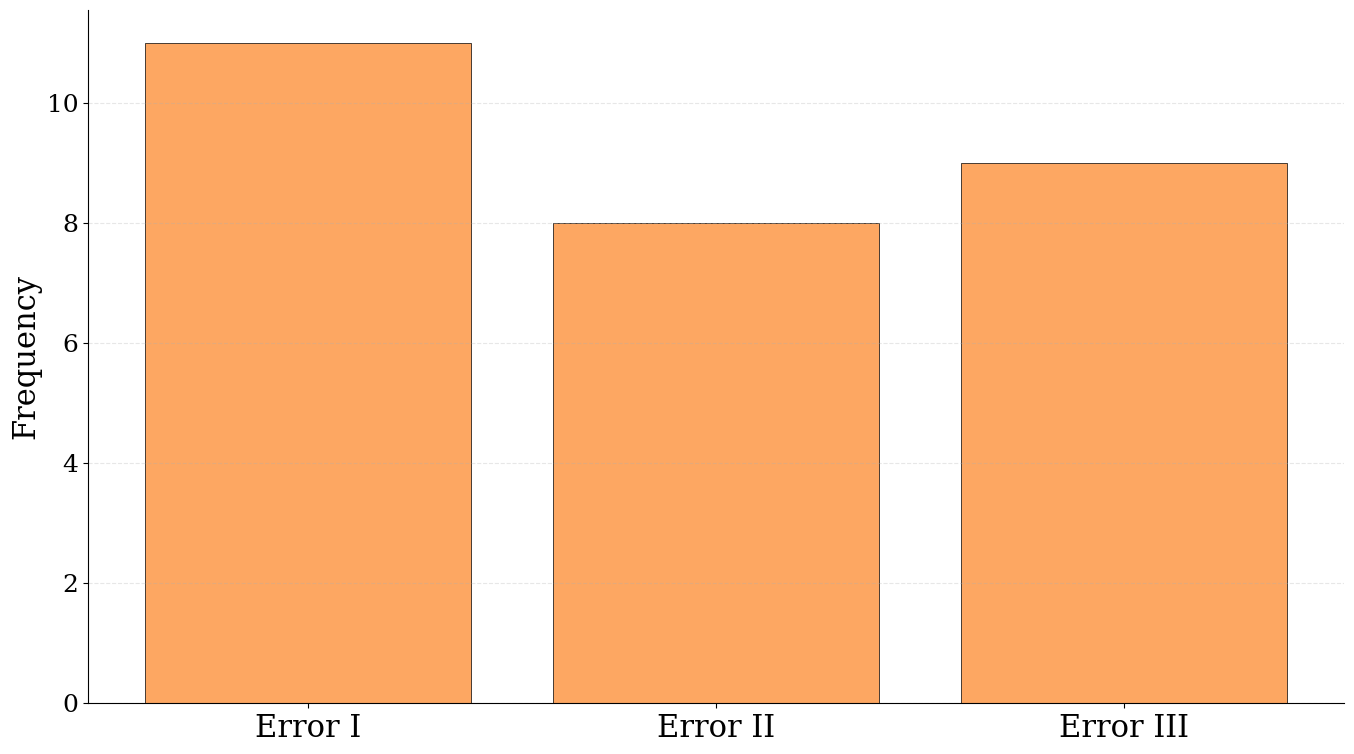


Summary for Confusion:
  Error 1: 11 occurrences
  Error 2: 8 occurrences
  Error 3: 9 occurrences
  Total across all errors: 28
Breakdown by specific reactions:
  confusion: 28 times
Creating histogram for: Physical Disengagement
Found 5 reactions for this category
Grouped data:
subcode_readable  stands up  leaves room
error                                   
1                         1            0
2                         0            2
3                         0            2
Plot saved to plots/physical_disengagement_annotations_histogram.png


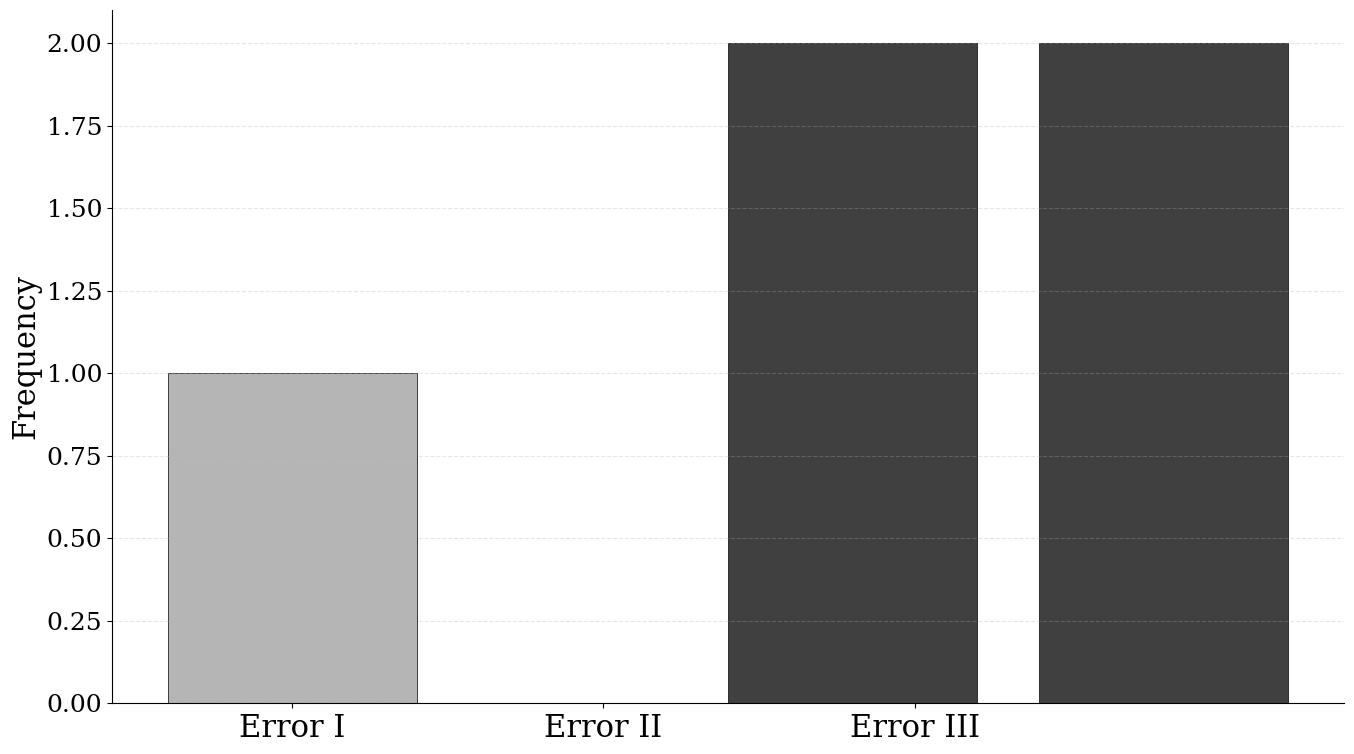


Summary for Physical Disengagement:
  Error 1: 1 occurrences
  Error 2: 2 occurrences
  Error 3: 2 occurrences
  Total across all errors: 5
Breakdown by specific reactions:
  leaves room: 4 times
  stands up: 1 times
Creating histogram for: Seeking Help from Researcher
Found 29 reactions for this category
Grouped data:
subcode_readable  speaks to researcher  looks for researcher  \
error                                                          
1                                    3                     5   
2                                    0                    12   
3                                    1                     8   

subcode_readable  tries to look at researcher  
error                                          
1                                           0  
2                                           0  
3                                           0  
Plot saved to plots/seeking_help_annotations_histogram.png


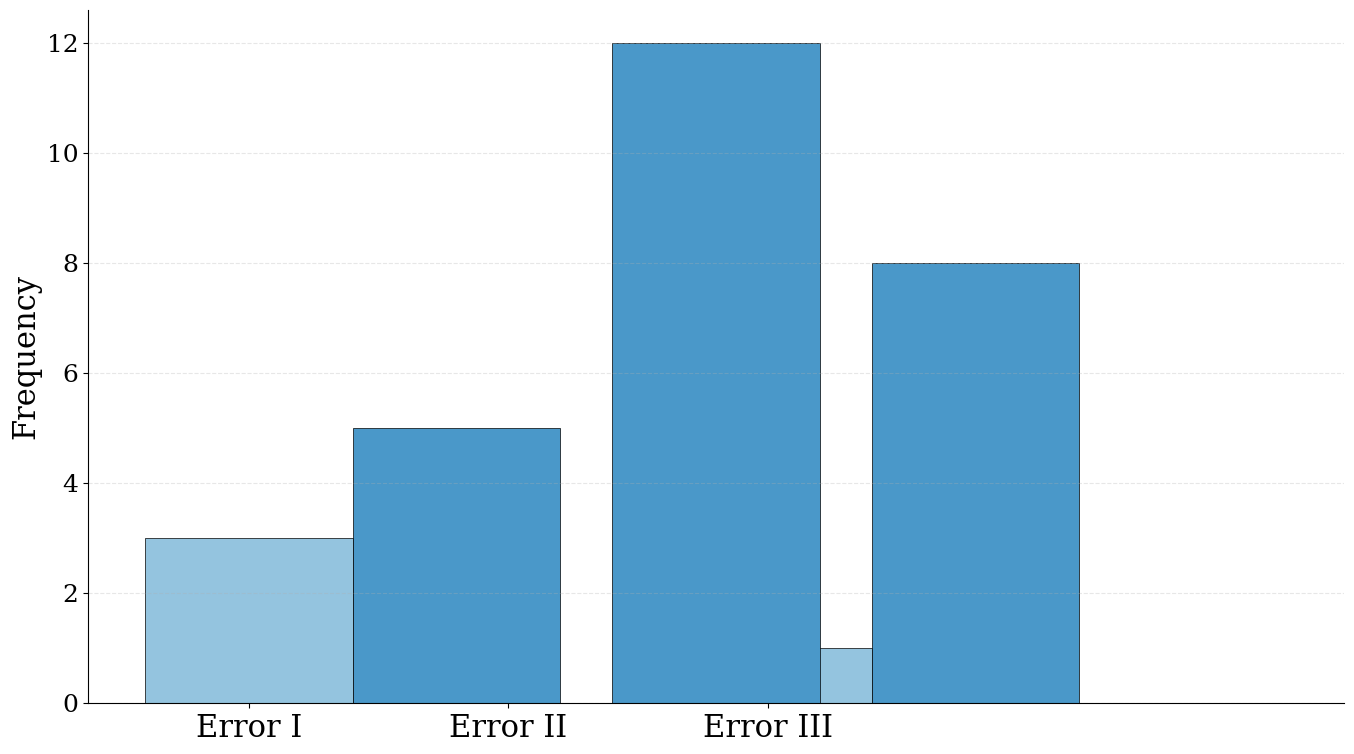


Summary for Seeking Help from Researcher:
  Error 1: 8 occurrences
  Error 2: 12 occurrences
  Error 3: 9 occurrences
  Total across all errors: 29
Breakdown by specific reactions:
  looks for researcher: 25 times
  speaks to researcher: 4 times


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_single_category_histogram(annotation_list, annotation_name, colormap, filename_suffix):
    """
    Create a simple bar chart for a single annotation category across errors
    
    Parameters:
    - annotation_list: List of specific annotations to include (can be just one)
    - annotation_name: Name for the category
    - colormap: Matplotlib colormap to use
    - filename_suffix: Suffix for the saved filename
    """
    
    # Read the reactions data
    print(f"Creating histogram for: {annotation_name}")
    data = pd.read_csv('reactions_between_errors.csv')
    
    # Filter data to only include annotations in our list
    data_filtered = data[data['subcode_readable'].isin(annotation_list)].copy()
    
    print(f"Found {len(data_filtered)} reactions for this category")
    
    if len(data_filtered) == 0:
        print(f"WARNING: No reactions found for {annotation_name}")
        print("Available subcode_readable values:", data['subcode_readable'].unique())
        return
    
    # Group by error and subcode_readable to get frequency matrix
    grouped_data = data_filtered.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    
    # Ensure we have all errors (1, 2, 3) even if some are missing
    all_errors = [1, 2, 3]
    grouped_data = grouped_data.reindex(index=all_errors, fill_value=0)
    
    # Ensure we have all annotations even if some don't appear
    grouped_data = grouped_data.reindex(columns=annotation_list, fill_value=0)
    
    print("Grouped data:")
    print(grouped_data)
    
    # Set up the plot
    errors = grouped_data.index
    annotations = grouped_data.columns
    bar_width = 0.8
    x_positions = np.arange(len(errors))
    
    # Create the figure
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Generate colors
    colors = colormap(np.linspace(0.4, 0.8, len(annotations)))
    
    # Create bars for each annotation
    for i, (annotation, color) in enumerate(zip(annotations, colors)):
        plt.bar(
            x_positions + i * bar_width,
            grouped_data[annotation],
            width=bar_width,
            label=annotation,
            color=color,
            edgecolor='black',
            linewidth=0.5
        )
    
    # Customize the plot
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(x_positions, x_labels, fontsize=22)
    plt.ylabel("Frequency", fontsize=22)
    plt.yticks(fontsize=18)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/{filename_suffix}_annotations_histogram.png'
    plt.savefig(filename, format='png', dpi=500, bbox_inches='tight')
    print(f"Plot saved to {filename}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {annotation_name}:")
    total_per_error = grouped_data.sum(axis=1)
    for error_num in [1, 2, 3]:
        count = total_per_error.get(error_num, 0)
        print(f"  Error {error_num}: {count} occurrences")
    
    total_overall = data_filtered.shape[0]
    print(f"  Total across all errors: {total_overall}")
    
    if total_overall > 0:
        print(f"Breakdown by specific reactions:")
        overall_freq = data_filtered['subcode_readable'].value_counts()
        for reaction, count in overall_freq.items():
            print(f"  {reaction}: {count} times")

# Example usage - Quitting behavior
plot_single_category_histogram(
    annotation_list=["quitting"],
    annotation_name="Quitting",
    colormap=cm.Purples,
    filename_suffix="quitting"
)

# Example usage - Other single categories
plot_single_category_histogram(
    annotation_list=["frustration"],
    annotation_name="Frustration",
    colormap=cm.Reds,
    filename_suffix="frustration"
)

plot_single_category_histogram(
    annotation_list=["amusement/humor"],
    annotation_name="Humor",
    colormap=cm.Greens,
    filename_suffix="humor"
)

plot_single_category_histogram(
    annotation_list=["looks at PC"],
    annotation_name="Looking at PC",
    colormap=cm.Blues,
    filename_suffix="looking_pc"
)

plot_single_category_histogram(
    annotation_list=["confusion"],
    annotation_name="Confusion", 
    colormap=cm.Oranges,
    filename_suffix="confusion"
)

# Example with multiple similar reactions grouped together
plot_single_category_histogram(
    annotation_list=["stands up", "leaves room"],
    annotation_name="Physical Disengagement",
    colormap=cm.Greys,
    filename_suffix="physical_disengagement"  
)

plot_single_category_histogram(
    annotation_list=["speaks to researcher", "looks for researcher", "tries to look at researcher"],
    annotation_name="Seeking Help from Researcher",
    colormap=cm.Blues,
    filename_suffix="seeking_help"
)

# Convenience function to plot common single categories
def plot_common_single_categories():
    """Plot histograms for common single-reaction categories"""
    
    single_categories = {
        "Quitting": {
            "list": ["quitting"],
            "colormap": cm.Purples,
            "suffix": "quitting"
        },
        "Frustration": {
            "list": ["frustration"], 
            "colormap": cm.Reds,
            "suffix": "frustration"
        },
        "Humor/Amusement": {
            "list": ["amusement/humor"],
            "colormap": cm.Greens, 
            "suffix": "humor"
        },
        "Confusion": {
            "list": ["confusion"],
            "colormap": cm.Oranges,
            "suffix": "confusion"
        },
        "Looking at PC": {
            "list": ["looks at PC"],
            "colormap": cm.Blues,
            "suffix": "looking_pc"
        },
        "Physical Movement": {
            "list": ["changes position", "stands up"],
            "colormap": cm.Greys,
            "suffix": "movement"
        }
    }
    
    for category_name, config in single_categories.items():
        print("\n" + "="*60)
        plot_single_category_histogram(
            annotation_list=config["list"],
            annotation_name=category_name,
            colormap=config["colormap"],
            filename_suffix=config["suffix"]
        )

# Uncomment to plot all single categories
# plot_common_single_categories()

Loading reactions_between_errors.csv...
Loaded 422 reaction events
Available subcode_readable values: ["'please'", 'amusement/humor', 'assertive tone', 'changes position', 'confusion', 'demanding tone', 'does not stand up', 'filler words', 'frustration', 'interrogative tone', 'leaves room', 'looks at PC', 'looks at robot', 'looks for researcher', 'makes new prompt', 'more specific/longer prompt', 'moves closer to robot', 'no prompt', 'quitting', 'repeats prompt', 'simpler prompt', 'slower speech', 'speaks to researcher', 'stands up', 'swaps terms']
Note: The following reactions were categorized as 'other': ['does not stand up']
Grouped data (raw counts):
reaction_category  repeats prompt  more specific/longer prompt  swaps terms  \
error                                                                         
1                              23                           12            1   
2                              12                            6            1   
3                    

<Figure size 1400x1400 with 0 Axes>

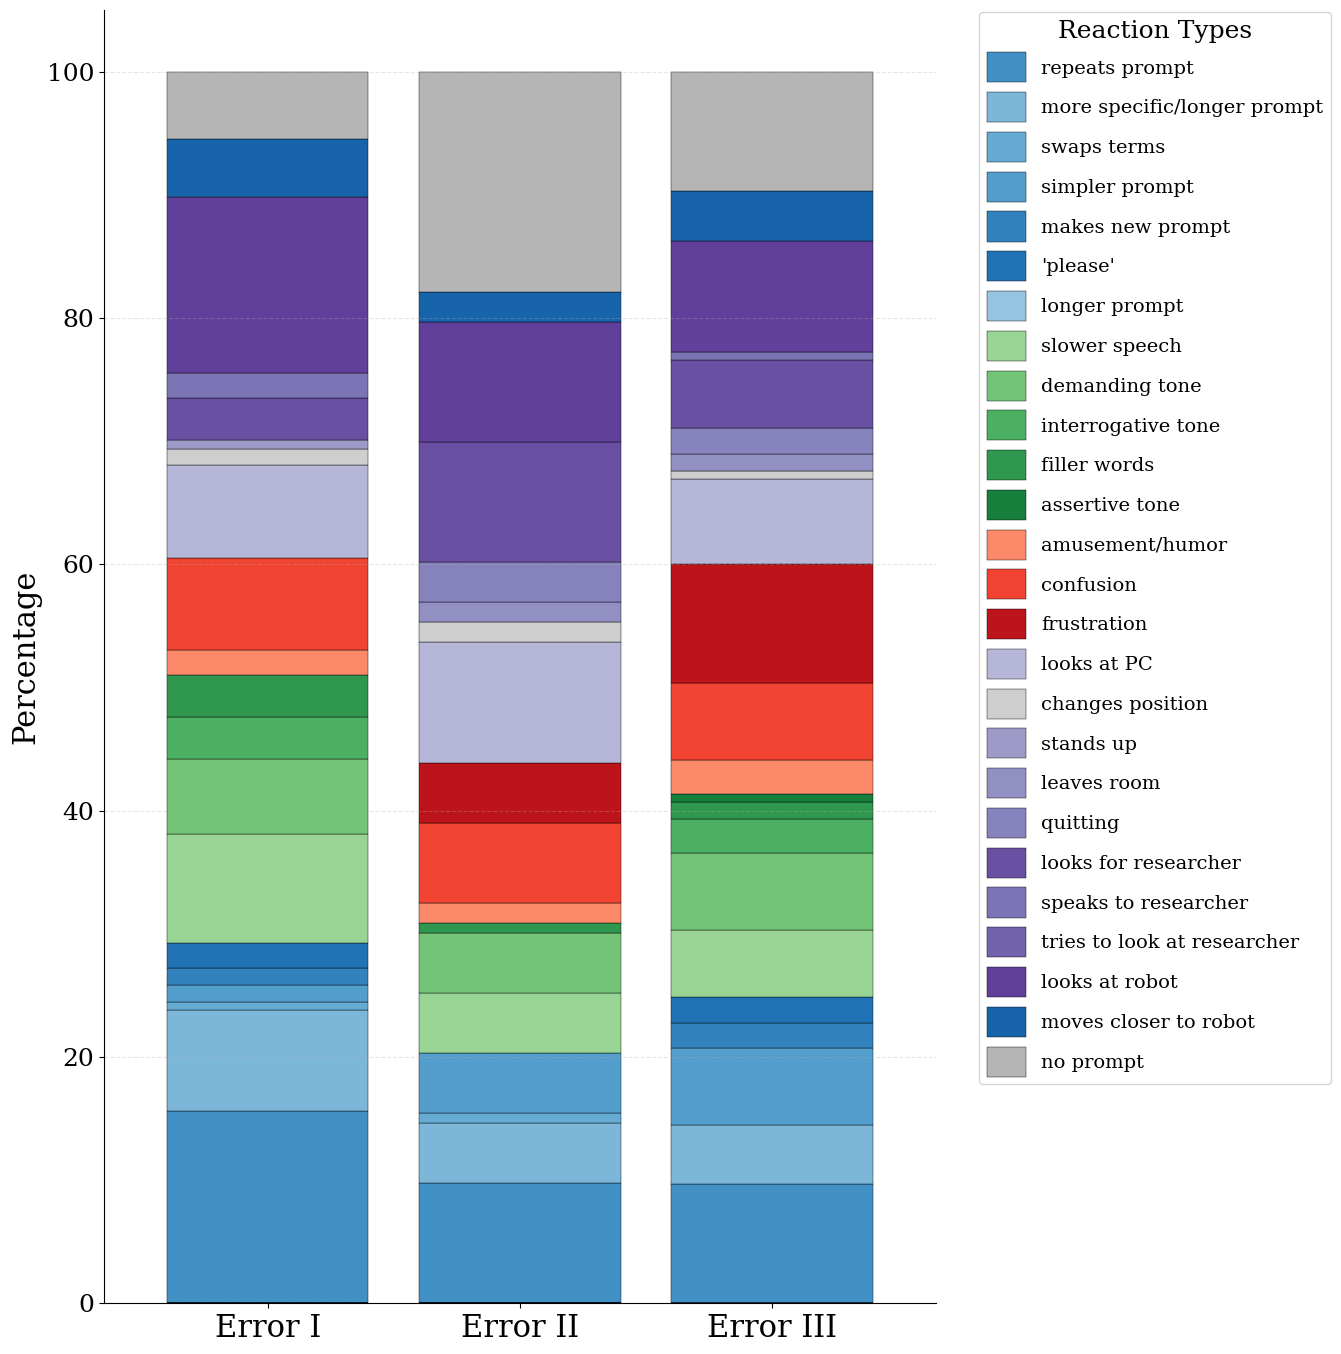


DETAILED STATISTICS

Error 1:
  Total reactions: 147
  Breakdown:
    repeats prompt: 23 (15.6%)
    more specific/longer prompt: 12 (8.2%)
    swaps terms: 1 (0.7%)
    simpler prompt: 2 (1.4%)
    makes new prompt: 2 (1.4%)
    'please': 3 (2.0%)
    slower speech: 13 (8.8%)
    demanding tone: 9 (6.1%)
    interrogative tone: 5 (3.4%)
    filler words: 5 (3.4%)
    amusement/humor: 3 (2.0%)
    confusion: 11 (7.5%)
    looks at PC: 11 (7.5%)
    changes position: 2 (1.4%)
    stands up: 1 (0.7%)
    looks for researcher: 5 (3.4%)
    speaks to researcher: 3 (2.0%)
    looks at robot: 21 (14.3%)
    moves closer to robot: 7 (4.8%)
    no prompt: 8 (5.4%)

Error 2:
  Total reactions: 123
  Breakdown:
    repeats prompt: 12 (9.8%)
    more specific/longer prompt: 6 (4.9%)
    swaps terms: 1 (0.8%)
    simpler prompt: 6 (4.9%)
    slower speech: 6 (4.9%)
    demanding tone: 6 (4.9%)
    filler words: 1 (0.8%)
    amusement/humor: 2 (1.6%)
    confusion: 8 (6.5%)
    frustration: 6 (4.9

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def create_stacked_percentage_chart():
    """Create a stacked percentage bar chart showing reaction distribution across errors"""
    
    # Use all annotations from the expanded lists
    annotation_list = (reprompting_list + verbal_tone_list + emotion_list + 
                      [item for item in disengagement_list if item not in reprompting_list + verbal_tone_list + emotion_list])
    
    # Use the updated categories (already declared in notebook)
    # categories variable is already available
    
    # Use the updated category_colormaps (already declared in notebook)
    # category_colormaps variable is already available
    
    def get_shaded_colors(cmap, labels):
        """Generate shaded colors for labels in a category"""
        return cmap(np.linspace(0.4, 0.8, len(labels)))
    
    # Create label color mapping using the updated categories and colormaps
    label_colors = {}
    for category, labels in categories.items():
        if category in category_colormaps:
            cmap = category_colormaps[category]
            shades = get_shaded_colors(cmap, labels)
            label_colors.update(dict(zip(labels, shades)))
    
    # Read the reactions data
    print("Loading reactions_between_errors.csv...")
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} reaction events")
    print(f"Available subcode_readable values: {sorted(data['subcode_readable'].unique())}")
    
    # Filter data to only include annotations in our list, or mark as "other"
    data_filtered = data.copy()
    data_filtered['reaction_category'] = data_filtered['subcode_readable'].apply(
        lambda x: x if x in annotation_list else "other"
    )
    #print which ones are not in annotation_list
    unknown_reactions = data_filtered[~data_filtered['subcode_readable'].isin(annotation_list)]['subcode_readable'].unique()
    if len(unknown_reactions) > 0:
        print(f"Note: The following reactions were categorized as 'other': {unknown_reactions}")
    
    # Group by error and reaction category
    grouped_data = data_filtered.groupby(['error', 'reaction_category']).size().unstack(fill_value=0)
    
    # Ensure we have all errors (1, 2, 3)
    grouped_data = grouped_data.reindex(index=[1, 2, 3], fill_value=0)
    
    # Add "other" to annotation list if it appears in data
    if "other" in grouped_data.columns:
        annotation_list_with_other = annotation_list + ["other"]
        label_colors["other"] = cm.Greys(0.5)  # Grey color for "other"
    else:
        annotation_list_with_other = annotation_list

    #temp:
    annotation_list_with_other = annotation_list

    # Reindex to include all annotations
    grouped_data = grouped_data.reindex(columns=annotation_list_with_other, fill_value=0)
    
    print("Grouped data (raw counts):")
    print(grouped_data)
    
    # Calculate percentages
    row_sums = grouped_data.sum(axis=1)
    print(f"\nTotal reactions per error: {row_sums.to_dict()}")
    
    # Handle cases where there are no reactions for an error
    grouped_data_percentage = grouped_data.div(row_sums, axis=0).fillna(0) * 100
    
    print("Grouped data (percentages):")
    print(grouped_data_percentage)
    
    # Create the plot
    plt.figure(figsize=(14, 14), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Get colors for the plot, with fallback for uncategorized items
    colors = []
    for label in grouped_data_percentage.columns:
        if label in label_colors:
            colors.append(label_colors[label])
        elif label == "other":
            colors.append(cm.Greys(0.5))
        else:
            # Fallback color for uncategorized items
            colors.append(cm.Greys(0.3))
    
    # Create stacked bar chart
    ax = grouped_data_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 14),
        width=0.8,
        color=colors,
        edgecolor='black',
        linewidth=0.3
    )
    
    ax.set_facecolor('white')
    
    # Customize the plot
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(np.arange(len(grouped_data.index)), x_labels, fontsize=22, rotation=0)
    plt.xlabel("", fontsize=22)
    plt.ylabel("Percentage", fontsize=22)
    plt.yticks(fontsize=18)
    
    # Add legend
    plt.legend(
        title="Reaction Types",
        title_fontsize=18,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=14,
        handleheight=2,
        handlelength=2,
        borderaxespad=0.1
    )
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add horizontal grid lines
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('plots/percentage_annotations_stacked.png', format='png', dpi=500, facecolor="white", bbox_inches='tight')
    print("Plot saved to 'plots/percentage_annotations_stacked.png'")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    
    for error_num in [1, 2, 3]:
        print(f"\nError {error_num}:")
        total_reactions = row_sums.get(error_num, 0)
        print(f"  Total reactions: {total_reactions}")
        
        if total_reactions > 0:
            error_data = grouped_data.loc[error_num]
            error_percentages = grouped_data_percentage.loc[error_num]
            
            print("  Breakdown:")
            for reaction in annotation_list_with_other:
                count = error_data.get(reaction, 0)
                percentage = error_percentages.get(reaction, 0)
                if count > 0:
                    print(f"    {reaction}: {count} ({percentage:.1f}%)")
        else:
            print("  No reactions recorded")
    
    # Category-level analysis
    print(f"\n" + "="*60)
    print("CATEGORY-LEVEL ANALYSIS")
    print("="*60)
    
    for category, reactions in categories.items():
        print(f"\n{category.upper()}:")
        category_totals = {}
        for error_num in [1, 2, 3]:
            total = sum(grouped_data.loc[error_num, reaction] for reaction in reactions if reaction in grouped_data.columns)
            category_totals[error_num] = total
        
        total_overall = sum(category_totals.values())
        print(f"  Total across all errors: {total_overall}")
        for error_num, total in category_totals.items():
            if row_sums.get(error_num, 0) > 0:
                percentage = (total / row_sums[error_num]) * 100
                print(f"  Error {error_num}: {total} reactions ({percentage:.1f}% of error)")
            else:
                print(f"  Error {error_num}: {total} reactions (no data for this error)")

# Run the function
create_stacked_percentage_chart()

# Alternative version with different annotation selections
def create_custom_stacked_chart(annotation_subset, chart_title, filename_suffix):
    """Create a custom stacked chart with a subset of annotations"""
    
    print(f"\n" + "="*60)
    print(f"CREATING CUSTOM CHART: {chart_title}")
    print("="*60)
    
    # Read the data
    data = pd.read_csv('reactions_between_errors.csv')
    
    # Filter to only selected annotations
    data_filtered = data[data['subcode_readable'].isin(annotation_subset)].copy()
    
    if len(data_filtered) == 0:
        print(f"No data found for selected annotations: {annotation_subset}")
        return
    
    # Group by error and reaction
    grouped_data = data_filtered.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    grouped_data = grouped_data.reindex(index=[1, 2, 3], fill_value=0)
    grouped_data = grouped_data.reindex(columns=annotation_subset, fill_value=0)
    
    # Calculate percentages
    row_sums = grouped_data.sum(axis=1)
    grouped_data_percentage = grouped_data.div(row_sums, axis=0).fillna(0) * 100
    
    # Simple color scheme
    colors = cm.Set3(np.linspace(0, 1, len(annotation_subset)))
    
    # Create plot
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.rcParams.update({'font.size': 18})
    
    ax = grouped_data_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        width=0.8,
        color=colors,
        edgecolor='black',
        linewidth=0.3
    )
    
    # Formatting
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(range(3), x_labels, rotation=0)
    plt.xlabel("")
    plt.ylabel("Percentage")
    plt.title(chart_title, fontsize=20, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'plots/{filename_suffix}_stacked.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    
    print(f"Custom chart saved to 'plots/{filename_suffix}_stacked.png'")

# Example custom charts
# create_custom_stacked_chart(
#     ["amusement/humor", "confusion", "frustration"],
#     "Emotional Reactions Across Errors", 
#     "emotions_only"
# )

# create_custom_stacked_chart(
#     ["repeats prompt", "simpler prompt", "more specific/longer prompt"],
#     "Prompting Strategies Across Errors",
#     "prompting_only" 
# )

Loading reactions_between_errors.csv...
Loaded 422 reaction events
Available subcode_readable values: ["'please'", 'amusement/humor', 'assertive tone', 'changes position', 'confusion', 'demanding tone', 'does not stand up', 'filler words', 'frustration', 'interrogative tone', 'leaves room', 'looks at PC', 'looks at robot', 'looks for researcher', 'makes new prompt', 'more specific/longer prompt', 'moves closer to robot', 'no prompt', 'quitting', 'repeats prompt', 'simpler prompt', 'slower speech', 'speaks to researcher', 'stands up', 'swaps terms']
Found 14 'other' labels: ['frustration', 'no prompt', 'quitting', 'looks at PC', 'confusion', 'changes position', 'leaves room', 'does not stand up', 'looks at robot', 'amusement/humor', 'looks for researcher', 'stands up', 'moves closer to robot', 'speaks to researcher']
Color assignments: ['repeats prompt', 'more specific/longer prompt', 'swaps terms', 'simpler prompt', 'makes new prompt', "'please'", 'longer prompt', 'slower speech', 'dem

<Figure size 1400x1400 with 0 Axes>

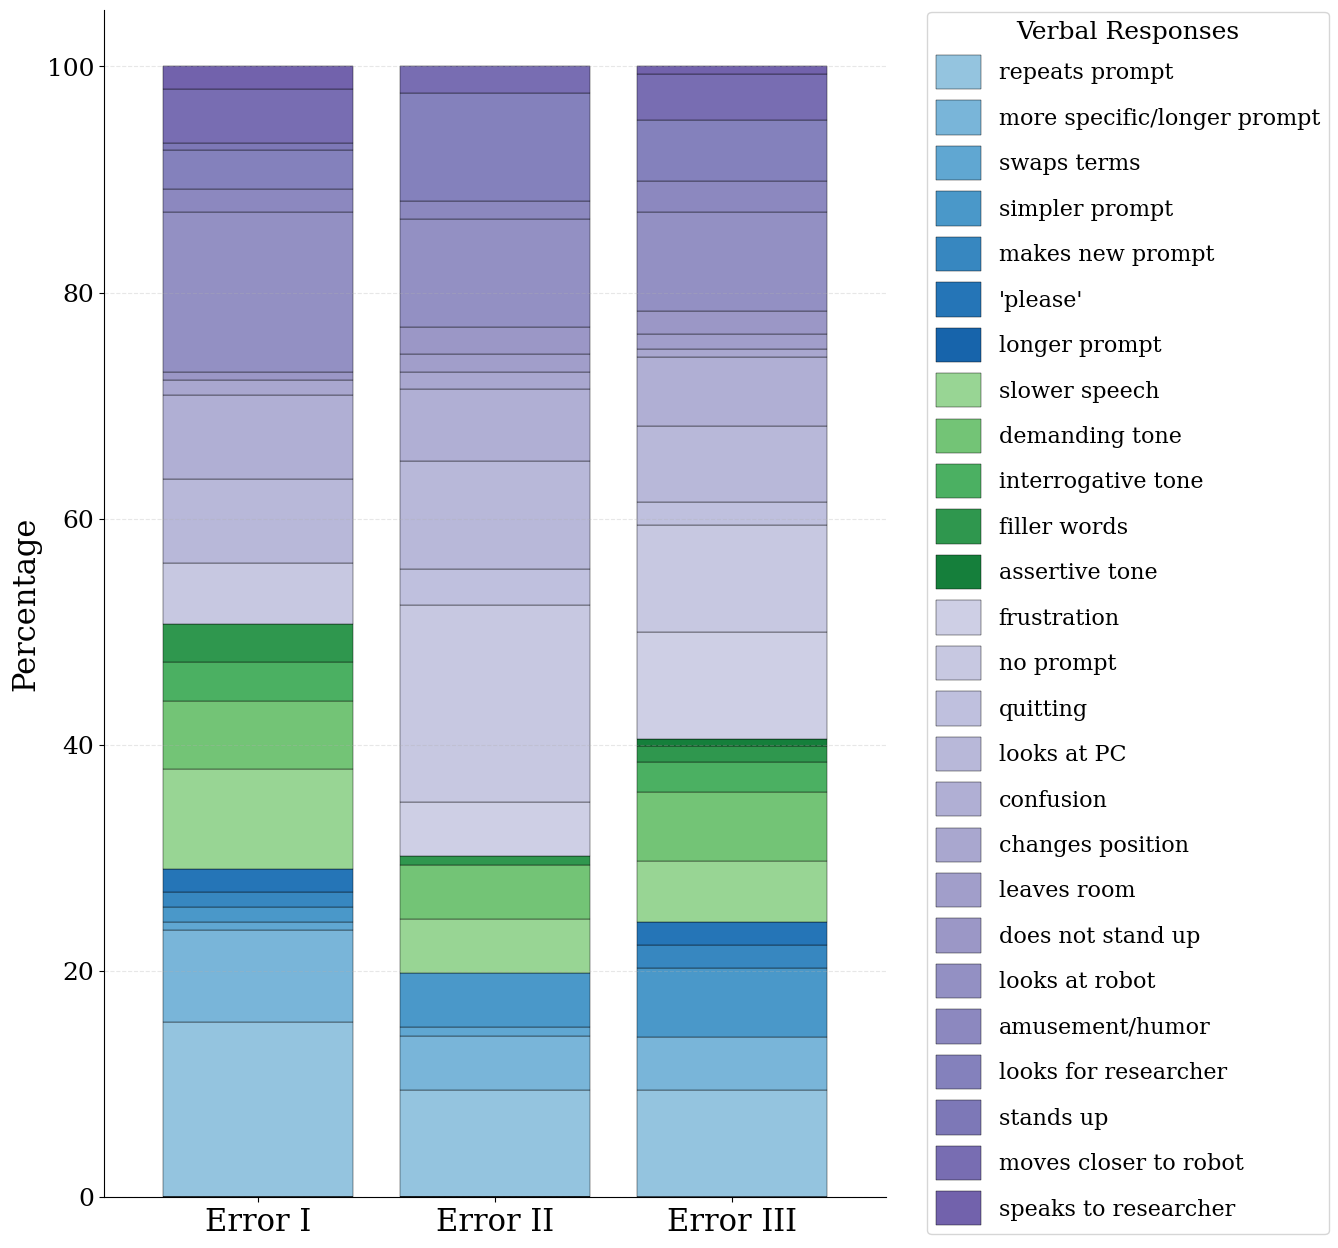


VERBAL RESPONSE ANALYSIS

Error 1:
  Total reactions: 148
error data: {'repeats prompt': 23, 'more specific/longer prompt': 12, 'swaps terms': 1, 'simpler prompt': 2, 'makes new prompt': 2, "'please'": 3, 'longer prompt': 0, 'slower speech': 13, 'demanding tone': 9, 'interrogative tone': 5, 'filler words': 5, 'assertive tone': 0, 'frustration': 0, 'no prompt': 8, 'quitting': 0, 'looks at PC': 11, 'confusion': 11, 'changes position': 2, 'leaves room': 0, 'does not stand up': 1, 'looks at robot': 21, 'amusement/humor': 3, 'looks for researcher': 5, 'stands up': 1, 'moves closer to robot': 7, 'speaks to researcher': 3}
error percentages: {'repeats prompt': 15.54054054054054, 'more specific/longer prompt': 8.108108108108109, 'swaps terms': 0.6756756756756757, 'simpler prompt': 1.3513513513513513, 'makes new prompt': 1.3513513513513513, "'please'": 2.027027027027027, 'longer prompt': 0.0, 'slower speech': 8.783783783783784, 'demanding tone': 6.081081081081082, 'interrogative tone': 3.37837

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def create_verbal_stacked_chart():
    """Create a stacked percentage bar chart focused on verbal responses with dynamic 'other' category"""
    
    # Use the expanded lists from your updated variables
    annotation_list = reprompting_list + verbal_tone_list
    
    # Define initial categories for this verbal-focused analysis
    verbal_categories = {
        "reprompting strategies": reprompting_list,
        "verbal tone or cadence": verbal_tone_list,
        "other": []  # Will be populated dynamically
    }
    
    # Use relevant colormaps from your updated category_colormaps
    verbal_colormaps = {
        "reprompting strategies": category_colormaps["reprompting strategies"],
        "verbal tone or cadence": category_colormaps["verbal tone or cadence"],
        "other": cm.Purples
    }
    
    def get_shaded_colors(cmap, labels, lightest=False):
        """Generate shaded colors for labels in a category"""
        if len(labels) == 0:
            return []
        elif len(labels) == 1:
            return [cmap(0.6)]
        else:
            if lightest:
                return cmap(np.linspace(0.3, 0.7, len(labels)))
            else:
                return cmap(np.linspace(0.4, 0.8, len(labels)))
    
    # Read the reactions data
    print("Loading reactions_between_errors.csv...")
    data = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(data)} reaction events")
    print(f"Available subcode_readable values: {sorted(data['subcode_readable'].unique())}")
    
    # Identify labels that are in our main annotation list vs "other"
    data_processed = data.copy()
    data_processed['label_category'] = data_processed['subcode_readable'].apply(
        lambda x: x if x in annotation_list else "other"
    )
    
    # Find all the actual "other" labels that appear in the data
    all_labels = data['subcode_readable'].unique()
    other_labels = [label for label in all_labels if label not in annotation_list and pd.notna(label)]
    
    print(f"Found {len(other_labels)} 'other' labels: {other_labels}")
    
    # Add other labels to categories
    verbal_categories["other"].extend(other_labels)
    
    # Generate colors for all categories
    label_colors = {}
    for category, labels in verbal_categories.items():
        if len(labels) > 0:
            cmap = verbal_colormaps[category]
            lightest = (category == "other")  # Use lighter shades for "other" category
            shades = get_shaded_colors(cmap, labels, lightest=lightest)
            label_colors.update(dict(zip(labels, shades)))
    
    # Ensure "other" has a color even if no specific other labels
    if "other" not in label_colors:
        label_colors["other"] = cm.Purples(0.4)
    
    print(f"Color assignments: {list(label_colors.keys())}")
    
    # For the grouped analysis, we'll use individual other labels rather than just "other"
    data_for_grouping = data.copy()
    
    # Group by error and individual subcode_readable
    grouped_data = data_for_grouping.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    
    # Ensure we have all errors (1, 2, 3)
    grouped_data = grouped_data.reindex(index=[1, 2, 3], fill_value=0)
    
    # Create the column order: main annotations first, then other labels
    column_order = annotation_list + [label for label in other_labels if label in grouped_data.columns]
    
    # Add any missing columns with zeros
    for col in column_order:
        if col not in grouped_data.columns:
            grouped_data[col] = 0
    
    # Reindex with our desired column order
    grouped_data = grouped_data.reindex(columns=column_order, fill_value=0)
    
    print("Grouped data (raw counts):")
    print(grouped_data)
    
    # Calculate percentages
    row_sums = grouped_data.sum(axis=1)
    print(f"\nTotal reactions per error: {row_sums.to_dict()}")
    
    # Handle cases where there are no reactions for an error
    grouped_data_percentage = grouped_data.div(row_sums, axis=0).fillna(0) * 100
    
    print("Grouped data (percentages):")
    print(grouped_data_percentage.round(1))
    
    # Create the plot
    plt.figure(figsize=(14, 14), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Get colors for the plot
    colors = [label_colors.get(label, label_colors.get("other", cm.Purples(0.4))) 
              for label in grouped_data_percentage.columns]
    
    # Create stacked bar chart
    ax = grouped_data_percentage.plot(
        kind='bar', 
        stacked=True, 
        figsize=(14, 14), 
        width=0.8, 
        color=colors,
        edgecolor='black',
        linewidth=0.3
    )
    
    ax.set_facecolor('white')
    
    # Customize the plot
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(np.arange(len(grouped_data.index)), x_labels, fontsize=22, rotation=0)
    plt.xlabel("", fontsize=22)
    plt.ylabel("Percentage", fontsize=22)
    plt.yticks(fontsize=18)
    
    # Add legend
    plt.legend(
        title="Verbal Responses",
        title_fontsize=18,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=16,
        handleheight=2,
        handlelength=2,
        borderaxespad=0.1
    )
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add horizontal grid lines
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('plots/percentage_verbal_annotations.png', format='png', dpi=500, facecolor="white", bbox_inches='tight')
    print("Plot saved to 'plots/percentage_verbal_annotations.png'")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("VERBAL RESPONSE ANALYSIS")
    print("="*60)
    
    for error_num in [1, 2, 3]:
        print(f"\nError {error_num}:")
        total_reactions = row_sums.get(error_num, 0)
        print(f"  Total reactions: {total_reactions}")
        
        if total_reactions > 0:
            error_data = grouped_data.loc[error_num]
            error_percentages = grouped_data_percentage.loc[error_num]
            print("error data:", error_data.to_dict())
            print("error percentages:", error_percentages.to_dict())
            
            # Separate main categories from other
            print("  MAIN VERBAL RESPONSES:")
            for reaction in annotation_list:
                if reaction in grouped_data.columns:
                    count = error_data.get(reaction, 0)
                    percentage = error_percentages.get(reaction, 0)
                    print(count)
                    if count > 0:
                        print(f"    {reaction}: {count} ({percentage:.1f}%)")
            
            if other_labels:
                print("  OTHER RESPONSES:")
                for reaction in other_labels:
                    if reaction in grouped_data.columns:
                        count = error_data.get(reaction, 0)
                        percentage = error_percentages.get(reaction, 0)
                        if count > 0:
                            print(f"    {reaction}: {count} ({percentage:.1f}%)")
        else:
            print("  No reactions recorded")
    
    # Category-level summary
    print(f"\n" + "="*60)
    print("CATEGORY TOTALS")
    print("="*60)
    
    for category, reactions in verbal_categories.items():
        if not reactions:  # Skip empty categories
            continue
            
        print(f"\n{category.upper()}:")
        category_totals = {}
        for error_num in [1, 2, 3]:
            total = sum(grouped_data.loc[error_num, reaction] 
                       for reaction in reactions 
                       if reaction in grouped_data.columns)
            category_totals[error_num] = total
        
        total_overall = sum(category_totals.values())
        print(f"  Total across all errors: {total_overall}")
        for error_num, total in category_totals.items():
            if row_sums.get(error_num, 0) > 0:
                percentage = (total / row_sums[error_num]) * 100
                print(f"  Error {error_num}: {total} reactions ({percentage:.1f}% of error)")
            else:
                print(f"  Error {error_num}: {total} reactions (no data for this error)")

# Alternative function for custom verbal analysis
def create_custom_verbal_chart(main_annotations, other_threshold=0, title_suffix=""):
    """
    Create a custom verbal chart with specified main annotations
    
    Parameters:
    - main_annotations: List of main annotations to highlight
    - other_threshold: Minimum count for an annotation to be shown separately (others grouped as "other")
    - title_suffix: Additional text for the title and filename
    """
    
    print(f"\n" + "="*60)
    print(f"CREATING CUSTOM VERBAL CHART{': ' + title_suffix if title_suffix else ''}")
    print("="*60)
    
    # Read the data
    data = pd.read_csv('reactions_between_errors.csv')
    
    # Group by error and reaction
    grouped_data = data.groupby(['error', 'subcode_readable']).size().unstack(fill_value=0)
    grouped_data = grouped_data.reindex(index=[1, 2, 3], fill_value=0)
    
    # Determine which columns to show separately vs group as "other"
    total_counts = grouped_data.sum(axis=0)
    
    separate_columns = main_annotations.copy()
    for col in grouped_data.columns:
        if col not in main_annotations and total_counts[col] >= other_threshold:
            separate_columns.append(col)
    
    # Group remaining columns as "other"
    other_columns = [col for col in grouped_data.columns if col not in separate_columns]
    
    if other_columns:
        grouped_data['other'] = grouped_data[other_columns].sum(axis=1)
        final_columns = separate_columns + ['other']
    else:
        final_columns = separate_columns
    
    # Filter to final columns
    grouped_data_final = grouped_data.reindex(columns=final_columns, fill_value=0)
    
    # Calculate percentages
    row_sums = grouped_data_final.sum(axis=1)
    grouped_data_percentage = grouped_data_final.div(row_sums, axis=0).fillna(0) * 100
    
    # Simple color scheme
    colors = cm.Set2(np.linspace(0, 1, len(final_columns)))
    
    # Create plot
    plt.figure(figsize=(12, 12), facecolor='white')
    plt.rcParams.update({'font.size': 18})
    
    ax = grouped_data_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 12),
        width=0.9,
        color=colors,
        edgecolor='black',
        linewidth=0.3
    )
    
    # Formatting
    x_labels = ['Error I', 'Error II', 'Error III']
    plt.xticks(range(3), x_labels, rotation=0)
    plt.xlabel("")
    plt.ylabel("Percentage")
    title = f"Verbal Responses Across Errors{': ' + title_suffix if title_suffix else ''}"
    plt.title(title, fontsize=20, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    filename_suffix = f"_custom_verbal{'_' + title_suffix.lower().replace(' ', '_') if title_suffix else ''}"
    plt.savefig(f'plots/percentage{filename_suffix}.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    
    print(f"Custom verbal chart saved")
    
    if other_columns:
        print(f"Grouped as 'other': {other_columns}")

# Run the main function
create_verbal_stacked_chart()

# Example custom charts
# create_custom_verbal_chart(
#     main_annotations=["repeats prompt", "simpler prompt", "more specific/longer prompt"],
#     other_threshold=2,
#     title_suffix="Prompting Focus"
# )

Calculating response times for labels: ['more specific/longer prompt', 'simpler prompt', 'repeats prompt', 'swaps terms']
Extracting error start times from processed_codes.csv...
Processing participant: P1
Processing participant: P10
Processing participant: P11
Processing participant: P12
Processing participant: P13
Processing participant: P14
Processing participant: P15
Processing participant: P16
Processing participant: P18
Processing participant: P19
Processing participant: P2
Processing participant: P20
Processing participant: P21
Processing participant: P22
Processing participant: P23
Processing participant: P24
Processing participant: P25
Processing participant: P26
Processing participant: P27
Processing participant: P28
Processing participant: P29
Processing participant: P3
Processing participant: P30
Processing participant: P32
Processing participant: P33
Processing participant: P35
Processing participant: P36
Processing participant: P37
Processing participant: P38
Processing p

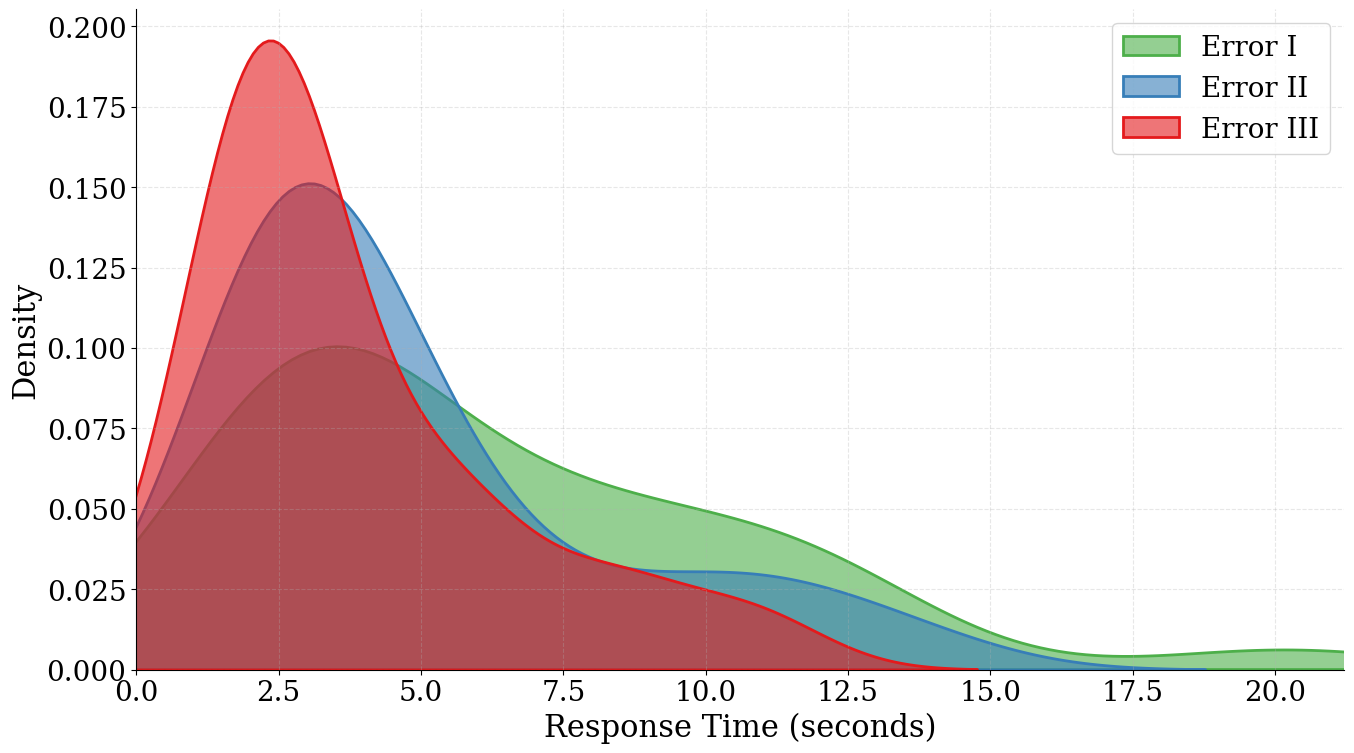


RESPONSE TIME STATISTICS

Error 1:
  Count: 38 responses
  Mean: 3.78s
  Median: 2.63s
  Std: 2.63s
  Range: 0.75s - 10.95s

Error 2:
  Count: 25 responses
  Mean: 4.79s
  Median: 3.04s
  Std: 3.31s
  Range: 1.75s - 13.56s

Error 3:
  Count: 30 responses
  Mean: 6.27s
  Median: 4.56s
  Std: 4.34s
  Range: 1.89s - 20.21s
Calculating response times for labels: ['repeats prompt', 'more specific/longer prompt', 'swaps terms', 'simpler prompt', 'slower speech', 'demanding tone', 'interrogative tone', 'filler words']
Extracting error start times from processed_codes.csv...
Processing participant: P1
Processing participant: P10
Processing participant: P11
Processing participant: P12
Processing participant: P13
Processing participant: P14
Processing participant: P15
Processing participant: P16
Processing participant: P18
Processing participant: P19
Processing participant: P2
Processing participant: P20
Processing participant: P21
Processing participant: P22
Processing participant: P23
Process

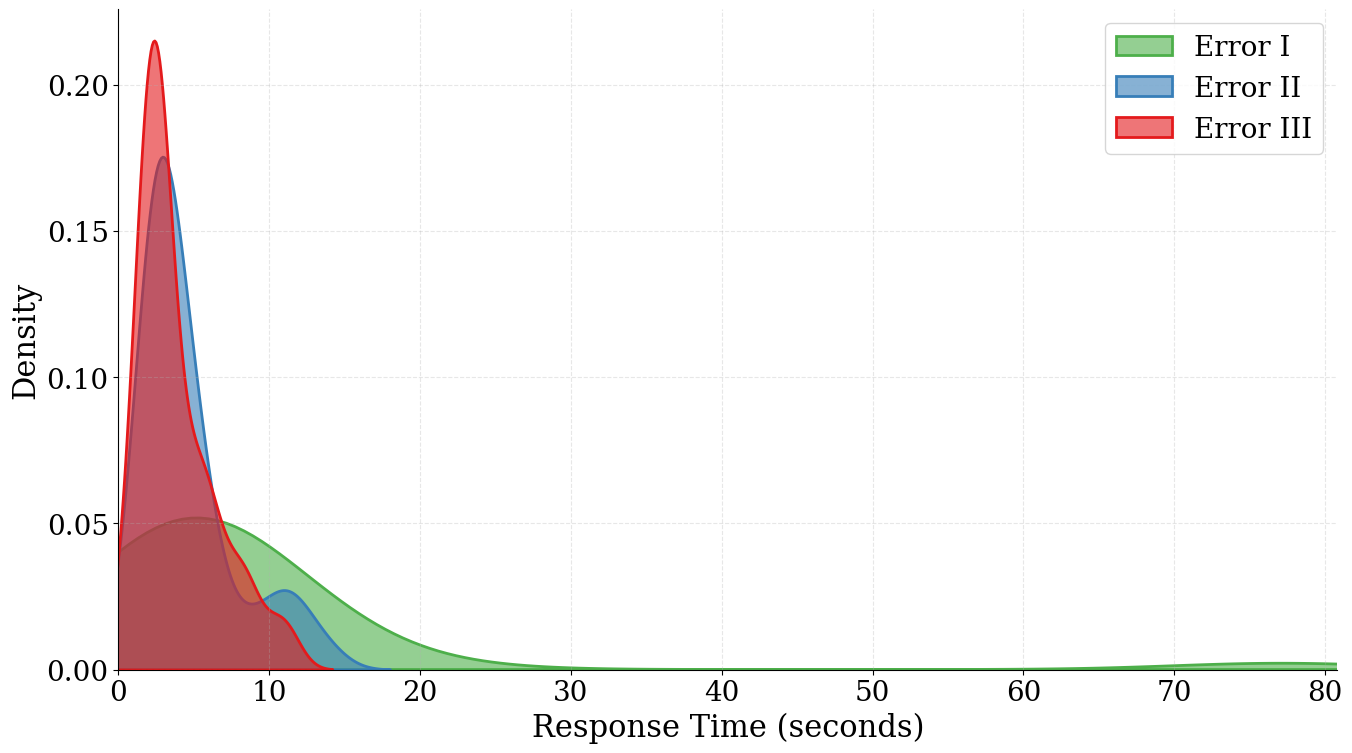


RESPONSE TIME STATISTICS

Error 1:
  Count: 70 responses
  Mean: 3.82s
  Median: 2.71s
  Std: 2.52s
  Range: 0.75s - 10.95s

Error 2:
  Count: 38 responses
  Mean: 4.49s
  Median: 3.01s
  Std: 3.07s
  Range: 1.75s - 13.56s

Error 3:
  Count: 53 responses
  Mean: 8.45s
  Median: 4.56s
  Std: 14.25s
  Range: 1.88s - 79.80s
Calculating response times for labels: ['amusement/humor', 'confusion', 'frustration']
Extracting error start times from processed_codes.csv...
Processing participant: P1
Processing participant: P10
Processing participant: P11
Processing participant: P12
Processing participant: P13
Processing participant: P14
Processing participant: P15
Processing participant: P16
Processing participant: P18
Processing participant: P19
Processing participant: P2
Processing participant: P20
Processing participant: P21
Processing participant: P22
Processing participant: P23
Processing participant: P24
Processing participant: P25
Processing participant: P26
Processing participant: P27
Pr

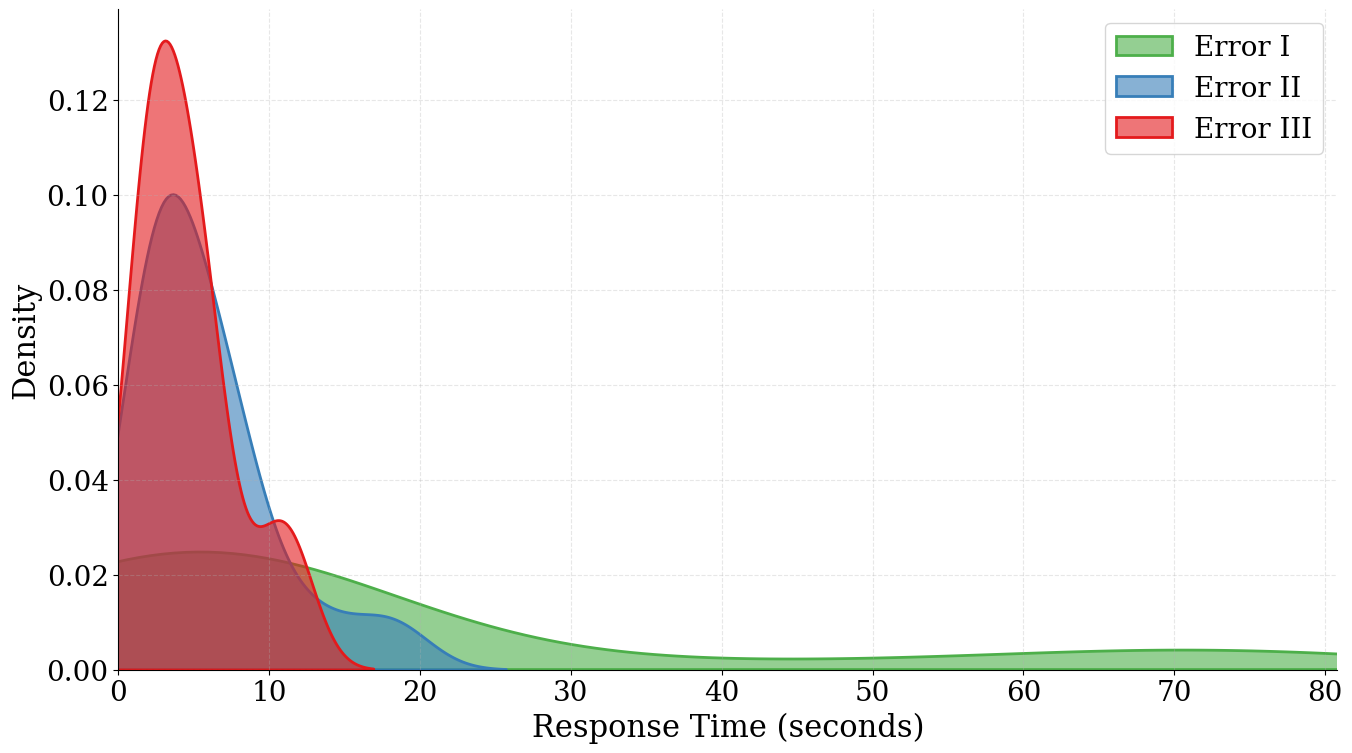


RESPONSE TIME STATISTICS

Error 1:
  Count: 14 responses
  Mean: 4.59s
  Median: 3.88s
  Std: 3.11s
  Range: 1.57s - 11.39s

Error 2:
  Count: 16 responses
  Mean: 5.70s
  Median: 3.78s
  Std: 4.45s
  Range: 1.77s - 18.01s

Error 3:
  Count: 27 responses
  Mean: 16.48s
  Median: 7.10s
  Std: 24.45s
  Range: 1.31s - 79.80s


In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def time_to_seconds(time_str):
    """Convert HH:MM:SS.fff to total seconds"""
    try:
        parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds_parts = parts[2].split('.')
        seconds = int(seconds_parts[0])
        milliseconds = int(seconds_parts[1]) if len(seconds_parts) > 1 else 0
        
        total_seconds = hours * 3600 + minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    except:
        return np.nan

def get_error_start_times():
    """Extract the start times for each error interval from processed_codes.csv"""
    
    print("Extracting error start times from processed_codes.csv...")
    
    # Read processed codes data
    df = pd.read_csv("processed_codes.csv")
    
    # Convert times to seconds
    df['start_seconds'] = df['start'].apply(time_to_seconds)
    df['end_seconds'] = df['end'].apply(time_to_seconds)
    
    participants = df['participant_id'].unique()
    error_starts = []
    
    for participant in participants:
        print(f"Processing participant: {participant}")
        
        # Filter and sort data for this participant
        p_data = df[df['participant_id'] == participant].sort_values('start_seconds')
        
        # Find error prompts
        nounderstanding = p_data[p_data['subcode'] == '8nounderstanding3x']
        
        if len(nounderstanding) >= 1:
            # Error 1 starts when first nounderstanding ends
            error_starts.append({
                'participant_id': participant,
                'error': 1,
                'error_start_time': nounderstanding.iloc[0]['start_seconds']
            })
            
        if len(nounderstanding) >= 2:
            # Error 2 starts when second nounderstanding ends  
            error_starts.append({
                'participant_id': participant,
                'error': 2,
                'error_start_time': nounderstanding.iloc[1]['start_seconds']
            })
            
        if len(nounderstanding) >= 3:
            # Error 3 starts when third nounderstanding ends
            error_starts.append({
                'participant_id': participant,
                'error': 3,
                'error_start_time': nounderstanding.iloc[2]['start_seconds']
            })
    
    error_starts_df = pd.DataFrame(error_starts)
    print(f"Extracted {len(error_starts_df)} error start times")
    return error_starts_df

def calculate_response_times(relevant_labels=None):
    """Calculate response times from error start to reaction start"""
    
    if relevant_labels is None:
        # Default to prompting strategies - update these to match your readable subcodes
        relevant_labels = [
            "more specific/longer prompt", 
            "simpler prompt", 
            "repeats prompt", 
            "swaps terms"
        ]
    
    print(f"Calculating response times for labels: {relevant_labels}")
    
    # Get error start times
    error_starts_df = get_error_start_times()
    
    # Read reactions data
    reactions_df = pd.read_csv('reactions_between_errors.csv')
    
    print(f"Loaded {len(reactions_df)} reactions")
    print(f"Available reaction types: {sorted(reactions_df['subcode_readable'].unique())}")
    
    # Filter to relevant labels
    filtered_reactions = reactions_df[reactions_df['subcode_readable'].isin(relevant_labels)].copy()
    
    print(f"Found {len(filtered_reactions)} reactions with relevant labels")
    
    if len(filtered_reactions) == 0:
        print("WARNING: No reactions found with specified labels!")
        print(f"Available labels: {reactions_df['subcode_readable'].unique()}")
        return pd.DataFrame()
    
    # Convert reaction times to seconds
    filtered_reactions['start_seconds'] = filtered_reactions['start'].apply(time_to_seconds)
    
    # Merge with error start times to calculate response times
    merged_df = filtered_reactions.merge(
        error_starts_df, 
        on=['participant_id', 'error'],
        how='inner'
    )
    
    print(f"Successfully merged {len(merged_df)} reactions with error start times")
    
    if len(merged_df) == 0:
        print("WARNING: No successful merges! Check participant_id matching.")
        print(f"Reaction participants: {filtered_reactions['participant_id'].unique()}")
        print(f"Error start participants: {error_starts_df['participant_id'].unique()}")
        return pd.DataFrame()
    
    # Calculate response time (reaction start - error start)
    merged_df['response_time'] = merged_df['start_seconds'] - merged_df['error_start_time']
    
    # Check for negative response times (shouldn't happen with our data structure)
    negative_times = merged_df[merged_df['response_time'] < 0]
    if len(negative_times) > 0:
        print(f"WARNING: Found {len(negative_times)} negative response times")
        for _, row in negative_times.iterrows():
            print(f"  Participant {row['participant_id']}, Error {row['error']}: {row['response_time']:.3f}s")
    
    # Remove any negative response times
    response_times_df = merged_df[merged_df['response_time'] >= 0].copy()
    
    print(f"Final dataset: {len(response_times_df)} valid response times")
    
    return response_times_df[['participant_id', 'error', 'response_time', 'subcode_readable']].copy()

def create_response_time_density_plot(relevant_labels=None, save_filename="density_response_times.png"):
    """Create density plot of response times by error"""
    
    # Calculate response times
    response_times_df = calculate_response_times(relevant_labels)
    
    if len(response_times_df) == 0:
        print("No data available for plotting")
        return
    
    print("\nResponse times summary:")
    print(response_times_df.groupby('error')['response_time'].describe())
    
    print(f"\nResponse types included:")
    print(response_times_df['subcode_readable'].value_counts())
    
    # Create the density plot
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Set up plot limits
    x_min = 0
    x_max = response_times_df['response_time'].max() + 1
    
    # Create density plot
    sns.kdeplot(
        data=response_times_df, 
        x='response_time', 
        hue='error', 
        common_norm=False, 
        fill=True, 
        palette="Set1", 
        alpha=0.6,
        linewidth=2
    )
    
    # Customize plot
    plt.xlabel('Response Time (seconds)', fontsize=22)
    plt.ylabel('Density', fontsize=22)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    # Update legend
    legend_labels = ['Error I', 'Error II', 'Error III']
    plt.legend(
        labels=legend_labels,
        fontsize=20,
        loc='upper right'
    )
    
    # Remove spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add light grid
    plt.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'plots/{save_filename}', format='png', dpi=500, facecolor="white", bbox_inches='tight')
    print(f"Plot saved to 'plots/{save_filename}'")
    
    plt.show()
    
    # Print additional statistics
    print("\n" + "="*60)
    print("RESPONSE TIME STATISTICS")
    print("="*60)
    
    for error_num in [1, 2, 3]:
        error_data = response_times_df[response_times_df['error'] == error_num]['response_time']
        if len(error_data) > 0:
            print(f"\nError {error_num}:")
            print(f"  Count: {len(error_data)} responses")
            print(f"  Mean: {error_data.mean():.2f}s")
            print(f"  Median: {error_data.median():.2f}s") 
            print(f"  Std: {error_data.std():.2f}s")
            print(f"  Range: {error_data.min():.2f}s - {error_data.max():.2f}s")
        else:
            print(f"\nError {error_num}: No data")

# Example usage with prompting strategies
prompting_labels = [
    "more specific/longer prompt", 
    "simpler prompt", 
    "repeats prompt", 
    "swaps terms"
]

create_response_time_density_plot(
    relevant_labels=prompting_labels,
    save_filename="density_response_times_prompting.png"
)

# Example usage with all verbal responses  
verbal_labels = [
    "repeats prompt", 
    "more specific/longer prompt", 
    "swaps terms", 
    "simpler prompt",
    "slower speech", 
    "demanding tone", 
    "interrogative tone", 
    "filler words"
]

create_response_time_density_plot(
    relevant_labels=verbal_labels,
    save_filename="density_response_times_verbal.png"
)

# Example usage with emotional responses
emotional_labels = [
    "amusement/humor", 
    "confusion", 
    "frustration"
]

create_response_time_density_plot(
    relevant_labels=emotional_labels,
    save_filename="density_response_times_emotional.png"
)

# Function to compare response times across different reaction types
def compare_reaction_types_response_times():
    """Create separate density plots for different types of reactions"""
    
    reaction_categories = {
        "Prompting Strategies": [
            "repeats prompt", "more specific/longer prompt", "swaps terms", "simpler prompt"
        ],
        "Verbal Tone": [
            "slower speech", "demanding tone", "interrogative tone", "filler words"
        ],
        "Emotional Reactions": [
            "amusement/humor", "confusion", "frustration"
        ],
        "Disengagement": [
            "looks at PC", "quitting", "changes position"
        ]
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')
    axes = axes.flatten()
    
    for i, (category, labels) in enumerate(reaction_categories.items()):
        response_times_df = calculate_response_times(labels)
        
        if len(response_times_df) > 0:
            sns.kdeplot(
                data=response_times_df,
                x='response_time',
                hue='error',
                common_norm=False,
                fill=True,
                palette="Set1",
                alpha=0.6,
                ax=axes[i]
            )
            
            axes[i].set_title(category, fontsize=16, fontweight='bold')
            axes[i].set_xlabel('Response Time (seconds)', fontsize=14)
            axes[i].set_ylabel('Density', fontsize=14)
            axes[i].legend(['Error I', 'Error II', 'Error III'], fontsize=12)
            axes[i].grid(alpha=0.3, linestyle='--')
        else:
            axes[i].text(0.5, 0.5, f'No data\nfor {category}', 
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
            axes[i].set_title(category, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/response_times_comparison_by_type.png', format='png', dpi=500, bbox_inches='tight')
    plt.show()
    
    print("Comparison plot saved to 'plots/response_times_comparison_by_type.png'")

# Uncomment to create comparison plot
# compare_reaction_types_response_times()

Creating response times dataset for: ['more specific/longer prompt', 'simpler prompt', 'repeats prompt', 'swaps terms']
Step 1: Extracting error start times...
Found 154 error start times
Step 2: Loading and filtering reactions...
Found 93 reactions with relevant labels
Step 3: Calculating response times...
Created dataset with 91 response time measurements
Response times dataset saved to 'response_times.csv'

Response times summary:
       count      mean       std    min      25%     50%      75%     max
error                                                                    
1       36.0  2.089306  2.571997  0.000  0.30000  0.9675  3.22300   9.760
2       25.0  2.934960  3.384933  0.025  0.75500  1.0850  3.65500  11.468
3       30.0  4.354133  4.428857  0.000  1.04275  2.5825  6.65325  18.300

Reaction types included:
reaction_type
repeats prompt                 47
more specific/longer prompt    25
simpler prompt                 17
swaps terms                     2
Name: count, dty

/tmp/ipykernel_61261/3295178793.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Boxplot saved to 'plots/response_times_boxplot_prompting.png'


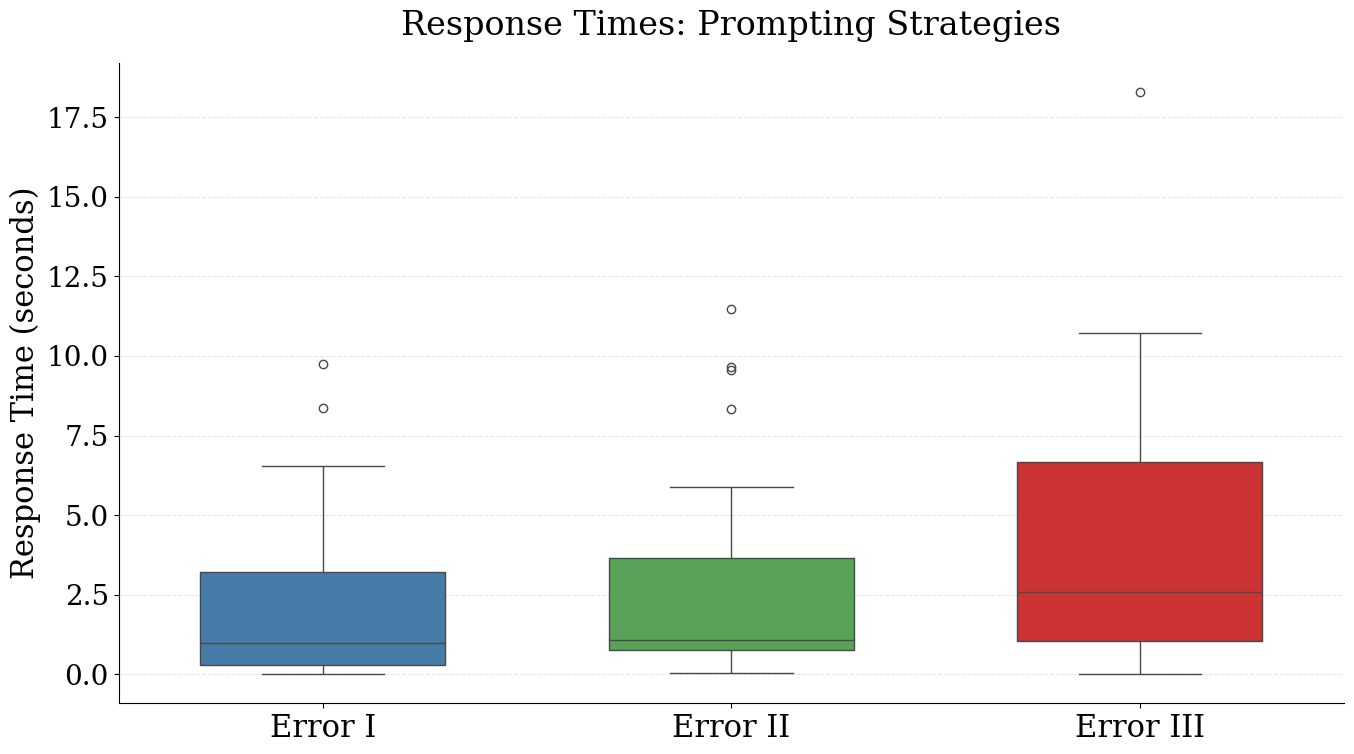


RESPONSE TIME STATISTICS

Error 1:
  Count: 36 responses
  Mean: 2.09s
  Median: 0.97s
  Std: 2.57s
  Q1: 0.30s
  Q3: 3.22s
  Range: 0.00s - 9.76s
  Outliers: 2 ([8.361999999999966, 9.759999999999991])

Error 2:
  Count: 25 responses
  Mean: 2.93s
  Median: 1.08s
  Std: 3.38s
  Q1: 0.75s
  Q3: 3.65s
  Range: 0.02s - 11.47s
  Outliers: 4 ([8.33499999999998, 9.57000000000005, 11.468000000000018, 9.639999999999986])

Error 3:
  Count: 30 responses
  Mean: 4.35s
  Median: 2.58s
  Std: 4.43s
  Q1: 1.04s
  Q3: 6.65s
  Range: 0.00s - 18.30s
  Outliers: 1 ([18.300000000000068])
Creating response times dataset for: ['repeats prompt', 'more specific/longer prompt', 'swaps terms', 'simpler prompt', 'slower speech', 'demanding tone', 'interrogative tone', 'filler words']
Step 1: Extracting error start times...
Found 154 error start times
Step 2: Loading and filtering reactions...
Found 161 reactions with relevant labels
Step 3: Calculating response times...
Created dataset with 156 response time 

/tmp/ipykernel_61261/3295178793.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Boxplot saved to 'plots/response_times_boxplot_verbal.png'


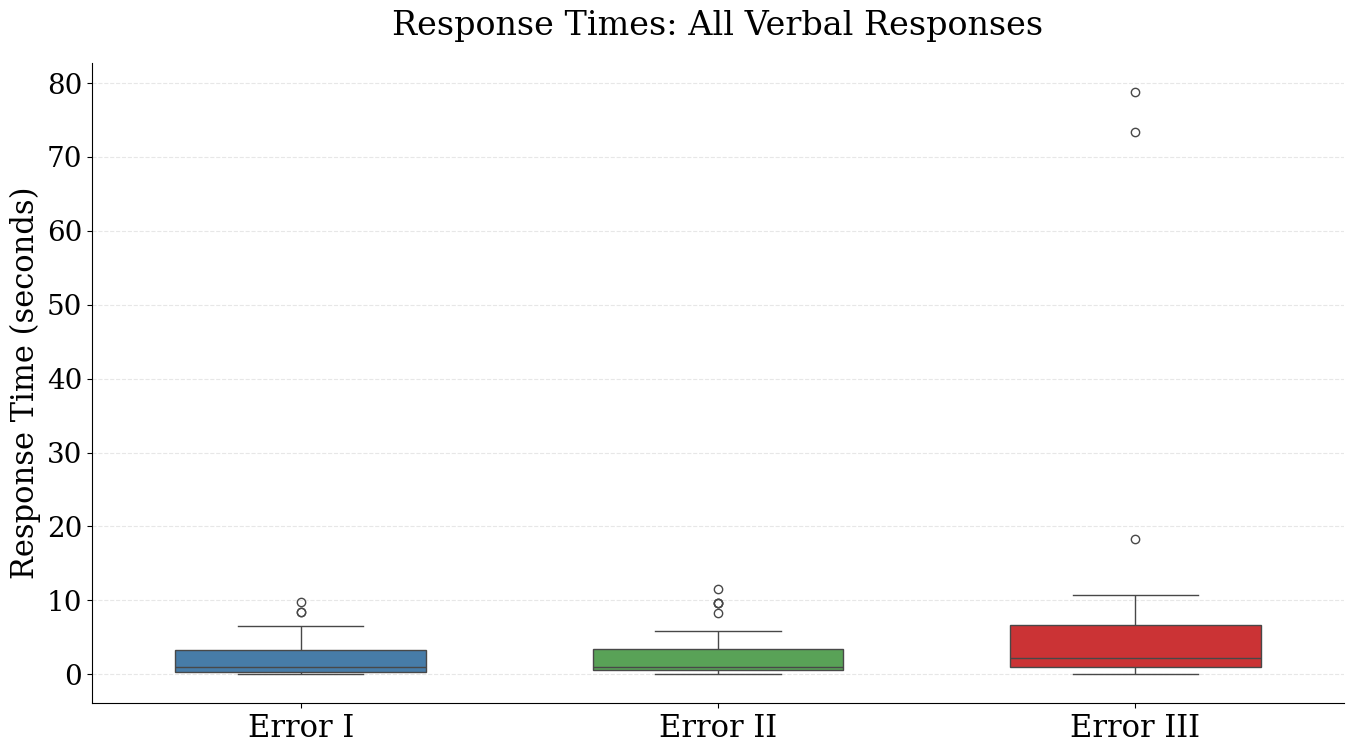


RESPONSE TIME STATISTICS

Error 1:
  Count: 67 responses
  Mean: 2.08s
  Median: 1.02s
  Std: 2.42s
  Q1: 0.35s
  Q3: 3.30s
  Range: 0.00s - 9.76s
  Outliers: 3 ([8.361999999999966, 8.361999999999966, 9.759999999999991])

Error 2:
  Count: 38 responses
  Mean: 2.57s
  Median: 0.96s
  Std: 3.14s
  Q1: 0.54s
  Q3: 3.41s
  Range: 0.02s - 11.47s
  Outliers: 5 ([8.33499999999998, 9.57000000000005, 9.57000000000005, 11.468000000000018, 9.639999999999986])

Error 3:
  Count: 51 responses
  Mean: 6.79s
  Median: 2.24s
  Std: 14.67s
  Q1: 1.03s
  Q3: 6.69s
  Range: 0.00s - 78.80s
  Outliers: 3 ([18.300000000000068, 73.37800000000004, 78.80499999999995])
Creating response times dataset for: ['amusement/humor', 'confusion', 'frustration']
Step 1: Extracting error start times...
Found 154 error start times
Step 2: Loading and filtering reactions...
Found 57 reactions with relevant labels
Step 3: Calculating response times...
Created dataset with 52 response time measurements
Response times datase

/tmp/ipykernel_61261/3295178793.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Boxplot saved to 'plots/response_times_boxplot_emotional.png'


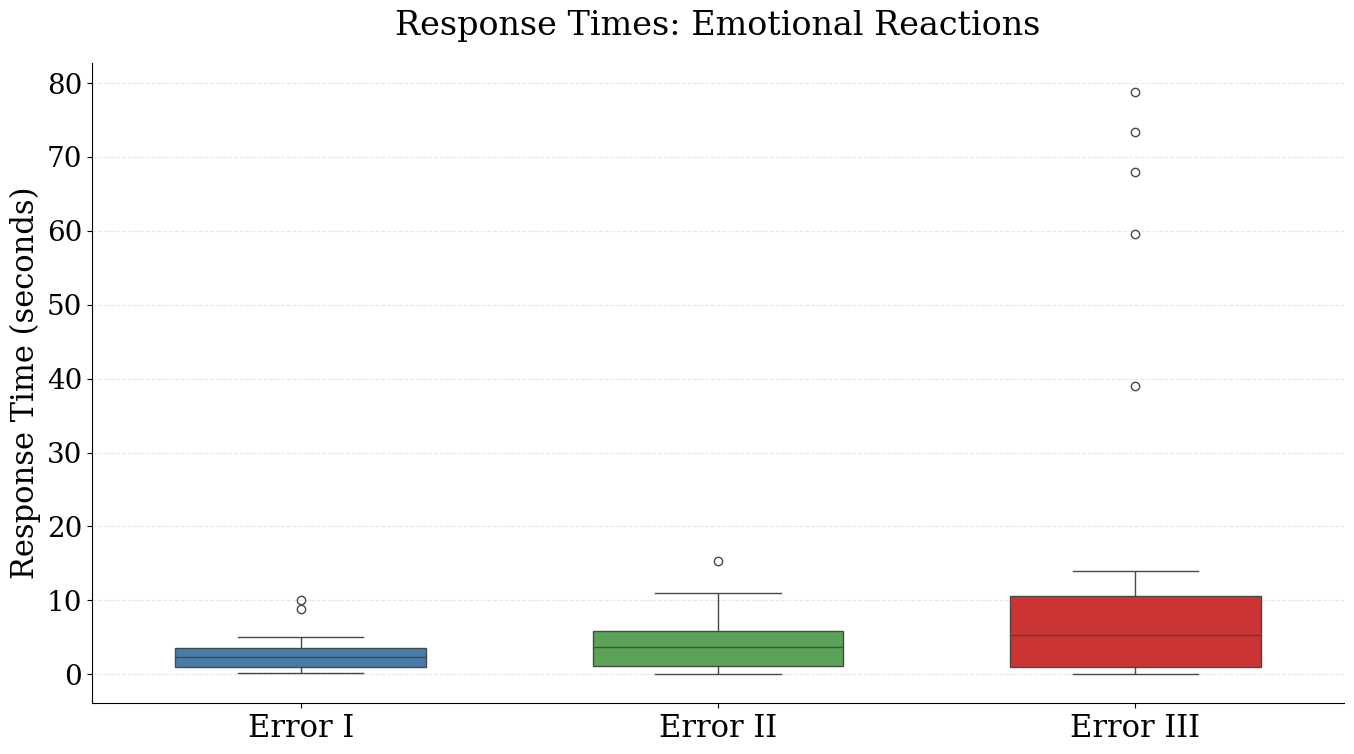


RESPONSE TIME STATISTICS

Error 1:
  Count: 14 responses
  Mean: 3.09s
  Median: 2.33s
  Std: 3.09s
  Q1: 0.95s
  Q3: 3.61s
  Range: 0.13s - 10.09s
  Outliers: 2 ([10.09499999999997, 8.850000000000023])

Error 2:
  Count: 14 responses
  Mean: 4.52s
  Median: 3.75s
  Std: 4.34s
  Q1: 1.08s
  Q3: 5.86s
  Range: 0.08s - 15.32s
  Outliers: 1 ([15.319999999999936])

Error 3:
  Count: 24 responses
  Mean: 16.80s
  Median: 5.37s
  Std: 25.67s
  Q1: 1.03s
  Q3: 10.65s
  Range: 0.02s - 78.80s
  Outliers: 5 ([39.03199999999998, 59.608000000000004, 67.90300000000002, 73.37800000000004, 78.80499999999995])


In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def time_to_seconds(time_str):
    """Convert HH:MM:SS.fff to total seconds"""
    try:
        parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds_parts = parts[2].split('.')
        seconds = int(seconds_parts[0])
        milliseconds = int(seconds_parts[1]) if len(seconds_parts) > 1 else 0
        
        total_seconds = hours * 3600 + minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    except:
        return np.nan

def create_response_times_dataset(relevant_labels=None):
    """Create a dataset of response times from error start to reaction start"""
    
    if relevant_labels is None:
        # Default to prompting strategies (using readable subcode names)
        relevant_labels = [
            "more specific/longer prompt", 
            "simpler prompt", 
            "repeats prompt", 
            "swaps terms"
        ]
    
    print(f"Creating response times dataset for: {relevant_labels}")
    
    # Step 1: Extract error start times from processed_codes.csv
    print("Step 1: Extracting error start times...")
    df = pd.read_csv("processed_codes.csv")
    df['start_seconds'] = df['start'].apply(time_to_seconds)
    df['end_seconds'] = df['end'].apply(time_to_seconds)
    
    # Get error start times (when each error interval begins)
    error_starts = []
    participants = df['participant_id'].unique()
    
    for participant in participants:
        p_data = df[df['participant_id'] == participant].sort_values('start_seconds')
        nounderstanding = p_data[p_data['subcode'] == '8nounderstanding3x']
        
        for i, (_, row) in enumerate(nounderstanding.iterrows()):
            error_num = i + 1  # Error 1, 2, 3
            if error_num <= 3:  # We only track up to 3 errors
                error_starts.append({
                    'participant_id': participant,
                    'error': error_num,
                    'error_start_time': row['end_seconds']  # Error interval starts when nounderstanding ends
                })
    
    error_starts_df = pd.DataFrame(error_starts)
    print(f"Found {len(error_starts_df)} error start times")
    
    # Step 2: Load filtered reactions
    print("Step 2: Loading and filtering reactions...")
    reactions_df = pd.read_csv('reactions_between_errors.csv')
    
    # Filter to relevant labels
    filtered_reactions = reactions_df[reactions_df['subcode_readable'].isin(relevant_labels)].copy()
    print(f"Found {len(filtered_reactions)} reactions with relevant labels")
    
    if len(filtered_reactions) == 0:
        print("WARNING: No reactions found with specified labels!")
        print(f"Available labels: {reactions_df['subcode_readable'].unique()}")
        return pd.DataFrame()
    
    # Convert reaction start times to seconds
    filtered_reactions['start_seconds'] = filtered_reactions['start'].apply(time_to_seconds)
    
    # Step 3: Match reactions with error start times to calculate response times
    print("Step 3: Calculating response times...")
    results = []
    
    for _, reaction_row in filtered_reactions.iterrows():
        participant = reaction_row['participant_id']
        error = reaction_row['error']
        reaction_start = reaction_row['start_seconds']
        
        # Find the matching error start time
        matching_error = error_starts_df[
            (error_starts_df['participant_id'] == participant) & 
            (error_starts_df['error'] == error)
        ]
        
        if not matching_error.empty:
            error_start_time = matching_error.iloc[0]['error_start_time']
            response_time = reaction_start - error_start_time
            
            # Only include positive response times (should always be positive in our data)
            if response_time >= 0:
                results.append({
                    'participant_id': participant,
                    'error': error,
                    'response_time': response_time,
                    'reaction_type': reaction_row['subcode_readable']
                })
            else:
                print(f"Warning: Negative response time for {participant}, error {error}: {response_time:.3f}s")
    
    results_df = pd.DataFrame(results)
    print(f"Created dataset with {len(results_df)} response time measurements")
    
    return results_df

def create_response_times_boxplot(relevant_labels=None, save_filename="response_times_boxplot.png", title_suffix=""):
    """Create boxplot showing response time distributions by error"""
    
    # Create the response times dataset
    response_times_df = create_response_times_dataset(relevant_labels)
    
    if len(response_times_df) == 0:
        print("No data available for boxplot")
        return
    
    # Save the dataset
    response_times_df.to_csv("response_times.csv", index=False)
    print("Response times dataset saved to 'response_times.csv'")
    
    print("\nResponse times summary:")
    print(response_times_df.groupby('error')['response_time'].describe())
    
    print(f"\nReaction types included:")
    print(response_times_df['reaction_type'].value_counts())
    
    # Create the boxplot
    plt.figure(figsize=(14, 8), facecolor='white')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'serif'})
    
    # Create boxplot with custom colors
    sns.boxplot(
        x='error', 
        y='response_time', 
        data=response_times_df, 
        palette=["#377EB8", "#4DAF4A", "#E41A1C"],  # Blue, Green, Red
        width=0.6
    )
    
    # Customize the plot
    plt.xlabel("", fontsize=22)
    plt.ylabel("Response Time (seconds)", fontsize=22)
    plt.xticks([0, 1, 2], ["Error I", "Error II", "Error III"], fontsize=22)
    plt.yticks(fontsize=20)
    
    # Add title if specified
    if title_suffix:
        plt.title(f"Response Times: {title_suffix}", fontsize=24, pad=20)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add light grid
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'plots/{save_filename}', format='png', dpi=500, facecolor="white", bbox_inches='tight')
    print(f"Boxplot saved to 'plots/{save_filename}'")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("RESPONSE TIME STATISTICS")
    print("="*60)
    
    for error_num in [1, 2, 3]:
        error_data = response_times_df[response_times_df['error'] == error_num]
        if len(error_data) > 0:
            print(f"\nError {error_num}:")
            print(f"  Count: {len(error_data)} responses")
            print(f"  Mean: {error_data['response_time'].mean():.2f}s")
            print(f"  Median: {error_data['response_time'].median():.2f}s")
            print(f"  Std: {error_data['response_time'].std():.2f}s")
            print(f"  Q1: {error_data['response_time'].quantile(0.25):.2f}s")
            print(f"  Q3: {error_data['response_time'].quantile(0.75):.2f}s")
            print(f"  Range: {error_data['response_time'].min():.2f}s - {error_data['response_time'].max():.2f}s")
            
            # Show outliers if any
            Q1 = error_data['response_time'].quantile(0.25)
            Q3 = error_data['response_time'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = error_data[(error_data['response_time'] < lower_bound) | 
                                 (error_data['response_time'] > upper_bound)]
            if len(outliers) > 0:
                print(f"  Outliers: {len(outliers)} ({outliers['response_time'].tolist()})")
        else:
            print(f"\nError {error_num}: No data")

# Example usage - Prompting Strategies
prompting_labels = [
    "more specific/longer prompt", 
    "simpler prompt", 
    "repeats prompt", 
    "swaps terms"
]

create_response_times_boxplot(
    relevant_labels=prompting_labels,
    save_filename="response_times_boxplot_prompting.png",
    title_suffix="Prompting Strategies"
)

# Example usage - All Verbal Responses
verbal_labels = [
    "repeats prompt", 
    "more specific/longer prompt", 
    "swaps terms", 
    "simpler prompt",
    "slower speech", 
    "demanding tone", 
    "interrogative tone", 
    "filler words"
]

create_response_times_boxplot(
    relevant_labels=verbal_labels,
    save_filename="response_times_boxplot_verbal.png",
    title_suffix="All Verbal Responses"
)

# Example usage - Emotional Reactions
emotional_labels = [
    "amusement/humor", 
    "confusion", 
    "frustration"
]

create_response_times_boxplot(
    relevant_labels=emotional_labels,
    save_filename="response_times_boxplot_emotional.png",
    title_suffix="Emotional Reactions"
)

# Function to compare multiple reaction categories in one plot
def create_multi_category_boxplot():
    """Create a more complex boxplot comparing different reaction categories"""
    
    categories = {
        "Prompting": ["repeats prompt", "more specific/longer prompt", "swaps terms", "simpler prompt"],
        "Tone": ["slower speech", "demanding tone", "interrogative tone", "filler words"],
        "Emotion": ["amusement/humor", "confusion", "frustration"],
        "Disengagement": ["looks at PC", "quitting", "changes position"]
    }
    
    all_data = []
    
    for category_name, labels in categories.items():
        response_times_df = create_response_times_dataset(labels)
        if len(response_times_df) > 0:
            response_times_df['category'] = category_name
            all_data.append(response_times_df)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Create subplot for each category
        fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')
        axes = axes.flatten()
        
        for i, (category_name, _) in enumerate(categories.items()):
            category_data = combined_df[combined_df['category'] == category_name]
            
            if len(category_data) > 0:
                sns.boxplot(
                    x='error', 
                    y='response_time', 
                    data=category_data,
                    palette=["#377EB8", "#4DAF4A", "#E41A1C"],
                    ax=axes[i]
                )
                
                axes[i].set_title(f"{category_name} Response Times", fontsize=16, fontweight='bold')
                axes[i].set_xlabel("")
                axes[i].set_ylabel("Response Time (s)", fontsize=14)
                axes[i].set_xticklabels(["Error I", "Error II", "Error III"])
                axes[i].grid(axis='y', alpha=0.3, linestyle='--')
            else:
                axes[i].text(0.5, 0.5, f'No data\nfor {category_name}', 
                            ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
                axes[i].set_title(f"{category_name} Response Times", fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('plots/response_times_boxplot_comparison.png', format='png', dpi=500, bbox_inches='tight')
        plt.show()
        
        print("Multi-category comparison saved to 'plots/response_times_boxplot_comparison.png'")
    else:
        print("No data available for multi-category comparison")

# Uncomment to create the multi-category comparison
# create_multi_category_boxplot()